In [1]:
# !pip install catboost optuna

In [2]:
# from google.colab import drive

# # Mount Google Drive
# drive.mount('/content/drive')

In [43]:
import os
import re

from typing import Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import catboost as cb

# import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, f1_score, roc_auc_score, accuracy_score, silhouette_score, pairwise_distances
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
from sklearn.utils.class_weight import compute_class_weight

# import optuna

import numba

from scipy.spatial.distance import pdist, squareform

import pickle

from scipy.sparse import csr_matrix, coo_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset

import xgboost as xgb


In [ ]:
# import numpy as np
# from catboost import CatBoostClassifier

# class OrdinalClassificationObjective(object):
#     def calc_ders_multi(self, approx, target, weight):
#         # Transform approx to log odds using Softmax
#         approx = [approx[i] - max(approx) for i in range(len(approx))]
#         exp_approx = [np.exp(approx[i]) for i in range(len(approx))]
#         exp_sum = sum(exp_approx)
        
#         # Compute probabilities
#         probs = [exp_approx[i] / exp_sum for i in range(len(approx))]
        
#         # Initialize gradient and Hessian
#         grad = [0.0] * len(approx)
#         hess = [[0.0] * len(approx) for _ in range(len(approx))]
        
#         # Compute the derivative (gradient) and Hessian
#         for j in range(len(approx)):
#             der1 = probs[j]
#             if j == target:
#                 der1 -= 1
#             der1 *= weight
            
#             for k in range(len(approx)):
#                 if j == k:
#                     der2 = probs[j] * (1 - probs[j])
#                 else:
#                     der2 = -probs[j] * probs[k]
#                 der2 *= weight
                
#                 hess[j][k] = der2
                
#             grad[j] = der1
        
#         return grad, hess

# # Define the model with the custom objective function
# model = CatBoostClassifier(
#     iterations=100,
#     loss_function=OrdinalClassificationObjective(),
#     eval_metric='Accuracy',
#     learning_rate=0.03,
#     bootstrap_type='Bayesian',
#     boost_from_average=False,
#     leaf_estimation_iterations=1,
#     leaf_estimation_method='Newton',
#     classes_count=5
# )

# # Prepare your data
# # X_train, y_train = ...

# # Fit the model
# # model.fit(X_train, y_train)


Resources:  https://towardsdatascience.com/catboost-regression-in-6-minutes-3487f3e5b329

### Load and Clean Data

#### General

In [2]:
datapath = './data/' # local
# datapath = r'/content/drive/MyDrive/Colab Notebooks/DD_earthquake_data/' # colab
# datapath = r'/kaggle/input/drivendata-earthquake/' # kaggle

df_train_features_raw = pd.read_csv(datapath+'train_values.csv').set_index('building_id')
df_train_labels_raw = pd.read_csv(datapath+'train_labels.csv').set_index('building_id')
df_pred_features_raw = pd.read_csv(datapath+'test_values.csv').set_index('building_id')

- No missing data to fill

In [3]:
def preprocess(df_features):
    # Convert numeric features to float
    df_features = df_features.astype({'count_floors_pre_eq':'float',
                                      'age':'float',
                                      'area_percentage':'float',
                                      'height_percentage':'float',
                                      'count_families':'float'})
    return df_features

In [4]:
# Feature groups
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']
# non_geo_features_w_label = categorical_features + numerical_features + ['damage_grade']
# for geo_feat in geo_features:
#     non_geo_features_w_label.remove(geo_feat)

### AutoEncode Geography (Pytorch)

#### Impute damage_grade of test features

In [5]:
def impute_damage_grade(df_train_X: pd.DataFrame,df_val_X: pd.DataFrame,
                        df_test_X: pd.DataFrame,df_pred_X: pd.DataFrame,
                        df_train_y: pd.DataFrame, df_val_y: Optional[pd.DataFrame]=None,
                        df_test_y: Optional[pd.DataFrame]=None) -> pd.DataFrame:
    '''
    Impute damage grade based on location (i.e. the three geo features). This function
    
    The original dataset
    should first be split into train, val and test sets. The imputation will be done using all
    features from all datasets, but only labels from the train dataset to prevent date leakage.
    df_train_X: Post splitting X dataframe for training
    df_val_X: Post splitting X dataframe for validation set
    df_test_X: Post splt
    '''
    # Preprocess to convert numerical features to float
    df_train_X = preprocess(df_train_X.copy())
    df_val_X = preprocess(df_val_X.copy())
    df_test_X = preprocess(df_test_X.copy())
    df_pred_X = preprocess(df_pred_X.copy())

    df_all = pd.concat([df_train_X,df_train_y],axis=1)
    
    if df_val_y is not None:
        df_val_X = pd.concat([df_val_X,df_val_y],axis=1)
    if df_test_y is not None:
        df_test_X = pd.concat([df_test_X,df_test_y],axis=1)
        
    df_all = pd.concat([df_all,df_val_X,df_test_X,df_pred_X],axis=0)

    df_all['geo_combined3'] = df_all.apply(lambda row: str(row['geo_level_1_id']) + '_' + str(row['geo_level_2_id']) + '_' + str(row['geo_level_3_id']), axis=1)
    df_all['geo_combined2'] = df_all.apply(lambda row: str(row['geo_level_1_id']) + '_' + str(row['geo_level_2_id']), axis=1)

    # Fillna for damage_grade with means for geo level 3
    damage_means3 = df_all.groupby('geo_combined3')['damage_grade'].mean()
    df_all['damage_grade'] = df_all.apply(lambda row: damage_means3[row['geo_combined3']] if pd.isna(row['damage_grade']) else row['damage_grade'], axis=1)

    # Fillna for damage_grade with means for lowest geo level 2
    damage_means2 = df_all.groupby('geo_combined2')['damage_grade'].mean()
    df_all['damage_grade'] = df_all.apply(lambda row: damage_means2[row['geo_combined2']] if pd.isna(row['damage_grade']) else row['damage_grade'], axis=1)

    # Fillna for damage_grade with means for lowest geo level 2
    damage_means1 = df_all.groupby('geo_level_1_id')['damage_grade'].mean()
    df_all['damage_grade'] = df_all.apply(lambda row: damage_means1[row['geo_level_1_id']] if pd.isna(row['damage_grade']) else row['damage_grade'], axis=1)

    # Drop unwanted columns
    df_all.drop(columns=['geo_combined2','geo_combined3'],inplace=True)
    df_all = pd.get_dummies(df_all,columns=[col for col in categorical_features if not (col in geo_features)],drop_first=True)

    # Get feature names
    non_geo_features_OHE = [col for col in df_all.columns if not (col in geo_features)]

    return df_all, non_geo_features_OHE

In [6]:
# Split into train, val, test and pred sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y)

#### Geo-features + other categorical features

To iterate over:
1. architecture and weights
2. latent size
3. Number of epochs

In [7]:
# Define the autoencoder
class CategoricalAutoencoder(nn.Module):
    def __init__(self, geo1_size, geo2_size, geo3_size, inter_size, latent_size):
        super(CategoricalAutoencoder, self).__init__()
        self.geo1_size = geo1_size
        self.geo2_size = geo2_size
        self.geo3_size = geo3_size

        # Embedding layers for each categorical input
        self.embed1 = nn.Embedding(31, geo1_size)
        self.embed2 = nn.Embedding(1418, geo2_size)
        self.embed3 = nn.Embedding(11861, geo3_size)
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(geo1_size + geo2_size + geo3_size + 58, inter_size),
            nn.ReLU(),
            nn.Linear(inter_size, latent_size)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, inter_size),
            nn.ReLU(),
            nn.Linear(inter_size, geo1_size + geo2_size + geo3_size + 58)
        )
        
        # Output layers for each categorical input
        self.output1 = nn.Linear(geo1_size, 31)
        self.output2 = nn.Linear(geo2_size, 1418)
        self.output3 = nn.Linear(geo3_size, 11861)
        
    def forward(self, x1, x2, x3, feats):
        # Embedding the inputs
        x1 = self.embed1(x1)
        x2 = self.embed2(x2)
        x3 = self.embed3(x3)
        
        # Concatenate embeddings
        x = torch.cat([x1, x2, x3, feats], dim=1)
        
        # Encode
        z = self.encoder(x)
        
        # Decode
        x_recon = self.decoder(z)
        
        # Split the reconstructed output
        x1_recon, x2_recon, x3_recon, feats_recon = torch.split(x_recon, [self.geo1_size, self.geo2_size, self.geo3_size, 58], dim=1)
        
        # Get the output logits for each categorical input
        x1_out = self.output1(x1_recon)
        x2_out = self.output2(x2_recon)
        x3_out = self.output3(x3_recon)
        
        return x1_out, x2_out, x3_out, feats_recon

def get_latent_geo(df_all:pd.DataFrame, non_geo_features_OHE:list, geo1_size:int = 16, geo2_size:int = 32,
                   geo3_size:int = 64, inter_size:int = 128,
                   latent_size:int = 64, epochs:int = 10):
    '''
    Build autoencoder network and get latent geo-encoding based on defined architecture.
    geo1_size: Embedding dimension for first geo level
    geo2_size: Embedding dimension for second geo level
    geo3_size: Embedding dimension for third geo level
    inter_size: Output (input) size of encoder's (decoder's) first (last) linear layer, interfacing with latent values
    epochs: Number of epochs to run model
    '''
    # Instantiate the model
    model = CategoricalAutoencoder(geo1_size, geo2_size, geo3_size, inter_size, latent_size).cuda()

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Create DataLoader
    df = df_all.copy()
    bool_cols = df.select_dtypes(include='bool').columns
    df[bool_cols] = df[bool_cols].astype(float)

    # Encode the categorical columns
    le_cat1 = LabelEncoder()
    le_cat2 = LabelEncoder()
    le_cat3 = LabelEncoder()

    df['geo_level_1_id'] = le_cat1.fit_transform(df['geo_level_1_id'])
    df['geo_level_2_id'] = le_cat2.fit_transform(df['geo_level_2_id'])
    df['geo_level_3_id'] = le_cat3.fit_transform(df['geo_level_3_id'])

    # Convert DataFrame to tensors
    x1 = torch.tensor(df['geo_level_1_id'].values, dtype=torch.long).cuda()
    x2 = torch.tensor(df['geo_level_2_id'].values, dtype=torch.long).cuda()
    x3 = torch.tensor(df['geo_level_3_id'].values, dtype=torch.long).cuda()

    feat_tensor = torch.tensor(df[non_geo_features_OHE].values, dtype=torch.float).cuda()

    # Create DataLoader
    dataset = TensorDataset(x1, x2, x3, feat_tensor)
    dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

    # Training loop with tqdm
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}'):
            x1_batch, x2_batch, x3_batch, feats_batch = batch
            optimizer.zero_grad()
            
            # Forward pass
            x1_out, x2_out, x3_out, feats_recon = model(x1_batch, x2_batch, x3_batch, feats_batch)
            
            # Compute the loss
            loss = criterion(x1_out, x1_batch) + \
                criterion(x2_out, x2_batch) + \
                criterion(x3_out, x3_batch)
            
            loss_feat = nn.MSELoss()(feats_recon, feats_batch)

            total_loss = loss + loss_feat

            # Backward pass and optimization
            total_loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss/len(dataloader)}')


    # Extract encoding for each location
    # Pass the input through the encoder and plot the results
    model.eval()
    z_list = []

    eval_dataloader = DataLoader(dataset, batch_size=128, shuffle=False)

    with torch.no_grad():
        for batch in tqdm(eval_dataloader, desc='Evaluating'):
            x1_batch, x2_batch, x3_batch, feat_tensor = batch
            
            # Forward pass
            z_batch = model.encoder(torch.cat([model.embed1(x1_batch),
                                            model.embed2(x2_batch),
                                            model.embed3(x3_batch),
                                            feat_tensor],
                                            dim=1))
        
            # Move tensors to CPU
            z_list.append(z_batch.cpu())
            
            # Clear cache
            torch.cuda.empty_cache()

    # Concatenate results
    z = torch.cat(z_list, dim=0)
    latent_geo = pd.concat([df_all.iloc[:,:3].reset_index(drop=True),pd.DataFrame(z.cpu().numpy())],axis=1)
    latent_geo = latent_geo.groupby(geo_features).mean().reset_index() # Get average latent values

    return latent_geo, model, dataset, x1, x2, x3



# # Define the autoencoder
# class CategoricalAutoencoder(nn.Module):
#     def __init__(self, geo1_size, geo2_size, geo3_size, inter_size, latent_size, dropout_prob=0.3):
#         super(CategoricalAutoencoder, self).__init__()
#         self.geo1_size = geo1_size
#         self.geo2_size = geo2_size
#         self.geo3_size = geo3_size

#         # Embedding layers for each categorical input
#         self.embed1 = nn.Embedding(31, geo1_size)
#         self.embed2 = nn.Embedding(1418, geo2_size)
#         self.embed3 = nn.Embedding(11861, geo3_size)
        
#         # Encoder
#         self.encoder = nn.Sequential(
#             nn.Linear(geo1_size + geo2_size + geo3_size + 58, inter_size),
#             nn.ReLU(),
#             nn.Dropout(dropout_prob),
#             nn.Linear(inter_size, latent_size),
#             nn.ReLU(),
#             nn.Dropout(dropout_prob)
#         )
        
#         # Decoder
#         self.decoder = nn.Sequential(
#             nn.Linear(latent_size, inter_size),
#             nn.ReLU(),
#             nn.Dropout(dropout_prob),
#             nn.Linear(inter_size, geo1_size + geo2_size + geo3_size + 58),
#             nn.ReLU(),
#             nn.Dropout(dropout_prob)
#         )
        
#         # Output layers for each categorical input
#         self.output1 = nn.Linear(geo1_size, 31)
#         self.output2 = nn.Linear(geo2_size, 1418)
#         self.output3 = nn.Linear(geo3_size, 11861)
        
#     def forward(self, x1, x2, x3, feats):
#         # Embedding the inputs
#         x1 = self.embed1(x1)
#         x2 = self.embed2(x2)
#         x3 = self.embed3(x3)
        
#         # Concatenate embeddings
#         x = torch.cat([x1, x2, x3, feats], dim=1)
        
#         # Encode
#         z = self.encoder(x)
        
#         # Decode
#         x_recon = self.decoder(z)
        
#         # Split the reconstructed output
#         x1_recon, x2_recon, x3_recon, feats_recon = torch.split(x_recon, [self.geo1_size, self.geo2_size, self.geo3_size, 58], dim=1)
        
#         # Get the output logits for each categorical input
#         x1_out = self.output1(x1_recon)
#         x2_out = self.output2(x2_recon)
#         x3_out = self.output3(x3_recon)
        
#         return x1_out, x2_out, x3_out, feats_recon

In [ ]:
geo_n_lat_n = [(16,32,64,128,64),(16,32,64,128,32),(16,32,64,128,16),(16,32,64,128,8),(16,32,64,128,4)]
geo_n_lat_n += [(8,16,32,64,32),(8,16,32,64,16),(8,16,32,64,8),(8,16,32,64,4)]
geo_n_lat_n += [(4,8,16,64,32),(4,8,16,64,16),(4,8,16,64,8),(4,8,16,64,4)]
epo_n = [1,2,4,8,10,12,16,20,25,30,40]

for combo in geo_n_lat_n:
    for epochs in epo_n:
        geo1_size = combo[0]
        geo2_size = combo[1]
        geo3_size = combo[2]
        inter_size = combo[3]
        latent_size = combo[4]

        pickle_name = f'latent_geo_geo1_{geo1_size}_geo2_{geo2_size}_geo3_{geo3_size}_inter_{inter_size}_lat_{latent_size}_epo_{epochs}.pkl'

        print(f'\n\n\n~~~~~~~~~~~~~~~~~Now running {pickle_name[:-4]}~~~~~~~~~~~~~~~~~')

        latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

        with open(pickle_name,'wb') as f:
            pickle.dump(latent_geo,f)

## CatBoost Regressor

Quick check with vanilla approach

In [7]:
# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

df_train_features = preprocess(df_train_features_raw)
df_test_features = preprocess(df_test_features_raw)

X_train_or, X_test, y_train_or, y_test = train_test_split(df_train_features, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
X_train, X_val, y_train, y_val = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
 
# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(X_train.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=X_train, label=y_train, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=X_val, label=y_val, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=X_test, label=y_test, cat_features=categorical_features_indices)

In [17]:
# Instantiate catboost regressor model
model = cb.CatBoostRegressor(loss_function='RMSE',task_type='GPU',devices='0',metric_period=100)

# Grid search training
grid = {'iterations': [600,800],
        'learning_rate': [0.1,0.2],
        'depth': [8],
        'l2_leaf_reg': [5]}
model.grid_search(grid, train_dataset,verbose=False)

with open('cb_1.pkl','wb') as f:
    pickle.dump(model,f)

0:	learn: 2.0999503	test: 2.1026331	best: 2.1026331 (0)	total: 36.4ms	remaining: 21.8s
100:	learn: 0.4604643	test: 0.4565330	best: 0.4565330 (100)	total: 3.04s	remaining: 15s
200:	learn: 0.4570157	test: 0.4539142	best: 0.4539142 (200)	total: 5.98s	remaining: 11.9s
300:	learn: 0.4551188	test: 0.4528420	best: 0.4528420 (300)	total: 8.89s	remaining: 8.83s
400:	learn: 0.4534276	test: 0.4518584	best: 0.4518584 (400)	total: 11.8s	remaining: 5.85s
500:	learn: 0.4520410	test: 0.4511871	best: 0.4511871 (500)	total: 14.7s	remaining: 2.9s
599:	learn: 0.4509619	test: 0.4506409	best: 0.4506409 (599)	total: 17.6s	remaining: 0us
bestTest = 0.4506408541
bestIteration = 599
0:	learn: 1.8815759	test: 1.8839833	best: 1.8839833 (0)	total: 32.4ms	remaining: 19.4s
100:	learn: 0.4567280	test: 0.4537866	best: 0.4537866 (100)	total: 3.02s	remaining: 14.9s
200:	learn: 0.4543522	test: 0.4524706	best: 0.4524706 (200)	total: 5.84s	remaining: 11.6s
300:	learn: 0.4524312	test: 0.4515912	best: 0.4515912 (300)	total: 

In [22]:
# # Load model
# with open('cb_1.pkl','rb') as f:
#     model = pickle.load(f)
model.get_params()

{'loss_function': 'RMSE',
 'metric_period': 100,
 'task_type': 'GPU',
 'devices': '0',
 'depth': 8,
 'learning_rate': 0.2,
 'l2_leaf_reg': 5,
 'iterations': 800}

In [23]:
# Evaluation
pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

print('Testing performance')
print(f'RMSE: {rmse:.2f}')
print(f'R2: {r2:.2f}')

pred_int = np.round(np.clip(pred,1,3))
f1_score(y_test,pred_int,average='micro')

Testing performance
RMSE: 0.44
R2: 0.48


0.7452354761965669

In [28]:
# Single model and evaluation
model = cb.CatBoostRegressor(loss_function='RMSE',
                             task_type='GPU',devices='0',
                             metric_period=500,
                             iterations=2000, learning_rate=0.2, depth=8,l2_leaf_reg=5)
model.fit(train_dataset)

pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

print('Testing performance')
print(f'RMSE: {rmse:.2f}')
print(f'R2: {r2:.2f}')

pred_int = np.round(np.clip(pred,1,3))
f1_score(y_test,pred_int,average='micro')

0:	learn: 0.5696507	total: 14.1ms	remaining: 28.2s
500:	learn: 0.4266956	total: 5.68s	remaining: 17s
1000:	learn: 0.4061295	total: 11.4s	remaining: 11.4s
1500:	learn: 0.3882719	total: 17.1s	remaining: 5.69s
1999:	learn: 0.3722416	total: 22.9s	remaining: 0us
Testing performance
RMSE: 0.44
R2: 0.48


0.7470773323782968

## CatBoost Regressor geo encoded

### General Flow

In [57]:
# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y, df_val_y)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# # Save geo-encoding
# with open('latent_geo_1.pkl','wb') as f:
#     pickle.dump(latent_geo, f)

# # Load geo-encoding
# with open('latent_geo_1.pkl','rb') as f:
#     latent_geo = pickle.load(f)

# Apply encoding
df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

df_train_X.drop(columns=geo_features, inplace=True)
df_val_X.drop(columns=geo_features, inplace=True)
df_test_X.drop(columns=geo_features, inplace=True)
df_pred_X.drop(columns=geo_features, inplace=True)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_X.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y],axis=0),
                            cat_features=categorical_features_indices)
train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                            cat_features=categorical_features_indices)

# Instantiate catboost regressor model
model_reg = cb.CatBoostRegressor(loss_function='RMSE',
                             task_type='GPU',devices='0',
                             metric_period=500,
                             iterations=2000, learning_rate=0.2, depth=8,l2_leaf_reg=5)
model_reg.fit(train_val_dataset)

# Evaluation
pred = model_reg.predict(df_test_X)
rmse = (np.sqrt(mean_squared_error(df_test_y, pred)))
r2 = r2_score(df_test_y, pred)

print('Testing performance')
print(f'RMSE: {rmse:.2f}')
print(f'R2: {r2:.2f}')

pred_int = np.round(np.clip(pred,1,3))
f1_score(df_test_y,pred_int,average='micro')

Epoch 1/10: 100%|██████████| 1358/1358 [00:04<00:00, 275.21it/s]


Epoch [1/10], Loss: 6.821518117839001


Epoch 2/10: 100%|██████████| 1358/1358 [00:04<00:00, 273.22it/s]


Epoch [2/10], Loss: 0.44760487040172886


Epoch 3/10: 100%|██████████| 1358/1358 [00:04<00:00, 282.25it/s]


Epoch [3/10], Loss: 0.21243134547238937


Epoch 4/10: 100%|██████████| 1358/1358 [00:04<00:00, 284.43it/s]


Epoch [4/10], Loss: 0.1494405378850893


Epoch 5/10: 100%|██████████| 1358/1358 [00:04<00:00, 292.57it/s]


Epoch [5/10], Loss: 0.12478670937939107


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 288.56it/s]


Epoch [6/10], Loss: 0.09917731812142867


Epoch 7/10: 100%|██████████| 1358/1358 [00:05<00:00, 261.07it/s]


Epoch [7/10], Loss: 0.07836067318605651


Epoch 8/10: 100%|██████████| 1358/1358 [00:04<00:00, 273.02it/s]


Epoch [8/10], Loss: 0.08143408550412445


Epoch 9/10: 100%|██████████| 1358/1358 [00:05<00:00, 230.82it/s]


Epoch [9/10], Loss: 0.06679536607336775


Epoch 10/10: 100%|██████████| 1358/1358 [00:05<00:00, 259.71it/s]


Epoch [10/10], Loss: 0.05534676405517964


Evaluating: 100%|██████████| 2715/2715 [00:03<00:00, 880.76it/s] 


0:	learn: 0.5848741	total: 16.7ms	remaining: 33.3s
500:	learn: 0.4159322	total: 7.14s	remaining: 21.4s
1000:	learn: 0.3941812	total: 14s	remaining: 14s
1500:	learn: 0.3777900	total: 21s	remaining: 6.97s
1999:	learn: 0.3637712	total: 28.1s	remaining: 0us
Testing performance
RMSE: 0.44
R2: 0.49


0.7504284873756107

### Parametric Study - Select Best Encoding

In [7]:
# Prep dataframe for storing validation scores
encoding_path = './kaggle_output_1/'
encoders = []
for file in os.listdir(encoding_path):
    if file.endswith(".pkl"):
        encoders.append(file)

# Define the patterns to extract numbers after specific substrings
patterns = {
    'geo1': r'geo1_(\d+)',
    'geo2': r'geo2_(\d+)',
    'geo3': r'geo3_(\d+)',
    'inter': r'inter_(\d+)',
    'lat': r'lat_(\d+)',
    'epo': r'epo_(\d+)'
}

archis = []
for encoder in encoders:
    # Extract numbers using regex
    extracted_numbers = {}
    for key, pattern in patterns.items():
        match = re.search(pattern, encoder)
        if match:
            extracted_numbers[key] = int(match.group(1))
    archis.append(extracted_numbers)

archis = pd.DataFrame(archis)
archis['val_rmse'] = None
archis['val_r2'] = None
archis['val_f1'] = None
archis['iterations'] = None

In [8]:
# Prep data for catboost
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

num_encoders = len(encoders)

iterationss = [2000]
for iterations in iterationss:
    for j, encoder in enumerate(encoders):
        print(f'\n\n Running encoder: {encoder}, {j} of {num_encoders}')
        # Load encoder
        with open(encoding_path+encoder,'rb') as f:
            latent_geo = pickle.load(f)

        # Apply encoder
        df_train_X_temp = df_train_X.merge(latent_geo,on=geo_features,how='left')
        df_train_X_temp.drop(columns=geo_features, inplace=True)
        df_val_X_temp = df_val_X.merge(latent_geo,on=geo_features,how='left')
        df_val_X_temp.drop(columns=geo_features, inplace=True)

        # Get categorical feature indices and names
        categorical_features_indices = []
        for i,dtype in enumerate(df_train_X_temp.dtypes):
            if dtype in ['int64','int32','object','category']:
                categorical_features_indices.append(i)

        # Creating pooled datasets for catboost
        train_dataset = cb.Pool(data=df_train_X_temp, label=df_train_y, cat_features=categorical_features_indices)
        val_dataset = cb.Pool(data=df_val_X_temp, label=df_val_y, cat_features=categorical_features_indices)

        # Instantiate catboost regressor model and fit
        model = cb.CatBoostRegressor(loss_function='RMSE',
                                    task_type='GPU',devices='0',
                                    metric_period=500,
                                    iterations=iterations, learning_rate=0.2, depth=8,l2_leaf_reg=5)
        model.fit(train_dataset)

        # Evaluation
        pred = model.predict(df_val_X_temp)
        rmse = (np.sqrt(mean_squared_error(df_val_y, pred)))
        r2 = r2_score(df_val_y, pred)
        pred_int = np.round(np.clip(pred,1,3))
        f1 = f1_score(df_val_y,pred_int,average='micro')

        print(f'RMSE: {rmse}, R2-score: {r2}, F1-score: {f1}, iterations = {iterations}')

        archis.loc[j,'rmse'] = rmse
        archis.loc[j,'r2'] = r2
        archis.loc[j,'f1'] = f1
        archis.loc[j,'iterations'] = iterations



 Running encoder: latent_geo_geo1_8_geo2_16_geo3_32_inter_64_lat_64_epo_10.pkl, 0 of 165
0:	learn: 0.5843077	total: 15.9ms	remaining: 31.7s
500:	learn: 0.4138695	total: 6.26s	remaining: 18.7s
1000:	learn: 0.3904681	total: 12.8s	remaining: 12.8s
1500:	learn: 0.3719462	total: 19.4s	remaining: 6.46s
1999:	learn: 0.3563713	total: 26s	remaining: 0us
RMSE: 0.44442203062732943, R2-score: 0.47233073905325973, F1-score: 0.743160682577422, iterations = 2000


 Running encoder: latent_geo_geo1_16_geo2_32_geo3_64_inter_128_lat_32_epo_1.pkl, 1 of 165
0:	learn: 0.5868244	total: 12.3ms	remaining: 24.6s
500:	learn: 0.4168597	total: 6.07s	remaining: 18.2s
1000:	learn: 0.3920407	total: 12.4s	remaining: 12.3s
1500:	learn: 0.3729770	total: 18.6s	remaining: 6.19s
1999:	learn: 0.3564956	total: 25s	remaining: 0us
RMSE: 0.44473263359874626, R2-score: 0.47159291373522016, F1-score: 0.742107322358323, iterations = 2000


 Running encoder: latent_geo_geo1_16_geo2_32_geo3_64_inter_128_lat_32_epo_8.pkl, 2 of 165

In [9]:
archis.to_csv('param_study_2000.csv',index=None)

## Catboost Classifier geo encoded

### General Flow

In [58]:
# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y,df_val_y)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# Apply encoding
df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

df_train_X.drop(columns=geo_features, inplace=True)
df_val_X.drop(columns=geo_features, inplace=True)
df_test_X.drop(columns=geo_features, inplace=True)
df_pred_X.drop(columns=geo_features, inplace=True)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_X.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y],axis=0),
                            cat_features=categorical_features_indices)
train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                            cat_features=categorical_features_indices)

# Instantiate catboost classifier model
model_cls = cb.CatBoostClassifier(
    objective='MultiClass',  # Use 'MultiClass' for classification
    task_type='GPU',  # Specify GPU if available
    devices='0',  # Specify GPU device(s) if multiple
    metric_period=500,  # Period to print metrics
    iterations=1500,  # Number of boosting iterations
    learning_rate=0.1,  # Learning rate
    depth=8,  # Depth of the trees
    l2_leaf_reg=5,  # L2 regularization coefficient
    custom_metric=['Accuracy']  # Additional metrics to track
)

model_cls.fit(train_val_dataset)

# Evaluation
pred = model_cls.predict(df_test_X)
acc = accuracy_score(df_test_y, pred)
f1 = f1_score(df_test_y,pred,average='micro')

print('Testing performance')
print(f'Accuracy: {acc:.4f}')
print(f'F1-score: {f1:.4f}')


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 386.75it/s]


Epoch [1/10], Loss: 7.061145260622821


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 384.72it/s]


Epoch [2/10], Loss: 0.4788684255069064


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 370.40it/s]


Epoch [3/10], Loss: 0.22499815530976244


Epoch 4/10: 100%|██████████| 1358/1358 [00:04<00:00, 304.79it/s]


Epoch [4/10], Loss: 0.1506503505888772


Epoch 5/10: 100%|██████████| 1358/1358 [00:04<00:00, 272.92it/s]


Epoch [5/10], Loss: 0.11512097466595757


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 340.60it/s]


Epoch [6/10], Loss: 0.08319380299348675


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 379.43it/s]


Epoch [7/10], Loss: 0.09664287108589177


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 363.25it/s]


Epoch [8/10], Loss: 0.06752443985618509


Epoch 9/10: 100%|██████████| 1358/1358 [00:04<00:00, 284.53it/s]


Epoch [9/10], Loss: 0.06283175011181899


Epoch 10/10: 100%|██████████| 1358/1358 [00:05<00:00, 264.77it/s]


Epoch [10/10], Loss: 0.06469296652143712


Evaluating: 100%|██████████| 2715/2715 [00:03<00:00, 749.18it/s]


0:	learn: 1.0476300	total: 12.9ms	remaining: 19.3s
500:	learn: 0.5433949	total: 5.37s	remaining: 10.7s
1000:	learn: 0.5015456	total: 10.6s	remaining: 5.27s
1499:	learn: 0.4713783	total: 15.7s	remaining: 0us
Testing performance
Accuracy: 0.7530
F1-score: 0.7530


<BarContainer object of 163 artists>

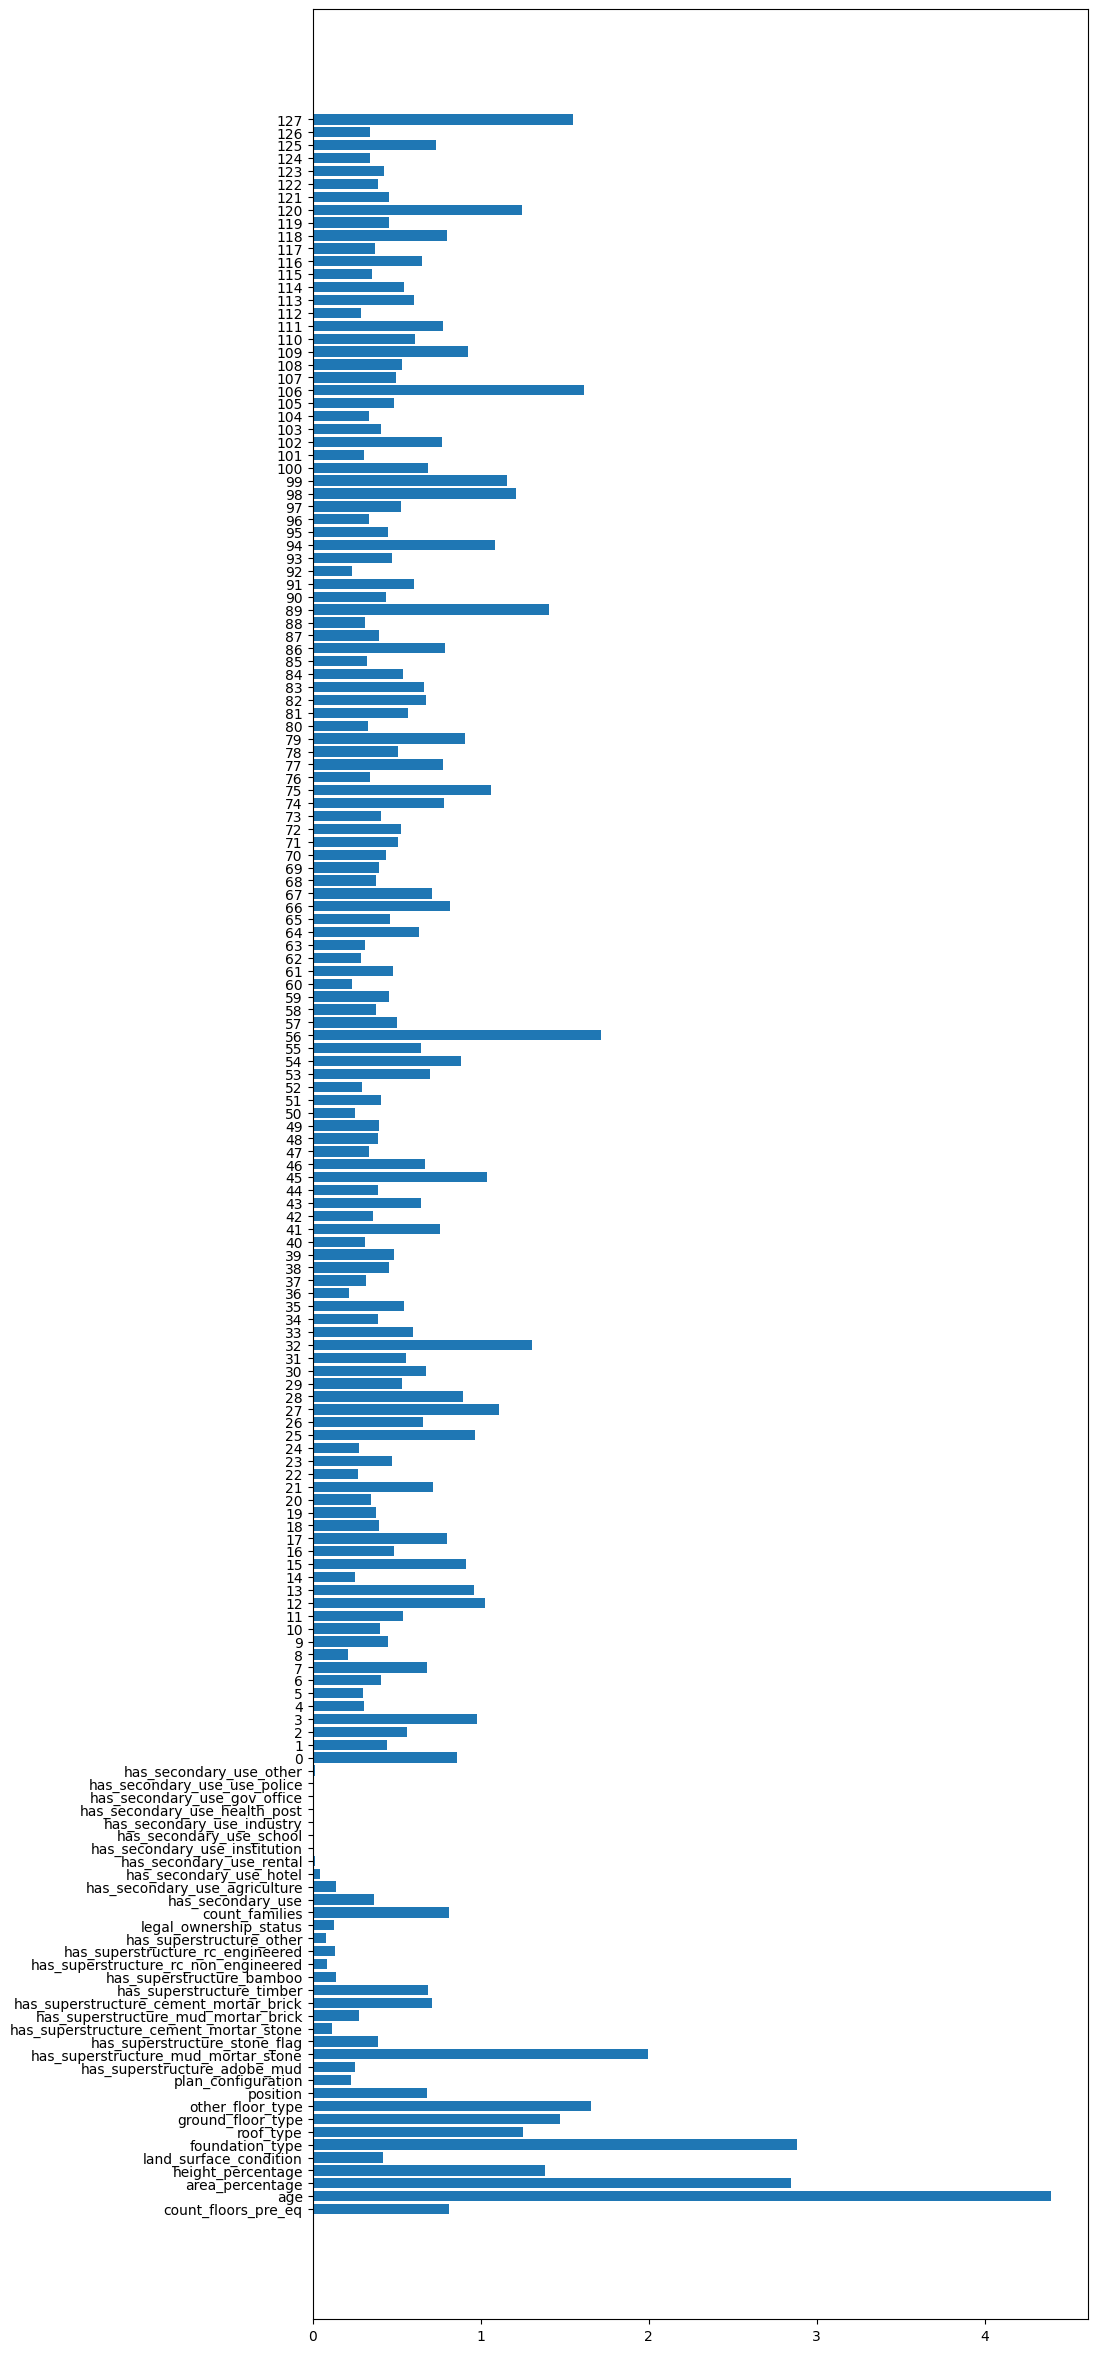

In [95]:
fig,ax = plt.subplots(1,1,figsize=(10,30))
ax.barh([str(col) for col in df_train_X.columns], model_cls.feature_importances_)


In [102]:
# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y,df_val_y)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# Apply encoding
df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

df_train_X.drop(columns=geo_features, inplace=True)
df_val_X.drop(columns=geo_features, inplace=True)
df_test_X.drop(columns=geo_features, inplace=True)
df_pred_X.drop(columns=geo_features, inplace=True)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_X.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y],axis=0),
                            cat_features=categorical_features_indices)
train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                            cat_features=categorical_features_indices)

# Instantiate catboost classifier model
model_cls = cb.CatBoostClassifier(
    objective='MultiClass',  # Use 'MultiClass' for classification
    task_type='GPU',  # Specify GPU if available
    devices='0',  # Specify GPU device(s) if multiple
    metric_period=500,  # Period to print metrics
    iterations=20000,  # Number of boosting iterations
    learning_rate=0.01,  # Learning rate
    depth=8,  # Depth of the trees
    l2_leaf_reg=5,  # L2 regularization coefficient
    custom_metric=['Accuracy']  # Additional metrics to track
)

model_cls.fit(train_val_dataset)

# Evaluation
pred = model_cls.predict(df_test_X)
acc = accuracy_score(df_test_y, pred)
f1 = f1_score(df_test_y,pred,average='micro')

print('Testing performance')
print(f'Accuracy: {acc:.4f}')
print(f'F1-score: {f1:.4f}')


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 412.52it/s]


Epoch [1/10], Loss: 6.742309905555708


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 388.97it/s]


Epoch [2/10], Loss: 0.5268418392734342


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 346.70it/s]


Epoch [3/10], Loss: 0.23755226467375332


Epoch 4/10: 100%|██████████| 1358/1358 [00:04<00:00, 310.13it/s]


Epoch [4/10], Loss: 0.1767168396546208


Epoch 5/10: 100%|██████████| 1358/1358 [00:05<00:00, 258.56it/s]


Epoch [5/10], Loss: 0.12440264773581161


Epoch 6/10: 100%|██████████| 1358/1358 [00:05<00:00, 259.87it/s]


Epoch [6/10], Loss: 0.1007456275324484


Epoch 7/10: 100%|██████████| 1358/1358 [00:05<00:00, 227.92it/s]


Epoch [7/10], Loss: 0.09293610302509193


Epoch 8/10: 100%|██████████| 1358/1358 [00:05<00:00, 233.34it/s]


Epoch [8/10], Loss: 0.08123019243047376


Epoch 9/10: 100%|██████████| 1358/1358 [00:04<00:00, 273.03it/s]


Epoch [9/10], Loss: 0.0614333310523187


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 354.11it/s]


Epoch [10/10], Loss: 0.06598707571033689


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1189.82it/s]


0:	learn: 1.0931269	total: 11.6ms	remaining: 3m 52s
500:	learn: 0.6811298	total: 5.03s	remaining: 3m 15s
1000:	learn: 0.6412278	total: 9.89s	remaining: 3m 7s
1500:	learn: 0.6157736	total: 14.6s	remaining: 2m 59s
2000:	learn: 0.5970095	total: 19.5s	remaining: 2m 55s
2500:	learn: 0.5828461	total: 24.5s	remaining: 2m 51s
3000:	learn: 0.5717324	total: 29.4s	remaining: 2m 46s
3500:	learn: 0.5627027	total: 34.4s	remaining: 2m 42s
4000:	learn: 0.5547905	total: 39.7s	remaining: 2m 38s
4500:	learn: 0.5479847	total: 44.8s	remaining: 2m 34s
5000:	learn: 0.5419490	total: 49.8s	remaining: 2m 29s
5500:	learn: 0.5364597	total: 54.7s	remaining: 2m 24s
6000:	learn: 0.5313433	total: 59.4s	remaining: 2m 18s
6500:	learn: 0.5266081	total: 1m 4s	remaining: 2m 13s
7000:	learn: 0.5221077	total: 1m 9s	remaining: 2m 9s
7500:	learn: 0.5177963	total: 1m 14s	remaining: 2m 4s
8000:	learn: 0.5136988	total: 1m 19s	remaining: 1m 59s
8500:	learn: 0.5098310	total: 1m 24s	remaining: 1m 54s
9000:	learn: 0.5060501	total: 1

In [103]:
# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y,df_val_y)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# Apply encoding
df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

df_train_X.drop(columns=geo_features, inplace=True)
df_val_X.drop(columns=geo_features, inplace=True)
df_test_X.drop(columns=geo_features, inplace=True)
df_pred_X.drop(columns=geo_features, inplace=True)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_X.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y],axis=0),
                            cat_features=categorical_features_indices)
train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                            cat_features=categorical_features_indices)

# Instantiate catboost classifier model
model_cls = cb.CatBoostClassifier(
    objective='MultiClass',  # Use 'MultiClass' for classification
    task_type='GPU',  # Specify GPU if available
    devices='0',  # Specify GPU device(s) if multiple
    metric_period=500,  # Period to print metrics
    iterations=20000,  # Number of boosting iterations
    learning_rate=0.01,  # Learning rate
    depth=8,  # Depth of the trees
    l2_leaf_reg=5,  # L2 regularization coefficient
    custom_metric=['Accuracy']  # Additional metrics to track
)

model_cls.fit(train_val_dataset)

# Evaluation
pred = model_cls.predict(df_test_X)
acc = accuracy_score(df_test_y, pred)
f1 = f1_score(df_test_y,pred,average='micro')

print('Testing performance')
print(f'Accuracy: {acc:.4f}')
print(f'F1-score: {f1:.4f}')


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 367.85it/s]


Epoch [1/10], Loss: 6.769495072701893


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 444.78it/s]


Epoch [2/10], Loss: 0.4481952951971403


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 429.66it/s]


Epoch [3/10], Loss: 0.21025118054835804


Epoch 4/10: 100%|██████████| 1358/1358 [00:04<00:00, 331.26it/s]


Epoch [4/10], Loss: 0.15635940787383795


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 360.37it/s]


Epoch [5/10], Loss: 0.11062113019680284


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 321.09it/s]


Epoch [6/10], Loss: 0.09236134004052893


Epoch 7/10: 100%|██████████| 1358/1358 [00:04<00:00, 298.59it/s]


Epoch [7/10], Loss: 0.07361858038472448


Epoch 8/10: 100%|██████████| 1358/1358 [00:04<00:00, 310.69it/s]


Epoch [8/10], Loss: 0.06748801306178465


Epoch 9/10: 100%|██████████| 1358/1358 [00:04<00:00, 331.31it/s]


Epoch [9/10], Loss: 0.055470762391369284


Epoch 10/10: 100%|██████████| 1358/1358 [00:05<00:00, 269.10it/s]


Epoch [10/10], Loss: 0.06051565909346556


Evaluating: 100%|██████████| 2715/2715 [00:03<00:00, 729.73it/s]


0:	learn: 1.0933730	total: 10.2ms	remaining: 3m 24s
500:	learn: 0.6903874	total: 5.33s	remaining: 3m 27s
1000:	learn: 0.6457999	total: 10.3s	remaining: 3m 16s
1500:	learn: 0.6179606	total: 15.1s	remaining: 3m 5s
2000:	learn: 0.5982904	total: 19.8s	remaining: 2m 57s
2500:	learn: 0.5838526	total: 24.5s	remaining: 2m 51s
3000:	learn: 0.5727510	total: 29.3s	remaining: 2m 45s
3500:	learn: 0.5636081	total: 34.4s	remaining: 2m 42s
4000:	learn: 0.5558261	total: 39.7s	remaining: 2m 38s
4500:	learn: 0.5486700	total: 45s	remaining: 2m 34s
5000:	learn: 0.5425934	total: 50.1s	remaining: 2m 30s
5500:	learn: 0.5370327	total: 55.2s	remaining: 2m 25s
6000:	learn: 0.5318872	total: 1m	remaining: 2m 20s
6500:	learn: 0.5271685	total: 1m 5s	remaining: 2m 15s
7000:	learn: 0.5226470	total: 1m 10s	remaining: 2m 11s
7500:	learn: 0.5183118	total: 1m 16s	remaining: 2m 6s
8000:	learn: 0.5142212	total: 1m 21s	remaining: 2m 1s
8500:	learn: 0.5102490	total: 1m 25s	remaining: 1m 56s
9000:	learn: 0.5064761	total: 1m 30

In [104]:
# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y,df_val_y)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# Apply encoding
df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

df_train_X.drop(columns=geo_features, inplace=True)
df_val_X.drop(columns=geo_features, inplace=True)
df_test_X.drop(columns=geo_features, inplace=True)
df_pred_X.drop(columns=geo_features, inplace=True)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_X.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y],axis=0),
                            cat_features=categorical_features_indices)
train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                            cat_features=categorical_features_indices)

# Instantiate catboost classifier model
model_cls = cb.CatBoostClassifier(
    objective='MultiClass',  # Use 'MultiClass' for classification
    task_type='GPU',  # Specify GPU if available
    devices='0',  # Specify GPU device(s) if multiple
    metric_period=500,  # Period to print metrics
    iterations=20000,  # Number of boosting iterations
    learning_rate=0.01,  # Learning rate
    depth=8,  # Depth of the trees
    l2_leaf_reg=5,  # L2 regularization coefficient
    custom_metric=['Accuracy']  # Additional metrics to track
)

model_cls.fit(train_val_dataset)

# Evaluation
pred = model_cls.predict(df_test_X)
acc = accuracy_score(df_test_y, pred)
f1 = f1_score(df_test_y,pred,average='micro')

print('Testing performance')
print(f'Accuracy: {acc:.4f}')
print(f'F1-score: {f1:.4f}')


Epoch 1/10: 100%|██████████| 1358/1358 [00:05<00:00, 263.18it/s]


Epoch [1/10], Loss: 6.621621114603725


Epoch 2/10: 100%|██████████| 1358/1358 [00:04<00:00, 271.64it/s]


Epoch [2/10], Loss: 0.4588960825310628


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 407.62it/s]


Epoch [3/10], Loss: 0.22699008068681553


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 386.10it/s]


Epoch [4/10], Loss: 0.14324978418889647


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 486.86it/s]


Epoch [5/10], Loss: 0.12181155878086251


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 529.43it/s]


Epoch [6/10], Loss: 0.08876309153693832


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 484.26it/s]


Epoch [7/10], Loss: 0.09072539860256489


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 478.04it/s]


Epoch [8/10], Loss: 0.0721707106644215


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 478.77it/s]


Epoch [9/10], Loss: 0.06929285067579978


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 409.89it/s]


Epoch [10/10], Loss: 0.05853357859726019


Evaluating: 100%|██████████| 2715/2715 [00:03<00:00, 779.17it/s]


0:	learn: 1.0933067	total: 10.8ms	remaining: 3m 36s
500:	learn: 0.6867826	total: 5.31s	remaining: 3m 26s
1000:	learn: 0.6431724	total: 10.4s	remaining: 3m 17s
1500:	learn: 0.6164214	total: 15.6s	remaining: 3m 11s
2000:	learn: 0.5973722	total: 20.9s	remaining: 3m 8s
2500:	learn: 0.5831388	total: 26.1s	remaining: 3m 2s
3000:	learn: 0.5717449	total: 31.2s	remaining: 2m 56s
3500:	learn: 0.5624317	total: 36.2s	remaining: 2m 50s
4000:	learn: 0.5547448	total: 41.2s	remaining: 2m 44s
4500:	learn: 0.5477948	total: 46.3s	remaining: 2m 39s
5000:	learn: 0.5416903	total: 51.6s	remaining: 2m 34s
5500:	learn: 0.5362420	total: 56.8s	remaining: 2m 29s
6000:	learn: 0.5309902	total: 1m 1s	remaining: 2m 24s
6500:	learn: 0.5263467	total: 1m 6s	remaining: 2m 19s
7000:	learn: 0.5218882	total: 1m 12s	remaining: 2m 14s
7500:	learn: 0.5175573	total: 1m 17s	remaining: 2m 8s
8000:	learn: 0.5135346	total: 1m 21s	remaining: 2m 2s
8500:	learn: 0.5095011	total: 1m 26s	remaining: 1m 56s
9000:	learn: 0.5056804	total: 1

In [105]:
# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y,df_val_y)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# Apply encoding
df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

df_train_X.drop(columns=geo_features, inplace=True)
df_val_X.drop(columns=geo_features, inplace=True)
df_test_X.drop(columns=geo_features, inplace=True)
df_pred_X.drop(columns=geo_features, inplace=True)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_X.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y],axis=0),
                            cat_features=categorical_features_indices)
train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                            cat_features=categorical_features_indices)

# Instantiate catboost classifier model
model_cls = cb.CatBoostClassifier(
    objective='MultiClass',  # Use 'MultiClass' for classification
    task_type='GPU',  # Specify GPU if available
    devices='0',  # Specify GPU device(s) if multiple
    metric_period=500,  # Period to print metrics
    iterations=20000,  # Number of boosting iterations
    learning_rate=0.01,  # Learning rate
    depth=8,  # Depth of the trees
    l2_leaf_reg=5,  # L2 regularization coefficient
    custom_metric=['Accuracy']  # Additional metrics to track
)

model_cls.fit(train_val_dataset)

# Evaluation
pred = model_cls.predict(df_test_X)
acc = accuracy_score(df_test_y, pred)
f1 = f1_score(df_test_y,pred,average='micro')

print('Testing performance')
print(f'Accuracy: {acc:.4f}')
print(f'F1-score: {f1:.4f}')


Epoch 1/10: 100%|██████████| 1358/1358 [00:04<00:00, 294.91it/s]


Epoch [1/10], Loss: 7.046333917813027


Epoch 2/10: 100%|██████████| 1358/1358 [00:05<00:00, 264.48it/s]


Epoch [2/10], Loss: 0.4524643680681536


Epoch 3/10: 100%|██████████| 1358/1358 [00:05<00:00, 267.75it/s]


Epoch [3/10], Loss: 0.22013232672644645


Epoch 4/10: 100%|██████████| 1358/1358 [00:04<00:00, 305.72it/s]


Epoch [4/10], Loss: 0.15069315079681916


Epoch 5/10: 100%|██████████| 1358/1358 [00:04<00:00, 313.70it/s]


Epoch [5/10], Loss: 0.11286586355102497


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 319.42it/s]


Epoch [6/10], Loss: 0.09599949477346058


Epoch 7/10: 100%|██████████| 1358/1358 [00:04<00:00, 319.06it/s]


Epoch [7/10], Loss: 0.09387063564779305


Epoch 8/10: 100%|██████████| 1358/1358 [00:04<00:00, 305.54it/s]


Epoch [8/10], Loss: 0.07678311843223923


Epoch 9/10: 100%|██████████| 1358/1358 [00:04<00:00, 295.42it/s]


Epoch [9/10], Loss: 0.06885633069373097


Epoch 10/10: 100%|██████████| 1358/1358 [00:05<00:00, 268.77it/s]


Epoch [10/10], Loss: 0.05510874188831556


Evaluating: 100%|██████████| 2715/2715 [00:03<00:00, 775.00it/s]


0:	learn: 1.0931003	total: 11.5ms	remaining: 3m 50s
500:	learn: 0.6803633	total: 5.26s	remaining: 3m 24s
1000:	learn: 0.6407841	total: 10.7s	remaining: 3m 22s
1500:	learn: 0.6148882	total: 16.2s	remaining: 3m 19s
2000:	learn: 0.5965741	total: 21.3s	remaining: 3m 11s
2500:	learn: 0.5826664	total: 26.2s	remaining: 3m 3s
3000:	learn: 0.5717878	total: 31s	remaining: 2m 55s
3500:	learn: 0.5629162	total: 35.8s	remaining: 2m 48s
4000:	learn: 0.5553081	total: 40.5s	remaining: 2m 42s
4500:	learn: 0.5486114	total: 45.5s	remaining: 2m 36s
5000:	learn: 0.5426454	total: 50.3s	remaining: 2m 30s
5500:	learn: 0.5370691	total: 55.1s	remaining: 2m 25s
6000:	learn: 0.5320207	total: 59.8s	remaining: 2m 19s
6500:	learn: 0.5273049	total: 1m 4s	remaining: 2m 14s
7000:	learn: 0.5228266	total: 1m 10s	remaining: 2m 10s
7500:	learn: 0.5184556	total: 1m 15s	remaining: 2m 5s
8000:	learn: 0.5142299	total: 1m 19s	remaining: 1m 59s
8500:	learn: 0.5102108	total: 1m 24s	remaining: 1m 54s
9000:	learn: 0.5064223	total: 1

In [106]:
# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y,df_val_y)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# Apply encoding
df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

df_train_X.drop(columns=geo_features, inplace=True)
df_val_X.drop(columns=geo_features, inplace=True)
df_test_X.drop(columns=geo_features, inplace=True)
df_pred_X.drop(columns=geo_features, inplace=True)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_X.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y],axis=0),
                            cat_features=categorical_features_indices)
train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                            cat_features=categorical_features_indices)

# Instantiate catboost classifier model
model_cls = cb.CatBoostClassifier(
    objective='MultiClass',  # Use 'MultiClass' for classification
    task_type='GPU',  # Specify GPU if available
    devices='0',  # Specify GPU device(s) if multiple
    metric_period=500,  # Period to print metrics
    iterations=20000,  # Number of boosting iterations
    learning_rate=0.01,  # Learning rate
    depth=8,  # Depth of the trees
    l2_leaf_reg=5,  # L2 regularization coefficient
    custom_metric=['Accuracy']  # Additional metrics to track
)

model_cls.fit(train_val_dataset)

# Evaluation
pred = model_cls.predict(df_test_X)
acc = accuracy_score(df_test_y, pred)
f1 = f1_score(df_test_y,pred,average='micro')

print('Testing performance')
print(f'Accuracy: {acc:.4f}')
print(f'F1-score: {f1:.4f}')


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 416.77it/s]


Epoch [1/10], Loss: 6.680751343802254


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 428.92it/s]


Epoch [2/10], Loss: 0.45286396357597064


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 411.11it/s]


Epoch [3/10], Loss: 0.22722837770637536


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 349.86it/s]


Epoch [4/10], Loss: 0.1520895378853418


Epoch 5/10: 100%|██████████| 1358/1358 [00:05<00:00, 255.70it/s]


Epoch [5/10], Loss: 0.12194489803890779


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 275.42it/s]


Epoch [6/10], Loss: 0.10552610712097094


Epoch 7/10: 100%|██████████| 1358/1358 [00:05<00:00, 235.61it/s]


Epoch [7/10], Loss: 0.08995270264020878


Epoch 8/10: 100%|██████████| 1358/1358 [00:05<00:00, 229.85it/s]


Epoch [8/10], Loss: 0.06990600283863228


Epoch 9/10: 100%|██████████| 1358/1358 [00:05<00:00, 260.46it/s]


Epoch [9/10], Loss: 0.06699986107968375


Epoch 10/10: 100%|██████████| 1358/1358 [00:04<00:00, 286.52it/s]


Epoch [10/10], Loss: 0.06329100201445095


Evaluating: 100%|██████████| 2715/2715 [00:03<00:00, 751.13it/s]


0:	learn: 1.0933357	total: 11.4ms	remaining: 3m 47s
500:	learn: 0.6851296	total: 4.96s	remaining: 3m 13s
1000:	learn: 0.6416094	total: 9.76s	remaining: 3m 5s
1500:	learn: 0.6152068	total: 14.8s	remaining: 3m 2s
2000:	learn: 0.5963753	total: 19.7s	remaining: 2m 57s
2500:	learn: 0.5819520	total: 24.5s	remaining: 2m 51s
3000:	learn: 0.5705791	total: 29s	remaining: 2m 44s
3500:	learn: 0.5614134	total: 33.4s	remaining: 2m 37s
4000:	learn: 0.5535884	total: 37.9s	remaining: 2m 31s
4500:	learn: 0.5467125	total: 42.6s	remaining: 2m 26s
5000:	learn: 0.5405700	total: 47.5s	remaining: 2m 22s
5500:	learn: 0.5350849	total: 52.5s	remaining: 2m 18s
6000:	learn: 0.5300085	total: 57.5s	remaining: 2m 14s
6500:	learn: 0.5253051	total: 1m 2s	remaining: 2m 9s
7000:	learn: 0.5208277	total: 1m 7s	remaining: 2m 4s
7500:	learn: 0.5165813	total: 1m 12s	remaining: 2m
8000:	learn: 0.5124495	total: 1m 16s	remaining: 1m 55s
8500:	learn: 0.5085068	total: 1m 22s	remaining: 1m 51s
9000:	learn: 0.5047637	total: 1m 27s	r

## playground

### optimal architecture for geo-encoding for regressor

In [11]:
df_temp500 = pd.read_csv('./kaggle_output_1/param_study_500.csv')
df_temp1000 = pd.read_csv('./kaggle_output_1/param_study_1000.csv')
df_temp1500 = pd.read_csv('./kaggle_output_1/param_study_1500.csv')
df_temp2000 = pd.read_csv('./kaggle_output_1/param_study_2000.csv')

df_temp500['iterations'] = 500
df_temp1000['iterations'] = 1000
df_temp1500['iterations'] = 1500
df_temp2000['iterations'] = 2000

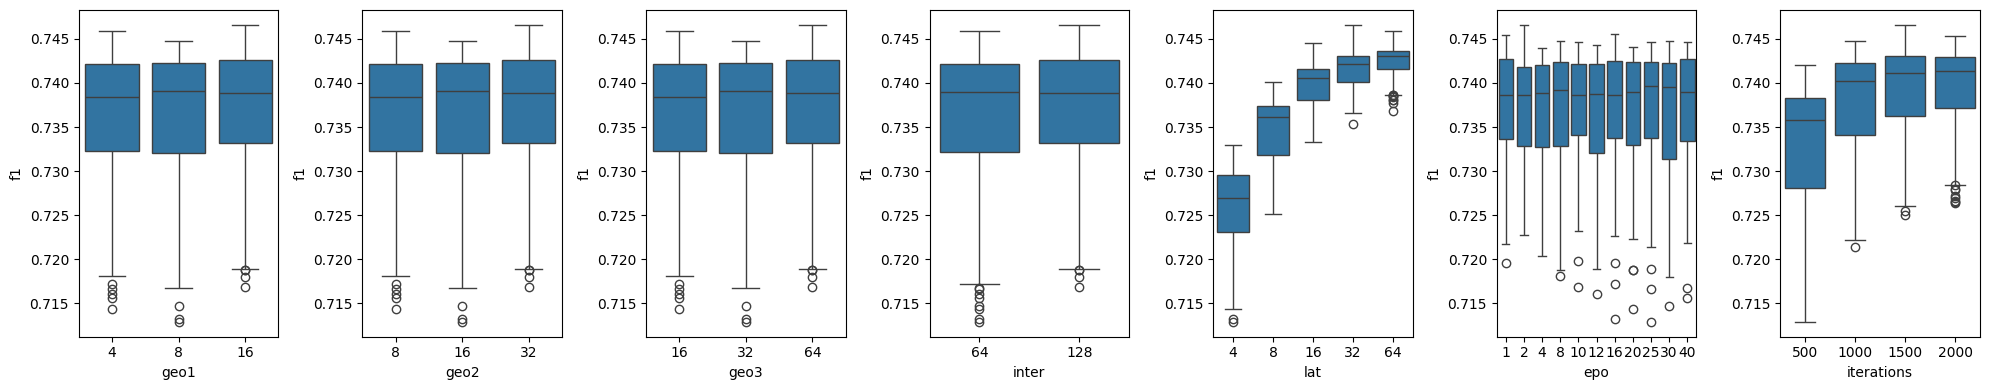

In [13]:
vars = ['geo1', 'geo2', 'geo3', 'inter', 'lat', 'epo','iterations']

fig,axs = plt.subplots(1,7,figsize=(20,4))

df_temp = pd.concat([df_temp500,df_temp1000, df_temp1500,df_temp2000],axis=0)

for i,var in enumerate(vars):
    sns.boxplot(df_temp,x=var,y='f1',ax=axs[i])
    # axs[i].set_title(var)
fig.tight_layout()

### visualize damage distribution

In [15]:
df_train_features = df_train_features_raw.copy()
df_train_labels = df_train_labels_raw.copy()
df_train = pd.concat([df_train_features,df_train_labels],axis=1)
non_geo_features = list(df_train.columns)
non_geo_features.remove('geo_level_1_id')
non_geo_features.remove('geo_level_2_id')
non_geo_features.remove('geo_level_3_id')
non_geo_features.remove('damage_grade')

non_geo_features_cat = list(df_train.columns)
non_geo_features_cat.remove('geo_level_1_id')
non_geo_features_cat.remove('geo_level_2_id')
non_geo_features_cat.remove('geo_level_3_id')
non_geo_features_cat.remove('damage_grade')
non_geo_features_cat.remove('count_floors_pre_eq')
non_geo_features_cat.remove('age')
non_geo_features_cat.remove('area_percentage')
non_geo_features_cat.remove('height_percentage')
non_geo_features_cat.remove('count_families')

non_geo_features_num = numerical_features

In [18]:
len(non_geo_features_cat)

30

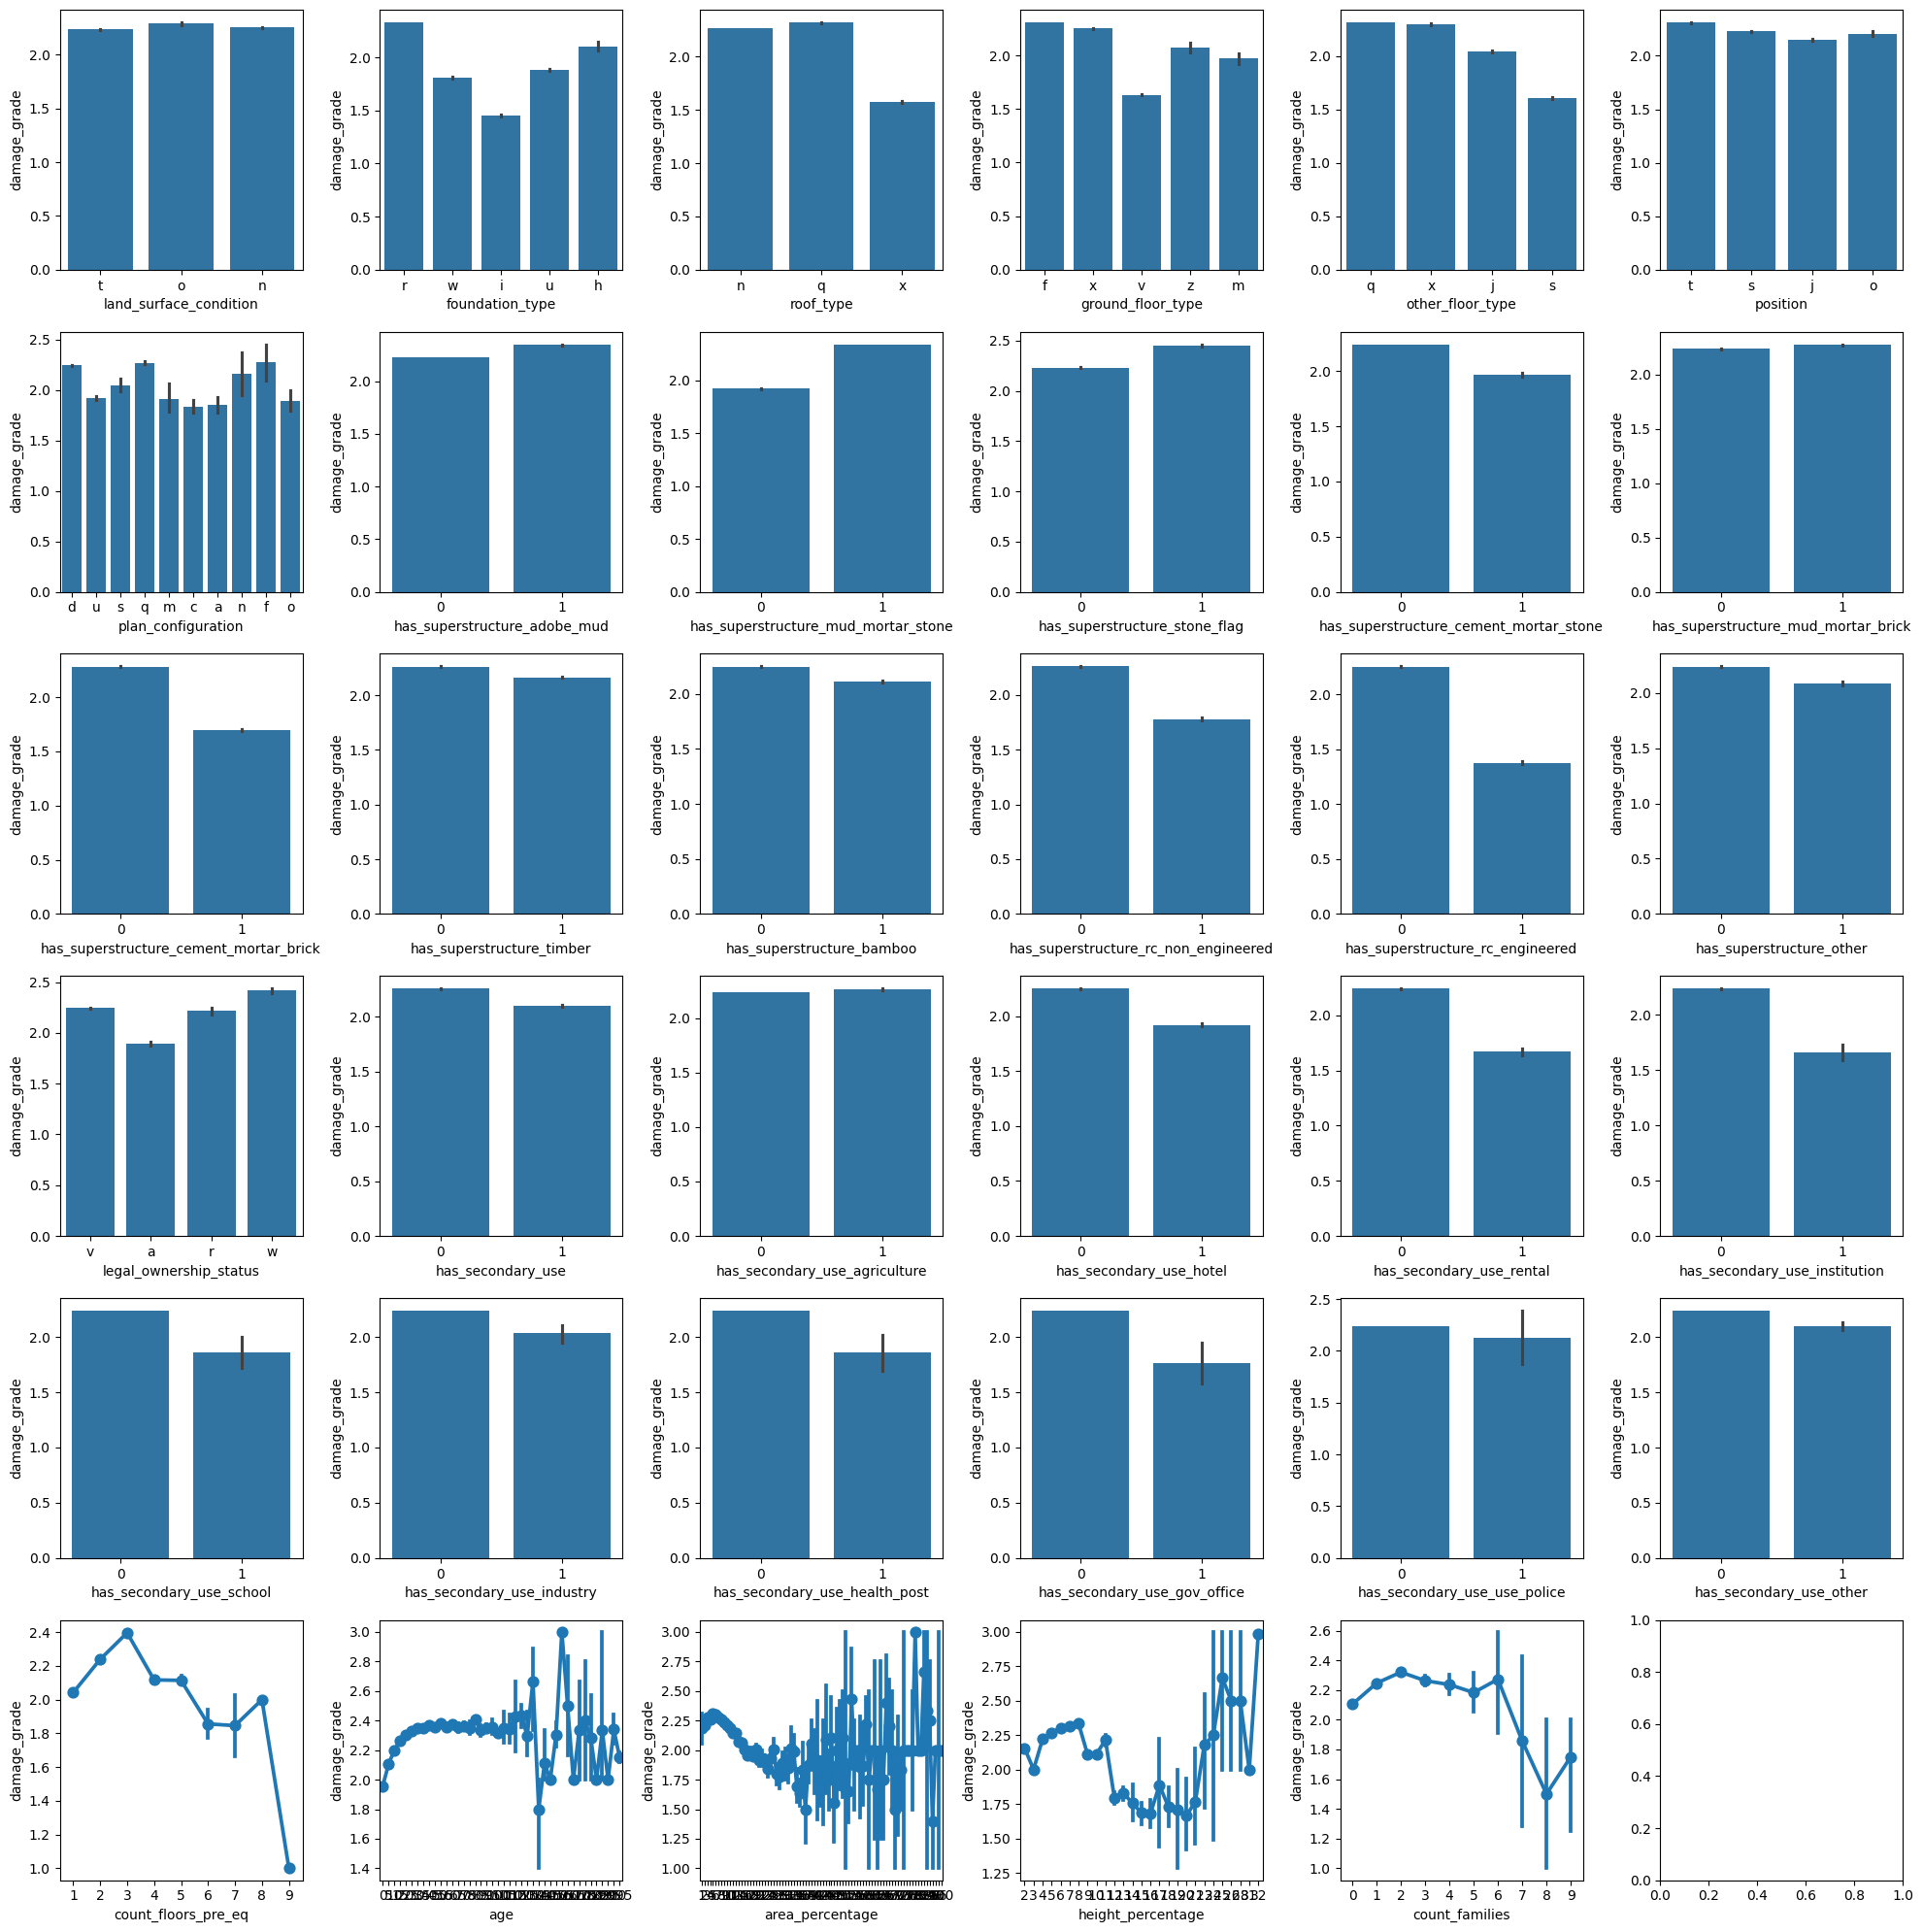

In [21]:
fig,axs = plt.subplots(6,6,figsize=(20,20))
axs = axs.flatten()

for i,feat in enumerate(non_geo_features_cat):
    sns.barplot(df_train,x=feat,y='damage_grade',ax=axs[i])

for i,feat in enumerate(non_geo_features_num):
    sns.pointplot(df_train,x=feat,y='damage_grade',ax=axs[i+30])

fig.tight_layout()

### CatBoost Classifier grid search results (do not delete)

In [9]:
# # Prep data for catboost vanilla
# categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
#                         'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
#                         'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
# geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
# numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# # Split into train, val, test and pred sets
# X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
# df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
# df_pred_X = df_pred_features_raw

# # Get imputed damage grade to prep for geo-encoding
# df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y,df_val_y)

# # Set up architecture
# geo1_size = 16
# geo2_size = 32
# geo3_size = 64
# inter_size = 128
# latent_size = 64
# epochs = 10

# # Get latent geo-encoding
# latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
#                                               geo3_size, inter_size, latent_size, epochs)

# # Apply encoding
# df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
# df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
# df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
# df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

# df_train_X.drop(columns=geo_features, inplace=True)
# df_val_X.drop(columns=geo_features, inplace=True)
# df_test_X.drop(columns=geo_features, inplace=True)
# df_pred_X.drop(columns=geo_features, inplace=True)

# # Get categorical feature indices and names
# categorical_features_indices = []
# for i,dtype in enumerate(df_train_X.dtypes):
#     if dtype in ['int64','int32','object','category']:
#         categorical_features_indices.append(i)

# # Create pooled dataset following catboost requirements
# train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
# val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
# test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
# train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
#                             label=pd.concat([df_train_y,df_val_y],axis=0),
#                             cat_features=categorical_features_indices)
# train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
#                             label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
#                             cat_features=categorical_features_indices)

# # Instantiate catboost classifier model
# model = cb.CatBoostClassifier(
#     objective='MultiClass',  # Use 'MultiClass' for classification
#     task_type='GPU',  # Specify GPU if available
#     devices='0',  # Specify GPU device(s) if multiple
#     metric_period=500,  # Period to print metrics
#     iterations=1500,  # Number of boosting iterations
#     learning_rate=0.1,  # Learning rate
#     depth=8,  # Depth of the trees
#     l2_leaf_reg=5,  # L2 regularization coefficient
#     custom_metric=['Accuracy']  # Additional metrics to track
# )

# model.fit(train_val_dataset)

# # Evaluation
# pred = model.predict(df_test_X)
# acc = accuracy_score(df_test_y, pred)
# f1 = f1_score(df_test_y,pred,average='micro')

# print('Testing performance')
# print(f'Accuracy: {acc:.4f}')
# print(f'F1-score: {f1:.4f}')


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 350.21it/s]


Epoch [1/10], Loss: 6.600163797610638


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 356.63it/s]


Epoch [2/10], Loss: 0.48374449144033865


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 339.94it/s]


Epoch [3/10], Loss: 0.24243559833445938


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 475.17it/s]


Epoch [4/10], Loss: 0.18700860827387653


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 512.45it/s]


Epoch [5/10], Loss: 0.12352636000155218


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 501.03it/s]


Epoch [6/10], Loss: 0.11061015912651911


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 509.37it/s]


Epoch [7/10], Loss: 0.0813532055097403


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 503.47it/s]


Epoch [8/10], Loss: 0.07352680682960078


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 497.63it/s]


Epoch [9/10], Loss: 0.07798671771224248


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 517.50it/s]


Epoch [10/10], Loss: 0.06362848119729299


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1282.81it/s]


0:	learn: 1.0493145	total: 36.9ms	remaining: 55.3s
500:	learn: 0.5439285	total: 4.36s	remaining: 8.69s
1000:	learn: 0.5010738	total: 8.92s	remaining: 4.45s
1499:	learn: 0.4702863	total: 13.7s	remaining: 0us
Testing performance
Accuracy: 0.7537
F1-score: 0.7537


#### Param

In [35]:
# # Prep data for catboost vanilla
# categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
#                         'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
#                         'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
# geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
# numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# # Split into train, val, test and pred sets
# X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
# df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
# df_pred_X = df_pred_features_raw

# # Get imputed damage grade to prep for geo-encoding
# df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y)

# # Set up architecture
# geo1_size = 16
# geo2_size = 32
# geo3_size = 64
# inter_size = 128
# latent_size = 64
# epochs = 10

# # Get latent geo-encoding
# latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
#                                               geo3_size, inter_size, latent_size, epochs)

# # Apply encoding
# df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
# df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
# df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
# df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

# df_train_X.drop(columns=geo_features, inplace=True)
# df_val_X.drop(columns=geo_features, inplace=True)
# df_test_X.drop(columns=geo_features, inplace=True)
# df_pred_X.drop(columns=geo_features, inplace=True)

# # Get categorical feature indices and names
# categorical_features_indices = []
# for i,dtype in enumerate(df_train_X.dtypes):
#     if dtype in ['int64','int32','object','category']:
#         categorical_features_indices.append(i)

# # Create pooled dataset following catboost requirements
# train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
# val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
# test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
# train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
#                             label=pd.concat([df_train_y,df_val_y],axis=0),
#                             cat_features=categorical_features_indices)
# train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
#                             label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
#                             cat_features=categorical_features_indices)


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 502.43it/s]


Epoch [1/10], Loss: 6.786274392536357


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 505.49it/s]


Epoch [2/10], Loss: 0.4703299480165315


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 495.74it/s]


Epoch [3/10], Loss: 0.23153731363533347


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 490.74it/s]


Epoch [4/10], Loss: 0.15849117157687276


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 496.91it/s]


Epoch [5/10], Loss: 0.11779477193180762


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 446.91it/s]


Epoch [6/10], Loss: 0.10143693586892348


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 498.09it/s]


Epoch [7/10], Loss: 0.08769061563252602


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 392.84it/s]


Epoch [8/10], Loss: 0.07612350705578315


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 383.18it/s]


Epoch [9/10], Loss: 0.07711526649230502


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 358.76it/s]


Epoch [10/10], Loss: 0.0554945030653337


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1166.72it/s]


In [38]:
# counter = 0
# preds = []
# accs = []
# f1s = []
# iters = []
# learning_rates = []
# l2_leaf_regs = []
# depths = []

# for iterations in [1000,1250,1500,1750]:
#     for learning_rate in [0.05,0.1,0.15,0.2]:
#         for l2_leaf_reg in [0.1, 1, 5, 10,]:
#             for depth in [7,8,9]:
#                 counter += 1
#                 iters.append(iterations)
#                 learning_rates.append(learning_rate)
#                 l2_leaf_regs.append(l2_leaf_reg)
#                 depths.append(depth)

#                 print(f'\n\n Now running run {counter} of 192')
#                 # Instantiate catboost classifier model
#                 model = cb.CatBoostClassifier(
#                     objective='MultiClass',  # Use 'MultiClass' for classification
#                     task_type='GPU',  # Specify GPU if available
#                     devices='0',  # Specify GPU device(s) if multiple
#                     metric_period=500,  # Period to print metrics
#                     iterations=iterations,  # Number of boosting iterations
#                     learning_rate=learning_rate,  # Learning rate
#                     depth=depth,  # Depth of the trees
#                     l2_leaf_reg=l2_leaf_reg,  # L2 regularization coefficient
#                     custom_metric=['Accuracy']  # Additional metrics to track
#                 )

#                 model.fit(train_val_dataset)

#                 # Evaluation
#                 pred = model.predict(df_test_X)
#                 preds.append(pred)
#                 accs.append(accuracy_score(df_test_y, pred))
#                 f1s.append(f1_score(df_test_y,pred,average='micro'))



 Now running run 1 of 192
0:	learn: 1.0723174	total: 6.78ms	remaining: 6.78s
500:	learn: 0.6002206	total: 3.17s	remaining: 3.15s
999:	learn: 0.5567680	total: 6.46s	remaining: 0us


 Now running run 2 of 192
0:	learn: 1.0713787	total: 11.3ms	remaining: 11.3s
500:	learn: 0.5715376	total: 4.91s	remaining: 4.89s
999:	learn: 0.5224649	total: 9.76s	remaining: 0us


 Now running run 3 of 192
0:	learn: 1.0705250	total: 18.2ms	remaining: 18.2s
500:	learn: 0.5388607	total: 7.52s	remaining: 7.49s
999:	learn: 0.4802956	total: 15s	remaining: 0us


 Now running run 4 of 192
0:	learn: 1.0723619	total: 8.08ms	remaining: 8.07s
500:	learn: 0.6031583	total: 3.53s	remaining: 3.52s
999:	learn: 0.5607198	total: 6.95s	remaining: 0us


 Now running run 5 of 192
0:	learn: 1.0714640	total: 10.8ms	remaining: 10.8s
500:	learn: 0.5758937	total: 4.92s	remaining: 4.9s
999:	learn: 0.5314251	total: 9.71s	remaining: 0us


 Now running run 6 of 192
0:	learn: 1.0706801	total: 15.8ms	remaining: 15.8s
500:	learn: 0.54767

In [46]:
# catboost_classifier_results = pd.DataFrame({'iterations':iters,'learning_rate':learning_rates,'l2_leaf_reg':l2_leaf_regs,'depth':depths,'accuracy':accs,'f1-score':f1s})
# catboost_classifier_results

,iterations,learning_rate,l2_leaf_reg,depth,accuracy,f1-score
0,1000,0.05,0.1,7,0.746489,0.746489
1,1000,0.05,0.1,8,0.750684,0.750684
2,1000,0.05,0.1,9,0.752628,0.752628
3,1000,0.05,1.0,7,0.745824,0.745824
4,1000,0.05,1.0,8,0.750045,0.750045
...,...,...,...,...,...,...
187,1750,0.20,5.0,8,0.752142,0.752142
188,1750,0.20,5.0,9,0.747947,0.747947
189,1750,0.20,10.0,7,0.751989,0.751989
190,1750,0.20,10.0,8,0.751784,0.751784


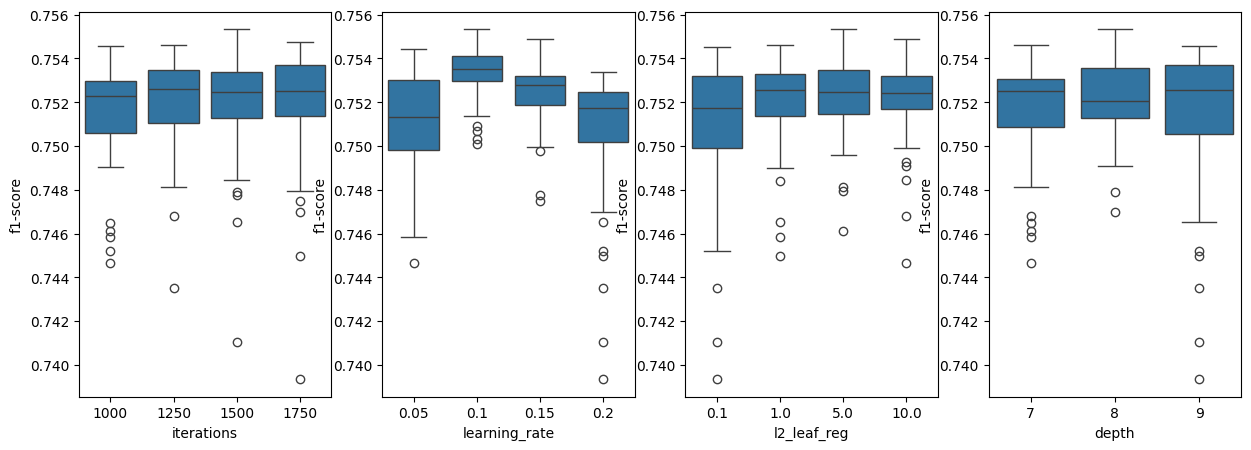

In [48]:
# fig, axs = plt.subplots(1,4,figsize=(15,5))

# for i,param in enumerate(['iterations','learning_rate','l2_leaf_reg','depth']):
#     sns.boxplot(catboost_classifier_results,x=param,y='f1-score',ax=axs[i])

<Axes: xlabel='learning_rate', ylabel='f1-score'>

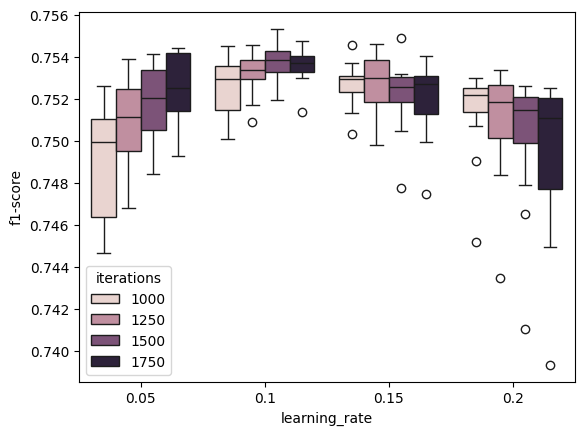

In [55]:
# sns.boxplot(catboost_classifier_results,x='learning_rate',y='f1-score',hue='iterations')

<Axes: xlabel='learning_rate', ylabel='f1-score'>

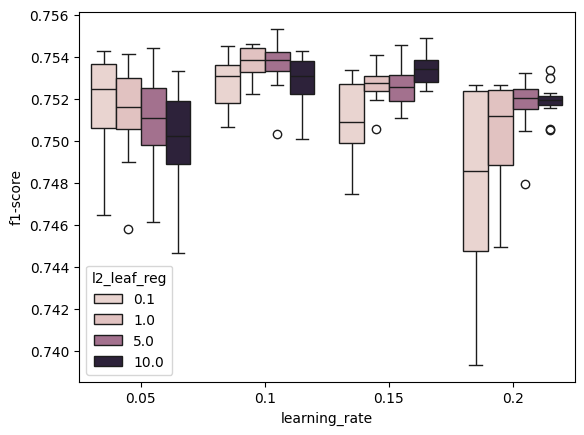

In [56]:
# sns.boxplot(catboost_classifier_results,x='learning_rate',y='f1-score',hue='l2_leaf_reg')

<Axes: xlabel='learning_rate', ylabel='f1-score'>

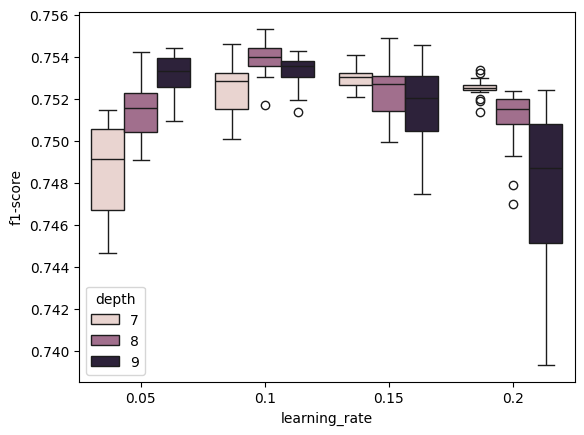

In [57]:
# sns.boxplot(catboost_classifier_results,x='learning_rate',y='f1-score',hue='depth')

In [53]:
# catboost_classifier_results.sort_values(by='f1-score',ascending=False).head(30)

,iterations,learning_rate,l2_leaf_reg,depth,accuracy,f1-score
115,1500,0.10,5.0,8,0.755340,0.755340
130,1500,0.15,10.0,8,0.754905,0.754905
163,1750,0.10,5.0,8,0.754752,0.754752
159,1750,0.10,1.0,7,0.754624,0.754624
82,1250,0.15,10.0,8,0.754598,0.754598
64,1250,0.10,1.0,8,0.754573,0.754573
32,1000,0.15,5.0,9,0.754547,0.754547
13,1000,0.10,0.1,8,0.754522,0.754522
111,1500,0.10,1.0,7,0.754445,0.754445
112,1500,0.10,1.0,8,0.754419,0.754419


### CatBoost Regressor vs Classifier and false pos and neg

In [62]:
# pred_reg = model_reg.predict(df_test_X_reg)
# pred_reg = np.round(np.clip(pred_reg,1,3))
# pred_cls = model_cls.predict(df_test_X_cls)

# pred_reg = pd.DataFrame(pred_reg)
# pred_reg['Observed'] = df_test_y_reg.to_numpy()
# pred_reg.rename(columns={0:'Predicted'}, inplace=True)
# pred_reg['Correct'] = pred_reg.apply(lambda row: int(row['Observed']==row['Predicted']),axis=1)

# pred_cls = pd.DataFrame(pred_cls)
# pred_cls['Observed'] = df_test_y_reg.to_numpy()
# pred_cls.rename(columns={0:'Predicted'}, inplace=True)
# pred_cls['Correct'] = pred_cls.apply(lambda row: int(row['Observed']==row['Predicted']),axis=1)

# pred_cls_or = pred_cls.copy()
# pred_reg_or = pred_reg.copy()


df_test_X_cls = df_test_X.copy()
df_test_y_cls = df_test_y.copy()

pred_cls = model_cls.predict(df_test_X_cls)
pred_cls = pd.DataFrame(pred_cls)
pred_cls['Observed'] = df_test_y_cls.to_numpy()
pred_cls.rename(columns={0:'Predicted'}, inplace=True)
pred_cls['Correct'] = pred_cls.apply(lambda row: int(row['Observed']==row['Predicted']),axis=1)
pred_cls_or = pred_cls.copy()


In [63]:
pred_cls = pd.concat([pred_cls_or.copy(),pd.DataFrame(model_cls.predict_proba(df_test_X_cls),columns=['prob_1','prob_2','prob_3'])],axis=1)

Text(0.5, 0, 'Probability')

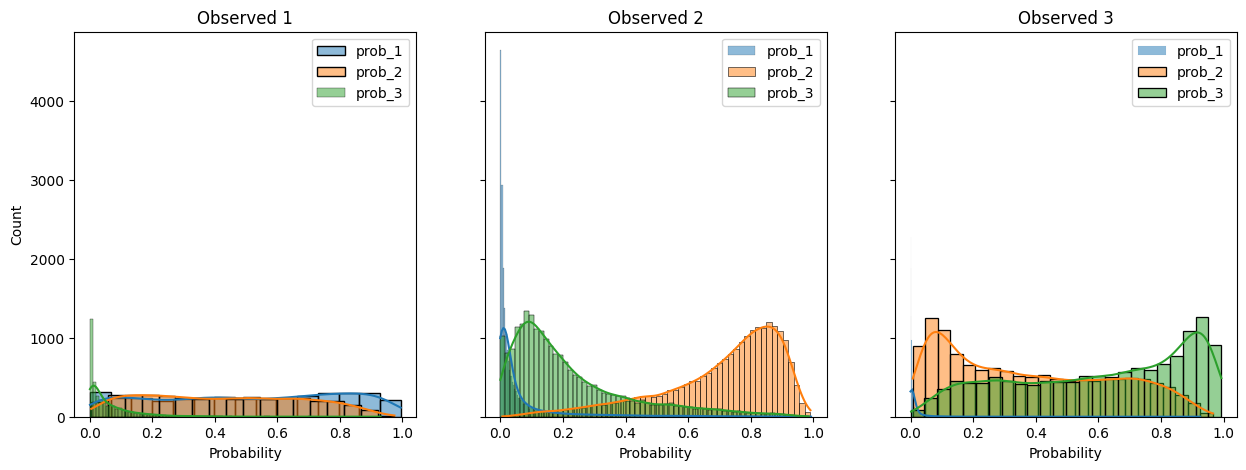

In [85]:
fig, axs = plt.subplots(1,3,figsize=(15,5), sharey=True)
# fig, axs = plt.subplots(1,3,figsize=(15,5))
sns.histplot(pred_cls[pred_cls['Observed']==1]['prob_1'], label='prob_1', kde=True, ax=axs[0])
sns.histplot(pred_cls[pred_cls['Observed']==1]['prob_2'], label='prob_2', kde=True, ax=axs[0])
sns.histplot(pred_cls[pred_cls['Observed']==1]['prob_3'], label='prob_3', kde=True, ax=axs[0])
axs[0].legend()
axs[0].set_title('Observed 1')
axs[0].set_xlabel('Probability')

sns.histplot(pred_cls[pred_cls['Observed']==2]['prob_1'], label='prob_1', kde=True, ax=axs[1])
sns.histplot(pred_cls[pred_cls['Observed']==2]['prob_2'], label='prob_2', kde=True, ax=axs[1])
sns.histplot(pred_cls[pred_cls['Observed']==2]['prob_3'], label='prob_3', kde=True, ax=axs[1])
axs[1].legend()
axs[1].set_title('Observed 2')
axs[1].set_xlabel('Probability')

sns.histplot(pred_cls[pred_cls['Observed']==3]['prob_1'], label='prob_1', kde=True, ax=axs[2])
sns.histplot(pred_cls[pred_cls['Observed']==3]['prob_2'], label='prob_2', kde=True, ax=axs[2])
sns.histplot(pred_cls[pred_cls['Observed']==3]['prob_3'], label='prob_3', kde=True, ax=axs[2])
axs[2].legend()
axs[2].set_title('Observed 3')
axs[2].set_xlabel('Probability')



In [69]:
pred_cls.groupby(['Observed','Predicted']).mean().drop(columns=['Correct'])

prob_1    prob_2    prob_3
Observed Predicted                              
1        1          0.740843  0.234350  0.024807
         2          0.233656  0.667297  0.099047
         3          0.077573  0.299950  0.622477
2        1          0.640350  0.324636  0.035014
         2          0.056307  0.770390  0.173303
         3          0.008083  0.338563  0.653354
3        1          0.633159  0.288415  0.078426
         2          0.033135  0.687514  0.279351
         3          0.005164  0.208570  0.786266

In [70]:
pred_cls.groupby(['Observed','Predicted']).count()[['prob_1']].rename(columns={'prob_1':'Count'})

Count
Observed Predicted       
1        1           2044
         2           1668
         3             57
2        1            837
         2          18921
         3           2481
3        1             78
         2           4536
         3           8469

In [132]:
pred_cls['Predicted'].value_counts()

Predicted
2    25157
3    10967
1     2967
Name: count, dtype: int64

In [133]:
df_train_y.value_counts()

damage_grade
2               107117
3                63014
1                18152
Name: count, dtype: int64

### CatBoost Classifier Geo-encoded Class Imbalance


Looked at first like there were too many predictions for damage grade 2, so i thought reducing class weight for that damage grade might help. results worse after applying.

In [87]:
# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y,df_val_y)

# Set up architecture
geo1_size = 32
geo2_size = 64
geo3_size = 64
inter_size = 128
latent_size = 128
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# Apply encoding
df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

df_train_X.drop(columns=geo_features, inplace=True)
df_val_X.drop(columns=geo_features, inplace=True)
df_test_X.drop(columns=geo_features, inplace=True)
df_pred_X.drop(columns=geo_features, inplace=True)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_X.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y],axis=0),
                            cat_features=categorical_features_indices)
train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                            cat_features=categorical_features_indices)

# Instantiate catboost classifier model
model_cls = cb.CatBoostClassifier(
    objective='MultiClass',  # Use 'MultiClass' for classification
    task_type='GPU',  # Specify GPU if available
    devices='0',  # Specify GPU device(s) if multiple
    metric_period=500,  # Period to print metrics
    iterations=1500,  # Number of boosting iterations
    learning_rate=0.1,  # Learning rate
    depth=8,  # Depth of the trees
    l2_leaf_reg=5,  # L2 regularization coefficient
    custom_metric=['Accuracy'],  # Additional metrics to track
    # class_weights=[1,0.9,1],              # Applying class weights directly
    auto_class_weights = 'SqrtBalanced'     # Letting catboost apply class weights. Takes None, Balanced, or SqrtBalanced
)

model_cls.fit(train_val_dataset)

# Evaluation
pred = model_cls.predict(df_test_X)
acc = accuracy_score(df_test_y, pred)
f1 = f1_score(df_test_y,pred,average='micro')

print('Testing performance')
print(f'Accuracy: {acc:.4f}')
print(f'F1-score: {f1:.4f}')

Epoch 1/10: 100%|██████████| 1358/1358 [00:04<00:00, 305.67it/s]


Epoch [1/10], Loss: 5.670066128269562


Epoch 2/10: 100%|██████████| 1358/1358 [00:05<00:00, 264.35it/s]


Epoch [2/10], Loss: 0.4480889922005175


Epoch 3/10: 100%|██████████| 1358/1358 [00:04<00:00, 273.69it/s]


Epoch [3/10], Loss: 0.2377047146394827


Epoch 4/10: 100%|██████████| 1358/1358 [00:05<00:00, 261.45it/s]


Epoch [4/10], Loss: 0.17438089455421657


Epoch 5/10: 100%|██████████| 1358/1358 [00:04<00:00, 273.58it/s]


Epoch [5/10], Loss: 0.14448054942037686


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 337.67it/s]


Epoch [6/10], Loss: 0.10837726033737112


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 376.09it/s]


Epoch [7/10], Loss: 0.09806993570170518


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 341.47it/s]


Epoch [8/10], Loss: 0.08894104251783103


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 354.79it/s]


Epoch [9/10], Loss: 0.07577921242373604


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 374.37it/s]


Epoch [10/10], Loss: 0.0705292359750712


Evaluating: 100%|██████████| 2715/2715 [00:03<00:00, 895.43it/s] 


0:	learn: 1.0566137	total: 13.5ms	remaining: 20.2s
500:	learn: 0.5597947	total: 5.94s	remaining: 11.8s
1000:	learn: 0.5101940	total: 11.9s	remaining: 5.94s
1499:	learn: 0.4736950	total: 18s	remaining: 0us
Testing performance
Accuracy: 0.7461
F1-score: 0.7461


### Check distribution of eval score from multiple runs - latent size check

checking for optimal latent size

In [16]:
accs_128 = []
f1s_128 = []

for i in range(20):
    # Prep data for catboost vanilla
    categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                            'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                            'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
    geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
    numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

    # Split into train, val, test and pred sets
    X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
    df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
    df_pred_X = df_pred_features_raw

    # Get imputed damage grade to prep for geo-encoding
    df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y,df_val_y)

    # Set up architecture
    geo1_size = 32
    geo2_size = 64
    geo3_size = 64
    inter_size = 128
    latent_size = 128
    epochs = 10

    # Get latent geo-encoding
    latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                                geo3_size, inter_size, latent_size, epochs)

    # Apply encoding
    df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
    df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
    df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
    df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

    df_train_X.drop(columns=geo_features, inplace=True)
    df_val_X.drop(columns=geo_features, inplace=True)
    df_test_X.drop(columns=geo_features, inplace=True)
    df_pred_X.drop(columns=geo_features, inplace=True)

    # Get categorical feature indices and names
    categorical_features_indices = []
    for i,dtype in enumerate(df_train_X.dtypes):
        if dtype in ['int64','int32','object','category']:
            categorical_features_indices.append(i)

    # Create pooled dataset following catboost requirements
    train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
    val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
    test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
    train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                                label=pd.concat([df_train_y,df_val_y],axis=0),
                                cat_features=categorical_features_indices)
    train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                                label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                                cat_features=categorical_features_indices)

    # Instantiate catboost classifier model
    model_cls = cb.CatBoostClassifier(
        objective='MultiClass',  # Use 'MultiClass' for classification
        task_type='GPU',  # Specify GPU if available
        devices='0',  # Specify GPU device(s) if multiple
        metric_period=500,  # Period to print metrics
        iterations=1500,  # Number of boosting iterations
        learning_rate=0.1,  # Learning rate
        depth=8,  # Depth of the trees
        l2_leaf_reg=5,  # L2 regularization coefficient
        custom_metric=['Accuracy'],  # Additional metrics to track
        class_weights=[1,1,1],
    )

    model_cls.fit(train_val_dataset)

    # Evaluation
    pred = model_cls.predict(df_test_X)
    acc = accuracy_score(df_test_y, pred)
    f1 = f1_score(df_test_y,pred,average='micro')

    accs_128.append(acc)
    f1s_128.append(f1)

Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 505.53it/s]


Epoch [1/10], Loss: 5.9372975059918


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 511.36it/s]


Epoch [2/10], Loss: 0.45609843494461105


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 496.64it/s]


Epoch [3/10], Loss: 0.22071248383037692


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 487.55it/s]


Epoch [4/10], Loss: 0.1739668364530986


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 490.33it/s]


Epoch [5/10], Loss: 0.12307196492720149


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.41it/s]


Epoch [6/10], Loss: 0.10159663076389756


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 397.69it/s]


Epoch [7/10], Loss: 0.10299048774148062


Epoch 8/10: 100%|██████████| 1358/1358 [00:04<00:00, 330.77it/s]


Epoch [8/10], Loss: 0.08090904862467345


Epoch 9/10: 100%|██████████| 1358/1358 [00:04<00:00, 286.83it/s]


Epoch [9/10], Loss: 0.07362011063905516


Epoch 10/10: 100%|██████████| 1358/1358 [00:04<00:00, 329.61it/s]


Epoch [10/10], Loss: 0.06667449178280181


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1219.16it/s]


0:	learn: 1.0472779	total: 13.7ms	remaining: 20.5s
500:	learn: 0.5387109	total: 5.63s	remaining: 11.2s
1000:	learn: 0.4975482	total: 10.9s	remaining: 5.46s
1499:	learn: 0.4676548	total: 16.1s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 482.12it/s]


Epoch [1/10], Loss: 5.777127456353409


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 454.42it/s]


Epoch [2/10], Loss: 0.39804986837170525


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 412.77it/s]


Epoch [3/10], Loss: 0.2175501848383092


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 340.70it/s]


Epoch [4/10], Loss: 0.15383716704960315


Epoch 5/10: 100%|██████████| 1358/1358 [00:04<00:00, 307.34it/s]


Epoch [5/10], Loss: 0.12417108377058399


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 321.05it/s]


Epoch [6/10], Loss: 0.10907395432901394


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 374.32it/s]


Epoch [7/10], Loss: 0.09644818346157384


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 451.44it/s]


Epoch [8/10], Loss: 0.07551867753311522


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 407.35it/s]


Epoch [9/10], Loss: 0.08457573607013785


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 371.09it/s]


Epoch [10/10], Loss: 0.0590642569227766


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1367.53it/s]


0:	learn: 1.0474440	total: 12.7ms	remaining: 19s
500:	learn: 0.5385059	total: 5.25s	remaining: 10.5s
1000:	learn: 0.4971132	total: 10.4s	remaining: 5.16s
1499:	learn: 0.4666955	total: 15.6s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:04<00:00, 305.77it/s]


Epoch [1/10], Loss: 5.748394175420278


Epoch 2/10: 100%|██████████| 1358/1358 [00:04<00:00, 312.69it/s]


Epoch [2/10], Loss: 0.41639012016290156


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 386.12it/s]


Epoch [3/10], Loss: 0.1946444532646083


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.69it/s]


Epoch [4/10], Loss: 0.16526440385659122


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 398.06it/s]


Epoch [5/10], Loss: 0.11298084216787643


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 344.41it/s]


Epoch [6/10], Loss: 0.1150774218225015


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 508.01it/s]


Epoch [7/10], Loss: 0.07726152127943672


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 508.74it/s]


Epoch [8/10], Loss: 0.0862234840424154


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 516.29it/s]


Epoch [9/10], Loss: 0.0753229103811169


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 504.09it/s]


Epoch [10/10], Loss: 0.06765159498531555


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1375.75it/s]


0:	learn: 1.0494946	total: 12.8ms	remaining: 19.2s
500:	learn: 0.5395975	total: 5.48s	remaining: 10.9s
1000:	learn: 0.4972162	total: 11s	remaining: 5.49s
1499:	learn: 0.4664425	total: 16.4s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 490.11it/s]


Epoch [1/10], Loss: 5.60647187161428


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 496.08it/s]


Epoch [2/10], Loss: 0.407928674826083


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 505.07it/s]


Epoch [3/10], Loss: 0.20826186849673956


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 511.88it/s]


Epoch [4/10], Loss: 0.154620980354923


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 488.65it/s]


Epoch [5/10], Loss: 0.12478102866693266


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 508.83it/s]


Epoch [6/10], Loss: 0.11691251922699188


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 487.14it/s]


Epoch [7/10], Loss: 0.09915028730272253


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 401.63it/s]


Epoch [8/10], Loss: 0.07601712907260538


Epoch 9/10: 100%|██████████| 1358/1358 [00:04<00:00, 320.16it/s]


Epoch [9/10], Loss: 0.06565193998618278


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 385.96it/s]


Epoch [10/10], Loss: 0.07468007218998113


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1303.68it/s]


0:	learn: 1.0455712	total: 13.2ms	remaining: 19.7s
500:	learn: 0.5395935	total: 5.5s	remaining: 11s
1000:	learn: 0.4976339	total: 10.6s	remaining: 5.3s
1499:	learn: 0.4670677	total: 15.8s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 443.79it/s]


Epoch [1/10], Loss: 5.878411259935601


Epoch 2/10: 100%|██████████| 1358/1358 [00:04<00:00, 318.40it/s]


Epoch [2/10], Loss: 0.4445011835265493


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 357.19it/s]


Epoch [3/10], Loss: 0.21585761602907627


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 442.12it/s]


Epoch [4/10], Loss: 0.15259955618777402


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 443.82it/s]


Epoch [5/10], Loss: 0.12177926773241061


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 421.31it/s]


Epoch [6/10], Loss: 0.10130491235073305


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 492.60it/s]


Epoch [7/10], Loss: 0.08354779334873612


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 496.96it/s]


Epoch [8/10], Loss: 0.08308224741778225


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 496.28it/s]


Epoch [9/10], Loss: 0.07903289552745


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 486.20it/s]


Epoch [10/10], Loss: 0.06454174124875102


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1373.23it/s]


0:	learn: 1.0458448	total: 12ms	remaining: 18s
500:	learn: 0.5373153	total: 5.49s	remaining: 10.9s
1000:	learn: 0.4946252	total: 11.2s	remaining: 5.58s
1499:	learn: 0.4644252	total: 16.7s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 485.11it/s]


Epoch [1/10], Loss: 5.655673431279206


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 503.15it/s]


Epoch [2/10], Loss: 0.4376500557795365


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 491.59it/s]


Epoch [3/10], Loss: 0.23324973317924805


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 507.43it/s]


Epoch [4/10], Loss: 0.17720247003275885


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 503.91it/s]


Epoch [5/10], Loss: 0.13440071414389396


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 506.30it/s]


Epoch [6/10], Loss: 0.09538111016936106


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 498.74it/s]


Epoch [7/10], Loss: 0.09421982183683504


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 388.72it/s]


Epoch [8/10], Loss: 0.090491839761699


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 377.42it/s]


Epoch [9/10], Loss: 0.06716068759416566


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 441.31it/s]


Epoch [10/10], Loss: 0.07442166856300622


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1304.74it/s]


0:	learn: 1.0473275	total: 11.6ms	remaining: 17.4s
500:	learn: 0.5381862	total: 5.11s	remaining: 10.2s
1000:	learn: 0.4966050	total: 9.89s	remaining: 4.93s
1499:	learn: 0.4662706	total: 14.7s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 467.24it/s]


Epoch [1/10], Loss: 5.921266848564324


Epoch 2/10: 100%|██████████| 1358/1358 [00:04<00:00, 335.41it/s]


Epoch [2/10], Loss: 0.4255400270015133


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 377.15it/s]


Epoch [3/10], Loss: 0.23320208750637755


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 460.21it/s]


Epoch [4/10], Loss: 0.16409426376351124


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 469.47it/s]


Epoch [5/10], Loss: 0.12417617668836639


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 391.59it/s]


Epoch [6/10], Loss: 0.10479165018510089


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 495.32it/s]


Epoch [7/10], Loss: 0.08736740761264727


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 489.70it/s]


Epoch [8/10], Loss: 0.07715272756225865


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 496.19it/s]


Epoch [9/10], Loss: 0.07430106610433844


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 501.65it/s]


Epoch [10/10], Loss: 0.07456851262252984


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1371.99it/s]


0:	learn: 1.0472333	total: 12.3ms	remaining: 18.5s
500:	learn: 0.5376945	total: 5.41s	remaining: 10.8s
1000:	learn: 0.4956194	total: 10.8s	remaining: 5.4s
1499:	learn: 0.4652754	total: 16.1s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 370.00it/s]


Epoch [1/10], Loss: 5.795875140137982


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 353.64it/s]


Epoch [2/10], Loss: 0.43114671818857164


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 343.66it/s]


Epoch [3/10], Loss: 0.2320637263478341


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 354.53it/s]


Epoch [4/10], Loss: 0.17661327818430556


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 362.90it/s]


Epoch [5/10], Loss: 0.11967451844277993


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 401.47it/s]


Epoch [6/10], Loss: 0.1152147096722347


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 431.30it/s]


Epoch [7/10], Loss: 0.0868058073902242


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 351.61it/s]


Epoch [8/10], Loss: 0.07244953390720762


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 359.16it/s]


Epoch [9/10], Loss: 0.07751082866159453


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 492.54it/s]


Epoch [10/10], Loss: 0.07916246398452129


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1363.68it/s]


0:	learn: 1.0452810	total: 12.3ms	remaining: 18.5s
500:	learn: 0.5383669	total: 5.32s	remaining: 10.6s
1000:	learn: 0.4966885	total: 10.5s	remaining: 5.24s
1499:	learn: 0.4664466	total: 15.9s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 401.84it/s]


Epoch [1/10], Loss: 5.741664840695784


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 394.53it/s]


Epoch [2/10], Loss: 0.4265342252507301


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 392.18it/s]


Epoch [3/10], Loss: 0.22797502330415204


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 349.86it/s]


Epoch [4/10], Loss: 0.15429005528071865


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 344.01it/s]


Epoch [5/10], Loss: 0.13350225999383517


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 341.14it/s]


Epoch [6/10], Loss: 0.10636817312278868


Epoch 7/10: 100%|██████████| 1358/1358 [00:04<00:00, 337.99it/s]


Epoch [7/10], Loss: 0.08478124531528423


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 347.18it/s]


Epoch [8/10], Loss: 0.08680432761779476


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 439.97it/s]


Epoch [9/10], Loss: 0.08088388119787197


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 359.08it/s]


Epoch [10/10], Loss: 0.07768888874996155


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1137.06it/s]


0:	learn: 1.0474519	total: 15.3ms	remaining: 23s
500:	learn: 0.5381293	total: 5.39s	remaining: 10.7s
1000:	learn: 0.4963128	total: 10.6s	remaining: 5.29s
1499:	learn: 0.4669057	total: 15.8s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 441.56it/s]


Epoch [1/10], Loss: 5.8646714574985195


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 405.31it/s]


Epoch [2/10], Loss: 0.43249571291573446


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 380.62it/s]


Epoch [3/10], Loss: 0.23964553544454179


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 389.12it/s]


Epoch [4/10], Loss: 0.158466478491501


Epoch 5/10: 100%|██████████| 1358/1358 [00:04<00:00, 329.29it/s]


Epoch [5/10], Loss: 0.13248749158759388


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 319.85it/s]


Epoch [6/10], Loss: 0.09393366900377595


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 349.03it/s]


Epoch [7/10], Loss: 0.09837787082989388


Epoch 8/10: 100%|██████████| 1358/1358 [00:04<00:00, 302.97it/s]


Epoch [8/10], Loss: 0.07831078252360082


Epoch 9/10: 100%|██████████| 1358/1358 [00:04<00:00, 323.94it/s]


Epoch [9/10], Loss: 0.07261211546354815


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 397.26it/s]


Epoch [10/10], Loss: 0.07390635867635871


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1268.20it/s]


0:	learn: 1.0451728	total: 14ms	remaining: 21s
500:	learn: 0.5380380	total: 5.69s	remaining: 11.3s
1000:	learn: 0.4961618	total: 10.9s	remaining: 5.43s
1499:	learn: 0.4661504	total: 16.1s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 452.85it/s]


Epoch [1/10], Loss: 5.652291714706196


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 445.97it/s]


Epoch [2/10], Loss: 0.4618491500133267


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 416.87it/s]


Epoch [3/10], Loss: 0.23147480932389425


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 369.46it/s]


Epoch [4/10], Loss: 0.16872884892338724


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 347.51it/s]


Epoch [5/10], Loss: 0.13185944099909186


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 345.14it/s]


Epoch [6/10], Loss: 0.10440948166793956


Epoch 7/10: 100%|██████████| 1358/1358 [00:04<00:00, 318.86it/s]


Epoch [7/10], Loss: 0.09088047330534506


Epoch 8/10: 100%|██████████| 1358/1358 [00:04<00:00, 308.93it/s]


Epoch [8/10], Loss: 0.08035896531586015


Epoch 9/10: 100%|██████████| 1358/1358 [00:04<00:00, 329.46it/s]


Epoch [9/10], Loss: 0.07532997389994983


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 351.84it/s]


Epoch [10/10], Loss: 0.06725118702131122


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1197.56it/s]


0:	learn: 1.0474794	total: 13.9ms	remaining: 20.8s
500:	learn: 0.5387782	total: 5.7s	remaining: 11.4s
1000:	learn: 0.4959982	total: 11.5s	remaining: 5.73s
1499:	learn: 0.4662837	total: 16.8s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 493.04it/s]


Epoch [1/10], Loss: 5.519768541138372


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 494.59it/s]


Epoch [2/10], Loss: 0.41674561753035116


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 456.01it/s]


Epoch [3/10], Loss: 0.22261314248784125


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 453.25it/s]


Epoch [4/10], Loss: 0.15738777230755702


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 450.59it/s]


Epoch [5/10], Loss: 0.12978182722977602


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 413.70it/s]


Epoch [6/10], Loss: 0.1070535611326975


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 387.80it/s]


Epoch [7/10], Loss: 0.0860371739351203


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 355.36it/s]


Epoch [8/10], Loss: 0.08168337278522239


Epoch 9/10: 100%|██████████| 1358/1358 [00:04<00:00, 337.16it/s]


Epoch [9/10], Loss: 0.07570422278493073


Epoch 10/10: 100%|██████████| 1358/1358 [00:04<00:00, 328.50it/s]


Epoch [10/10], Loss: 0.0721460112459448


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1107.15it/s]


0:	learn: 1.0465229	total: 15.1ms	remaining: 22.6s
500:	learn: 0.5378681	total: 5.87s	remaining: 11.7s
1000:	learn: 0.4954580	total: 11.5s	remaining: 5.75s
1499:	learn: 0.4654793	total: 17.1s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 478.11it/s]


Epoch [1/10], Loss: 5.695885934253855


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 513.82it/s]


Epoch [2/10], Loss: 0.4697256266730611


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 516.57it/s]


Epoch [3/10], Loss: 0.2505622620533861


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 491.29it/s]


Epoch [4/10], Loss: 0.1714090992270013


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 498.83it/s]


Epoch [5/10], Loss: 0.13857900740205692


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 486.88it/s]


Epoch [6/10], Loss: 0.12170839108203008


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 476.26it/s]


Epoch [7/10], Loss: 0.10231713562880113


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 428.44it/s]


Epoch [8/10], Loss: 0.08102370223480679


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 439.07it/s]


Epoch [9/10], Loss: 0.08723979846380454


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 408.92it/s]


Epoch [10/10], Loss: 0.073723068132236


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1185.58it/s]


0:	learn: 1.0465686	total: 13.2ms	remaining: 19.8s
500:	learn: 0.5381721	total: 5.83s	remaining: 11.6s
1000:	learn: 0.4964188	total: 11.6s	remaining: 5.77s
1499:	learn: 0.4662614	total: 17.3s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 415.42it/s]


Epoch [1/10], Loss: 5.869798388173022


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 433.87it/s]


Epoch [2/10], Loss: 0.44707540285517083


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 404.09it/s]


Epoch [3/10], Loss: 0.23575767827260039


Epoch 4/10: 100%|██████████| 1358/1358 [00:04<00:00, 335.23it/s]


Epoch [4/10], Loss: 0.1738288428350482


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 438.00it/s]


Epoch [5/10], Loss: 0.13424596567130723


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 493.41it/s]


Epoch [6/10], Loss: 0.11322946068748492


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 497.90it/s]


Epoch [7/10], Loss: 0.09166064872735609


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 513.36it/s]


Epoch [8/10], Loss: 0.09161048779481493


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 514.92it/s]


Epoch [9/10], Loss: 0.08332766612729542


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 507.65it/s]


Epoch [10/10], Loss: 0.05868494531809848


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1373.12it/s]


0:	learn: 1.0476427	total: 12.3ms	remaining: 18.5s
500:	learn: 0.5386999	total: 5.69s	remaining: 11.3s
1000:	learn: 0.4969383	total: 11.4s	remaining: 5.68s
1499:	learn: 0.4673203	total: 17.1s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 434.75it/s]


Epoch [1/10], Loss: 5.958888405596561


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 383.66it/s]


Epoch [2/10], Loss: 0.48044839845929127


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 510.25it/s]


Epoch [3/10], Loss: 0.23800811182230228


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 504.41it/s]


Epoch [4/10], Loss: 0.1668845456531093


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 492.59it/s]


Epoch [5/10], Loss: 0.132967391076041


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 496.99it/s]


Epoch [6/10], Loss: 0.1051278996891006


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 489.34it/s]


Epoch [7/10], Loss: 0.09334669560049996


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 493.31it/s]


Epoch [8/10], Loss: 0.0882390081362637


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 443.46it/s]


Epoch [9/10], Loss: 0.07021051006379128


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 405.62it/s]


Epoch [10/10], Loss: 0.07253951127892937


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1194.85it/s]


0:	learn: 1.0477744	total: 13.2ms	remaining: 19.8s
500:	learn: 0.5375364	total: 5.59s	remaining: 11.1s
1000:	learn: 0.4957727	total: 10.9s	remaining: 5.45s
1499:	learn: 0.4663160	total: 16.1s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 496.67it/s]


Epoch [1/10], Loss: 5.637025071349165


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 494.35it/s]


Epoch [2/10], Loss: 0.44928684302321764


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 503.36it/s]


Epoch [3/10], Loss: 0.2227733812496527


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 499.31it/s]


Epoch [4/10], Loss: 0.16502629874880387


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 502.50it/s]


Epoch [5/10], Loss: 0.13050508913200004


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 506.82it/s]


Epoch [6/10], Loss: 0.11487150823475246


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 449.30it/s]


Epoch [7/10], Loss: 0.09787792238130458


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 405.51it/s]


Epoch [8/10], Loss: 0.08559857295495692


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 357.80it/s]


Epoch [9/10], Loss: 0.07423676027458083


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 364.17it/s]


Epoch [10/10], Loss: 0.07224369659116842


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1104.43it/s]


0:	learn: 1.0469947	total: 11.5ms	remaining: 17.2s
500:	learn: 0.5383040	total: 5.42s	remaining: 10.8s
1000:	learn: 0.4965204	total: 10.8s	remaining: 5.36s
1499:	learn: 0.4657268	total: 16s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 493.71it/s]


Epoch [1/10], Loss: 5.636838070949504


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 509.42it/s]


Epoch [2/10], Loss: 0.44835123403302346


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 481.73it/s]


Epoch [3/10], Loss: 0.2412620046654708


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 427.89it/s]


Epoch [4/10], Loss: 0.15647648674448258


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 358.49it/s]


Epoch [5/10], Loss: 0.14398251069621876


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 322.49it/s]


Epoch [6/10], Loss: 0.10740006057647042


Epoch 7/10: 100%|██████████| 1358/1358 [00:04<00:00, 331.26it/s]


Epoch [7/10], Loss: 0.09148102860766791


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 402.48it/s]


Epoch [8/10], Loss: 0.08712082918754276


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 441.19it/s]


Epoch [9/10], Loss: 0.06856137172738022


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 445.83it/s]


Epoch [10/10], Loss: 0.08536332065422315


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1058.54it/s]


0:	learn: 1.0482959	total: 14.5ms	remaining: 21.8s
500:	learn: 0.5372822	total: 5.25s	remaining: 10.5s
1000:	learn: 0.4950324	total: 10.4s	remaining: 5.2s
1499:	learn: 0.4651253	total: 15.6s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:04<00:00, 338.18it/s]


Epoch [1/10], Loss: 6.033865595162354


Epoch 2/10: 100%|██████████| 1358/1358 [00:04<00:00, 302.54it/s]


Epoch [2/10], Loss: 0.47954843913661716


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 347.25it/s]


Epoch [3/10], Loss: 0.22609555667378722


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 443.35it/s]


Epoch [4/10], Loss: 0.18592278408476418


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 459.09it/s]


Epoch [5/10], Loss: 0.1293917434277707


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.67it/s]


Epoch [6/10], Loss: 0.1185523167174359


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 342.13it/s]


Epoch [7/10], Loss: 0.09294674576353419


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 480.83it/s]


Epoch [8/10], Loss: 0.08653952261029753


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 506.79it/s]


Epoch [9/10], Loss: 0.06833832566190884


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 510.29it/s]


Epoch [10/10], Loss: 0.07018917029613282


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1373.91it/s]


0:	learn: 1.0466041	total: 14.2ms	remaining: 21.4s
500:	learn: 0.5383010	total: 5.28s	remaining: 10.5s
1000:	learn: 0.4971460	total: 10.8s	remaining: 5.38s
1499:	learn: 0.4665385	total: 16.5s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 436.17it/s]


Epoch [1/10], Loss: 5.614770688368926


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 440.22it/s]


Epoch [2/10], Loss: 0.4057402307104555


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 425.13it/s]


Epoch [3/10], Loss: 0.20866788662860336


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 371.34it/s]


Epoch [4/10], Loss: 0.15684558121578024


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 498.76it/s]


Epoch [5/10], Loss: 0.12585294181933634


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 506.01it/s]


Epoch [6/10], Loss: 0.10708613461380706


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 491.21it/s]


Epoch [7/10], Loss: 0.08918858341702442


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 495.82it/s]


Epoch [8/10], Loss: 0.07860062280006293


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 491.12it/s]


Epoch [9/10], Loss: 0.07075024140478882


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 498.84it/s]


Epoch [10/10], Loss: 0.0809847410428883


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1330.62it/s]


0:	learn: 1.0460210	total: 13.8ms	remaining: 20.8s
500:	learn: 0.5383339	total: 5.81s	remaining: 11.6s
1000:	learn: 0.4959170	total: 11.2s	remaining: 5.61s
1499:	learn: 0.4655119	total: 16.7s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 501.65it/s]


Epoch [1/10], Loss: 5.64985960513485


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 500.56it/s]


Epoch [2/10], Loss: 0.4451668076052581


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 505.07it/s]


Epoch [3/10], Loss: 0.21736376097669965


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 506.45it/s]


Epoch [4/10], Loss: 0.16646169812867037


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 507.90it/s]


Epoch [5/10], Loss: 0.12372116421950112


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 422.96it/s]


Epoch [6/10], Loss: 0.09618309683259714


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 367.08it/s]


Epoch [7/10], Loss: 0.09188005292447989


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 394.24it/s]


Epoch [8/10], Loss: 0.08060496060367309


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 447.99it/s]


Epoch [9/10], Loss: 0.07495837336727068


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 475.89it/s]


Epoch [10/10], Loss: 0.06898826427838493


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1270.52it/s]


0:	learn: 1.0449338	total: 12.2ms	remaining: 18.3s
500:	learn: 0.5391044	total: 5.4s	remaining: 10.8s
1000:	learn: 0.4967504	total: 10.6s	remaining: 5.29s
1499:	learn: 0.4663760	total: 15.8s	remaining: 0us


In [17]:
accs_64 = []
f1s_64 = []

for i in range(20):
    # Prep data for catboost vanilla
    categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                            'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                            'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
    geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
    numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

    # Split into train, val, test and pred sets
    X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
    df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
    df_pred_X = df_pred_features_raw

    # Get imputed damage grade to prep for geo-encoding
    df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y,df_val_y)

    # Set up architecture
    geo1_size = 32
    geo2_size = 64
    geo3_size = 64
    inter_size = 128
    latent_size = 64
    epochs = 10

    # Get latent geo-encoding
    latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                                geo3_size, inter_size, latent_size, epochs)

    # Apply encoding
    df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
    df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
    df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
    df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

    df_train_X.drop(columns=geo_features, inplace=True)
    df_val_X.drop(columns=geo_features, inplace=True)
    df_test_X.drop(columns=geo_features, inplace=True)
    df_pred_X.drop(columns=geo_features, inplace=True)

    # Get categorical feature indices and names
    categorical_features_indices = []
    for i,dtype in enumerate(df_train_X.dtypes):
        if dtype in ['int64','int32','object','category']:
            categorical_features_indices.append(i)

    # Create pooled dataset following catboost requirements
    train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
    val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
    test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
    train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                                label=pd.concat([df_train_y,df_val_y],axis=0),
                                cat_features=categorical_features_indices)
    train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                                label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                                cat_features=categorical_features_indices)

    # Instantiate catboost classifier model
    model_cls = cb.CatBoostClassifier(
        objective='MultiClass',  # Use 'MultiClass' for classification
        task_type='GPU',  # Specify GPU if available
        devices='0',  # Specify GPU device(s) if multiple
        metric_period=500,  # Period to print metrics
        iterations=1500,  # Number of boosting iterations
        learning_rate=0.1,  # Learning rate
        depth=8,  # Depth of the trees
        l2_leaf_reg=5,  # L2 regularization coefficient
        custom_metric=['Accuracy'],  # Additional metrics to track
        class_weights=[1,1,1],
    )

    model_cls.fit(train_val_dataset)

    # Evaluation
    pred = model_cls.predict(df_test_X)
    acc = accuracy_score(df_test_y, pred)
    f1 = f1_score(df_test_y,pred,average='micro')

    accs_64.append(acc)
    f1s_64.append(f1)

Epoch 1/10: 100%|██████████| 1358/1358 [00:04<00:00, 334.44it/s]


Epoch [1/10], Loss: 6.229978736221176


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.85it/s]


Epoch [2/10], Loss: 0.5108447767443001


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.17it/s]


Epoch [3/10], Loss: 0.2552126571014853


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 414.76it/s]


Epoch [4/10], Loss: 0.18273178988927768


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 478.30it/s]


Epoch [5/10], Loss: 0.11916120025358096


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 511.23it/s]


Epoch [6/10], Loss: 0.12022848552386434


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 503.33it/s]


Epoch [7/10], Loss: 0.09346871638368123


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 482.72it/s]


Epoch [8/10], Loss: 0.07179899090940108


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 493.98it/s]


Epoch [9/10], Loss: 0.07586792826583776


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 490.15it/s]


Epoch [10/10], Loss: 0.07355997581648693


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1401.90it/s]


0:	learn: 1.0472703	total: 10.7ms	remaining: 16s
500:	learn: 0.5416866	total: 5.04s	remaining: 10s
1000:	learn: 0.4989901	total: 9.83s	remaining: 4.9s
1499:	learn: 0.4683001	total: 14.5s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 500.63it/s]


Epoch [1/10], Loss: 5.9940655557150695


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 513.36it/s]


Epoch [2/10], Loss: 0.478185861647151


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 500.86it/s]


Epoch [3/10], Loss: 0.20913990362737991


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 497.41it/s]


Epoch [4/10], Loss: 0.15658656943284952


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 504.35it/s]


Epoch [5/10], Loss: 0.1259746847328605


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 487.91it/s]


Epoch [6/10], Loss: 0.0977617311188526


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 461.78it/s]


Epoch [7/10], Loss: 0.08325727549369552


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 354.25it/s]


Epoch [8/10], Loss: 0.07732803320808958


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 362.85it/s]


Epoch [9/10], Loss: 0.06605446071446967


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 446.06it/s]


Epoch [10/10], Loss: 0.06935754686224789


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1310.45it/s]


0:	learn: 1.0477983	total: 10.5ms	remaining: 15.7s
500:	learn: 0.5402900	total: 4.83s	remaining: 9.62s
1000:	learn: 0.4987843	total: 9.28s	remaining: 4.63s
1499:	learn: 0.4691296	total: 13.7s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 500.75it/s]


Epoch [1/10], Loss: 6.032063304412348


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 385.58it/s]


Epoch [2/10], Loss: 0.5159594975960535


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 342.16it/s]


Epoch [3/10], Loss: 0.23676401250536205


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 424.02it/s]


Epoch [4/10], Loss: 0.16144164225336202


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 461.86it/s]


Epoch [5/10], Loss: 0.1278592512218641


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 449.74it/s]


Epoch [6/10], Loss: 0.08967635955573067


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 404.31it/s]


Epoch [7/10], Loss: 0.08957015162019062


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 497.24it/s]


Epoch [8/10], Loss: 0.07273576005903074


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 485.50it/s]


Epoch [9/10], Loss: 0.06888056420227334


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 486.61it/s]


Epoch [10/10], Loss: 0.06310503477518192


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1366.61it/s]


0:	learn: 1.0466558	total: 12.6ms	remaining: 18.8s
500:	learn: 0.5410229	total: 4.62s	remaining: 9.21s
1000:	learn: 0.4983038	total: 9.38s	remaining: 4.68s
1499:	learn: 0.4679099	total: 14.2s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 356.23it/s]


Epoch [1/10], Loss: 5.923857013194304


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 351.09it/s]


Epoch [2/10], Loss: 0.5212415315770436


Epoch 3/10: 100%|██████████| 1358/1358 [00:04<00:00, 309.87it/s]


Epoch [3/10], Loss: 0.24926119118336373


Epoch 4/10: 100%|██████████| 1358/1358 [00:04<00:00, 328.51it/s]


Epoch [4/10], Loss: 0.16230537082632354


Epoch 5/10: 100%|██████████| 1358/1358 [00:04<00:00, 304.90it/s]


Epoch [5/10], Loss: 0.13310996998020547


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 314.99it/s]


Epoch [6/10], Loss: 0.10442077740821137


Epoch 7/10: 100%|██████████| 1358/1358 [00:04<00:00, 326.18it/s]


Epoch [7/10], Loss: 0.1050786911875122


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 365.18it/s]


Epoch [8/10], Loss: 0.0663926638947424


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 412.88it/s]


Epoch [9/10], Loss: 0.08240291401102662


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 404.94it/s]


Epoch [10/10], Loss: 0.06154201146316271


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1086.90it/s]


0:	learn: 1.0467913	total: 10.8ms	remaining: 16.2s
500:	learn: 0.5421328	total: 4.51s	remaining: 8.99s
1000:	learn: 0.4996337	total: 8.72s	remaining: 4.35s
1499:	learn: 0.4690591	total: 13s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.01it/s]


Epoch [1/10], Loss: 5.883682755948167


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 442.10it/s]


Epoch [2/10], Loss: 0.4436692816804716


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 454.81it/s]


Epoch [3/10], Loss: 0.24838541973168263


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 410.18it/s]


Epoch [4/10], Loss: 0.15840168827006235


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 396.32it/s]


Epoch [5/10], Loss: 0.12436134279986764


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 391.07it/s]


Epoch [6/10], Loss: 0.10417780328668182


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 381.16it/s]


Epoch [7/10], Loss: 0.09878602399458541


Epoch 8/10: 100%|██████████| 1358/1358 [00:04<00:00, 336.90it/s]


Epoch [8/10], Loss: 0.0782970500558228


Epoch 9/10: 100%|██████████| 1358/1358 [00:04<00:00, 328.94it/s]


Epoch [9/10], Loss: 0.06729368136119679


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 370.89it/s]


Epoch [10/10], Loss: 0.0674655434544526


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1127.31it/s]


0:	learn: 1.0476444	total: 10.8ms	remaining: 16.2s
500:	learn: 0.5436247	total: 5.12s	remaining: 10.2s
1000:	learn: 0.5009221	total: 9.6s	remaining: 4.79s
1499:	learn: 0.4701244	total: 14s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 457.47it/s]


Epoch [1/10], Loss: 5.733007223247955


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 505.61it/s]


Epoch [2/10], Loss: 0.39736392707817686


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 514.40it/s]


Epoch [3/10], Loss: 0.1955417628058497


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 512.17it/s]


Epoch [4/10], Loss: 0.15931248453079513


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 512.68it/s]


Epoch [5/10], Loss: 0.11385406123574368


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 492.28it/s]


Epoch [6/10], Loss: 0.0964714108260941


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 488.40it/s]


Epoch [7/10], Loss: 0.08000440489106767


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 432.44it/s]


Epoch [8/10], Loss: 0.0848840554119657


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 454.81it/s]


Epoch [9/10], Loss: 0.06881134244699932


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 444.86it/s]


Epoch [10/10], Loss: 0.056272122344293254


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1183.77it/s]


0:	learn: 1.0476260	total: 10.2ms	remaining: 15.3s
500:	learn: 0.5402465	total: 4.99s	remaining: 9.96s
1000:	learn: 0.4984154	total: 9.92s	remaining: 4.95s
1499:	learn: 0.4677449	total: 14.9s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:04<00:00, 284.95it/s]


Epoch [1/10], Loss: 5.82186293992624


Epoch 2/10: 100%|██████████| 1358/1358 [00:04<00:00, 323.47it/s]


Epoch [2/10], Loss: 0.44140708132678524


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 355.97it/s]


Epoch [3/10], Loss: 0.22057342092850862


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 407.13it/s]


Epoch [4/10], Loss: 0.15139441065139114


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 353.58it/s]


Epoch [5/10], Loss: 0.11786055705470304


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 310.87it/s]


Epoch [6/10], Loss: 0.10151029844814294


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 498.21it/s]


Epoch [7/10], Loss: 0.08952212231717208


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 496.69it/s]


Epoch [8/10], Loss: 0.07334411977877736


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 512.22it/s]


Epoch [9/10], Loss: 0.06643342309537452


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 508.53it/s]


Epoch [10/10], Loss: 0.07168890375207454


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1298.70it/s]


0:	learn: 1.0473937	total: 9.61ms	remaining: 14.4s
500:	learn: 0.5407593	total: 4.26s	remaining: 8.49s
1000:	learn: 0.4988876	total: 8.61s	remaining: 4.29s
1499:	learn: 0.4680794	total: 13s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:04<00:00, 330.68it/s]


Epoch [1/10], Loss: 5.991407085105843


Epoch 2/10: 100%|██████████| 1358/1358 [00:04<00:00, 314.68it/s]


Epoch [2/10], Loss: 0.446108253132305


Epoch 3/10: 100%|██████████| 1358/1358 [00:04<00:00, 315.94it/s]


Epoch [3/10], Loss: 0.19746264501094862


Epoch 4/10: 100%|██████████| 1358/1358 [00:04<00:00, 317.56it/s]


Epoch [4/10], Loss: 0.1505407516642944


Epoch 5/10: 100%|██████████| 1358/1358 [00:04<00:00, 316.39it/s]


Epoch [5/10], Loss: 0.11938792457584627


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 332.90it/s]


Epoch [6/10], Loss: 0.10423188275518376


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 379.02it/s]


Epoch [7/10], Loss: 0.0861286930647296


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 411.07it/s]


Epoch [8/10], Loss: 0.08742446822216474


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 436.27it/s]


Epoch [9/10], Loss: 0.0589983170986097


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 360.70it/s]


Epoch [10/10], Loss: 0.07704218595243431


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1094.53it/s]


0:	learn: 1.0481783	total: 10.5ms	remaining: 15.8s
500:	learn: 0.5417838	total: 4.22s	remaining: 8.42s
1000:	learn: 0.4997575	total: 8.4s	remaining: 4.19s
1499:	learn: 0.4690247	total: 12.6s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 431.15it/s]


Epoch [1/10], Loss: 5.395717459702


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 424.48it/s]


Epoch [2/10], Loss: 0.3985255849225356


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 393.11it/s]


Epoch [3/10], Loss: 0.22527242782601156


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 376.99it/s]


Epoch [4/10], Loss: 0.15560461399975248


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 387.66it/s]


Epoch [5/10], Loss: 0.12278131315544993


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 330.09it/s]


Epoch [6/10], Loss: 0.10207654217248495


Epoch 7/10: 100%|██████████| 1358/1358 [00:04<00:00, 333.66it/s]


Epoch [7/10], Loss: 0.0828393580844977


Epoch 8/10: 100%|██████████| 1358/1358 [00:04<00:00, 325.89it/s]


Epoch [8/10], Loss: 0.08114076914454862


Epoch 9/10: 100%|██████████| 1358/1358 [00:04<00:00, 316.94it/s]


Epoch [9/10], Loss: 0.07094144682643046


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 339.63it/s]


Epoch [10/10], Loss: 0.05953456730693606


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1173.25it/s]


0:	learn: 1.0450291	total: 10.2ms	remaining: 15.4s
500:	learn: 0.5391453	total: 4.68s	remaining: 9.33s
1000:	learn: 0.4975437	total: 9.06s	remaining: 4.52s
1499:	learn: 0.4668271	total: 13.8s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 514.54it/s]


Epoch [1/10], Loss: 5.991534836930449


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 517.03it/s]


Epoch [2/10], Loss: 0.4135832999543519


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 506.77it/s]


Epoch [3/10], Loss: 0.23147073951008043


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 509.37it/s]


Epoch [4/10], Loss: 0.143291290931058


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 483.81it/s]


Epoch [5/10], Loss: 0.12975943566400103


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 488.72it/s]


Epoch [6/10], Loss: 0.09809805532034065


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 453.47it/s]


Epoch [7/10], Loss: 0.0916704934205934


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 424.17it/s]


Epoch [8/10], Loss: 0.06486410718422866


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 425.52it/s]


Epoch [9/10], Loss: 0.07028909968783179


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 394.16it/s]


Epoch [10/10], Loss: 0.06170921527860489


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1214.73it/s]


0:	learn: 1.0467832	total: 11.7ms	remaining: 17.5s
500:	learn: 0.5410745	total: 4.7s	remaining: 9.37s
1000:	learn: 0.4983310	total: 9.31s	remaining: 4.64s
1499:	learn: 0.4678187	total: 13.9s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:04<00:00, 330.87it/s]


Epoch [1/10], Loss: 5.895391237051041


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 374.30it/s]


Epoch [2/10], Loss: 0.4454655631312302


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 417.42it/s]


Epoch [3/10], Loss: 0.23054084973409772


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 410.32it/s]


Epoch [4/10], Loss: 0.17167781893882642


Epoch 5/10: 100%|██████████| 1358/1358 [00:04<00:00, 310.62it/s]


Epoch [5/10], Loss: 0.1276616449186658


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 352.51it/s]


Epoch [6/10], Loss: 0.10987764651803451


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 493.24it/s]


Epoch [7/10], Loss: 0.0885897056308996


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 498.83it/s]


Epoch [8/10], Loss: 0.08634481605845991


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 483.82it/s]


Epoch [9/10], Loss: 0.06459343025712187


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 491.56it/s]


Epoch [10/10], Loss: 0.07643642329392455


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1365.57it/s]


0:	learn: 1.0467880	total: 9.59ms	remaining: 14.4s
500:	learn: 0.5433775	total: 4.38s	remaining: 8.74s
1000:	learn: 0.5004309	total: 8.76s	remaining: 4.36s
1499:	learn: 0.4697964	total: 13.2s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 383.67it/s]


Epoch [1/10], Loss: 5.888732623237574


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.41it/s]


Epoch [2/10], Loss: 0.4266515382852224


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 467.17it/s]


Epoch [3/10], Loss: 0.22214297068323144


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 473.78it/s]


Epoch [4/10], Loss: 0.146463918322711


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 365.52it/s]


Epoch [5/10], Loss: 0.12461550996278101


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 498.92it/s]


Epoch [6/10], Loss: 0.09551900113241497


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 513.57it/s]


Epoch [7/10], Loss: 0.09822602035163659


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 511.53it/s]


Epoch [8/10], Loss: 0.0785642900691568


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 493.23it/s]


Epoch [9/10], Loss: 0.07470993159235276


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 481.64it/s]


Epoch [10/10], Loss: 0.06367103003292236


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1369.92it/s]


0:	learn: 1.0478604	total: 9.87ms	remaining: 14.8s
500:	learn: 0.5418581	total: 4.44s	remaining: 8.85s
1000:	learn: 0.4994667	total: 8.91s	remaining: 4.44s
1499:	learn: 0.4689007	total: 13.5s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 431.45it/s]


Epoch [1/10], Loss: 5.7961300929050905


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 452.59it/s]


Epoch [2/10], Loss: 0.4150582729195504


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 467.71it/s]


Epoch [3/10], Loss: 0.21710499323251628


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 379.26it/s]


Epoch [4/10], Loss: 0.17401986699331887


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 452.44it/s]


Epoch [5/10], Loss: 0.1132529225599553


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 501.74it/s]


Epoch [6/10], Loss: 0.10514676714191194


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 494.53it/s]


Epoch [7/10], Loss: 0.08093906414037741


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 517.67it/s]


Epoch [8/10], Loss: 0.0827882265380535


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 517.64it/s]


Epoch [9/10], Loss: 0.07156722002464007


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 484.73it/s]


Epoch [10/10], Loss: 0.06408952968998757


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1379.05it/s]


0:	learn: 1.0487114	total: 9.63ms	remaining: 14.4s
500:	learn: 0.5392773	total: 4.42s	remaining: 8.81s
1000:	learn: 0.4975092	total: 8.84s	remaining: 4.41s
1499:	learn: 0.4669329	total: 13.4s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.96it/s]


Epoch [1/10], Loss: 5.952020238860015


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 488.13it/s]


Epoch [2/10], Loss: 0.4563070580264518


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 473.11it/s]


Epoch [3/10], Loss: 0.21305483108899378


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 408.68it/s]


Epoch [4/10], Loss: 0.1548608950296738


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 508.33it/s]


Epoch [5/10], Loss: 0.10541417402666561


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 516.28it/s]


Epoch [6/10], Loss: 0.10102641290610599


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 508.39it/s]


Epoch [7/10], Loss: 0.08222795217714597


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 516.89it/s]


Epoch [8/10], Loss: 0.0737392866319808


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 517.42it/s]


Epoch [9/10], Loss: 0.06358209145843464


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 487.49it/s]


Epoch [10/10], Loss: 0.06258777966096621


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1395.29it/s]


0:	learn: 1.0470195	total: 10.2ms	remaining: 15.2s
500:	learn: 0.5420307	total: 4.51s	remaining: 8.99s
1000:	learn: 0.5001510	total: 9.05s	remaining: 4.51s
1499:	learn: 0.4690493	total: 13.6s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.88it/s]


Epoch [1/10], Loss: 5.895308571641329


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 441.75it/s]


Epoch [2/10], Loss: 0.49080541122029914


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 416.31it/s]


Epoch [3/10], Loss: 0.23041421573318333


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 495.32it/s]


Epoch [4/10], Loss: 0.16463622657255722


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 496.96it/s]


Epoch [5/10], Loss: 0.12472613633161792


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 503.00it/s]


Epoch [6/10], Loss: 0.10443290587808163


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 515.72it/s]


Epoch [7/10], Loss: 0.09423709219196107


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 507.18it/s]


Epoch [8/10], Loss: 0.07605122479557681


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 516.21it/s]


Epoch [9/10], Loss: 0.0777440330461806


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 452.33it/s]


Epoch [10/10], Loss: 0.07057942691308293


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1263.55it/s]


0:	learn: 1.0475165	total: 10.8ms	remaining: 16.3s
500:	learn: 0.5433062	total: 4.68s	remaining: 9.33s
1000:	learn: 0.5013397	total: 9.36s	remaining: 4.67s
1499:	learn: 0.4710453	total: 13.8s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.99it/s]


Epoch [1/10], Loss: 5.91052541485679


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 362.71it/s]


Epoch [2/10], Loss: 0.48287180293247167


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 481.13it/s]


Epoch [3/10], Loss: 0.21676655798952954


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 504.29it/s]


Epoch [4/10], Loss: 0.14897073776939876


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 514.30it/s]


Epoch [5/10], Loss: 0.12963428267446486


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 497.06it/s]


Epoch [6/10], Loss: 0.09935670502042186


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 483.42it/s]


Epoch [7/10], Loss: 0.08596027812105089


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 489.88it/s]


Epoch [8/10], Loss: 0.07570217557490456


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 492.87it/s]


Epoch [9/10], Loss: 0.06369235176014933


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 431.05it/s]


Epoch [10/10], Loss: 0.05937317516949626


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1221.77it/s]


0:	learn: 1.0468473	total: 11.1ms	remaining: 16.6s
500:	learn: 0.5418440	total: 4.68s	remaining: 9.33s
1000:	learn: 0.5005279	total: 9.24s	remaining: 4.61s
1499:	learn: 0.4697173	total: 13.7s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 379.33it/s]


Epoch [1/10], Loss: 5.9319450067841775


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 487.91it/s]


Epoch [2/10], Loss: 0.4764623632585967


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 492.16it/s]


Epoch [3/10], Loss: 0.23539455912853638


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 486.38it/s]


Epoch [4/10], Loss: 0.16502549887747286


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 497.16it/s]


Epoch [5/10], Loss: 0.11687245846154039


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 437.46it/s]


Epoch [6/10], Loss: 0.09445348628234278


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 482.78it/s]


Epoch [7/10], Loss: 0.09284290124196559


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.64it/s]


Epoch [8/10], Loss: 0.07923233027928968


Epoch 9/10: 100%|██████████| 1358/1358 [00:04<00:00, 330.84it/s]


Epoch [9/10], Loss: 0.06963752403614264


Epoch 10/10: 100%|██████████| 1358/1358 [00:04<00:00, 339.32it/s]


Epoch [10/10], Loss: 0.06441563413683232


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1281.55it/s]


0:	learn: 1.0472849	total: 9.86ms	remaining: 14.8s
500:	learn: 0.5401317	total: 4.4s	remaining: 8.77s
1000:	learn: 0.4977293	total: 8.8s	remaining: 4.39s
1499:	learn: 0.4673882	total: 13s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 488.91it/s]


Epoch [1/10], Loss: 6.165372180175009


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 502.61it/s]


Epoch [2/10], Loss: 0.5100693761676945


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 451.82it/s]


Epoch [3/10], Loss: 0.22392289883927585


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 409.16it/s]


Epoch [4/10], Loss: 0.1540998351404962


Epoch 5/10: 100%|██████████| 1358/1358 [00:04<00:00, 298.20it/s]


Epoch [5/10], Loss: 0.11837042392326165


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 416.07it/s]


Epoch [6/10], Loss: 0.10288456666358062


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 498.88it/s]


Epoch [7/10], Loss: 0.09870483188678007


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 476.59it/s]


Epoch [8/10], Loss: 0.07490849912374738


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 399.73it/s]


Epoch [9/10], Loss: 0.06990918674127683


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 460.24it/s]


Epoch [10/10], Loss: 0.05655051039201612


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1404.21it/s]


0:	learn: 1.0490759	total: 9.51ms	remaining: 14.2s
500:	learn: 0.5431016	total: 4.2s	remaining: 8.38s
1000:	learn: 0.4997849	total: 8.32s	remaining: 4.15s
1499:	learn: 0.4692651	total: 12.7s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 355.26it/s]


Epoch [1/10], Loss: 5.981309453500037


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 432.15it/s]


Epoch [2/10], Loss: 0.4678770617111442


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 467.82it/s]


Epoch [3/10], Loss: 0.221987337934262


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 449.12it/s]


Epoch [4/10], Loss: 0.1736081182464288


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 426.21it/s]


Epoch [5/10], Loss: 0.11586661072960878


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 500.24it/s]


Epoch [6/10], Loss: 0.0982742742546155


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 511.84it/s]


Epoch [7/10], Loss: 0.09239756020930608


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.62it/s]


Epoch [8/10], Loss: 0.0767802946194588


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 496.29it/s]


Epoch [9/10], Loss: 0.06975143553704724


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 487.12it/s]


Epoch [10/10], Loss: 0.06099534178921553


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1350.57it/s]


0:	learn: 1.0467452	total: 10.8ms	remaining: 16.2s
500:	learn: 0.5399171	total: 4.8s	remaining: 9.58s
1000:	learn: 0.4972139	total: 9.49s	remaining: 4.73s
1499:	learn: 0.4671524	total: 13.8s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 473.53it/s]


Epoch [1/10], Loss: 5.840173592118873


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 508.01it/s]


Epoch [2/10], Loss: 0.4518034158710703


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 516.68it/s]


Epoch [3/10], Loss: 0.22283671290472434


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 492.10it/s]


Epoch [4/10], Loss: 0.16762454210971214


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 487.57it/s]


Epoch [5/10], Loss: 0.13718121616027162


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 479.48it/s]


Epoch [6/10], Loss: 0.10206540686349948


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 482.21it/s]


Epoch [7/10], Loss: 0.08563334499989857


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 434.65it/s]


Epoch [8/10], Loss: 0.08137688597280872


Epoch 9/10: 100%|██████████| 1358/1358 [00:04<00:00, 315.03it/s]


Epoch [9/10], Loss: 0.07379097406574442


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 396.53it/s]


Epoch [10/10], Loss: 0.07071197878034695


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1262.80it/s]


0:	learn: 1.0471952	total: 9.81ms	remaining: 14.7s
500:	learn: 0.5410356	total: 4.85s	remaining: 9.66s
1000:	learn: 0.4981054	total: 9.65s	remaining: 4.81s
1499:	learn: 0.4675006	total: 14.2s	remaining: 0us


In [23]:
accs_128_dropout = []
f1s_128_dropout = []

for i in range(20):
    # Prep data for catboost vanilla
    categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                            'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                            'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
    geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
    numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

    # Split into train, val, test and pred sets
    X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
    df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
    df_pred_X = df_pred_features_raw

    # Get imputed damage grade to prep for geo-encoding
    df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y,df_val_y)

    # Set up architecture
    geo1_size = 32
    geo2_size = 64
    geo3_size = 64
    inter_size = 128
    latent_size = 128
    epochs = 10

    # Get latent geo-encoding
    latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                                geo3_size, inter_size, latent_size, epochs)

    # Apply encoding
    df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
    df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
    df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
    df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

    df_train_X.drop(columns=geo_features, inplace=True)
    df_val_X.drop(columns=geo_features, inplace=True)
    df_test_X.drop(columns=geo_features, inplace=True)
    df_pred_X.drop(columns=geo_features, inplace=True)

    # Get categorical feature indices and names
    categorical_features_indices = []
    for i,dtype in enumerate(df_train_X.dtypes):
        if dtype in ['int64','int32','object','category']:
            categorical_features_indices.append(i)

    # Create pooled dataset following catboost requirements
    train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
    val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
    test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
    train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                                label=pd.concat([df_train_y,df_val_y],axis=0),
                                cat_features=categorical_features_indices)
    train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                                label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                                cat_features=categorical_features_indices)

    # Instantiate catboost classifier model
    model_cls = cb.CatBoostClassifier(
        objective='MultiClass',  # Use 'MultiClass' for classification
        task_type='GPU',  # Specify GPU if available
        devices='0',  # Specify GPU device(s) if multiple
        metric_period=500,  # Period to print metrics
        iterations=1500,  # Number of boosting iterations
        learning_rate=0.1,  # Learning rate
        depth=8,  # Depth of the trees
        l2_leaf_reg=5,  # L2 regularization coefficient
        custom_metric=['Accuracy'],  # Additional metrics to track
        class_weights=[1,1,1],
    )

    model_cls.fit(train_val_dataset)

    # Evaluation
    pred = model_cls.predict(df_test_X)
    acc = accuracy_score(df_test_y, pred)
    f1 = f1_score(df_test_y,pred,average='micro')

    accs_128_dropout.append(acc)
    f1s_128_dropout.append(f1)

Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 456.12it/s]


Epoch [1/10], Loss: 14.398113415062165


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 419.46it/s]


Epoch [2/10], Loss: 10.466058666470827


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 415.00it/s]


Epoch [3/10], Loss: 9.20715002950407


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 377.66it/s]


Epoch [4/10], Loss: 8.390807340703411


Epoch 5/10: 100%|██████████| 1358/1358 [00:04<00:00, 333.99it/s]


Epoch [5/10], Loss: 7.8039926404629965


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 326.50it/s]


Epoch [6/10], Loss: 7.350934826046097


Epoch 7/10: 100%|██████████| 1358/1358 [00:04<00:00, 289.01it/s]


Epoch [7/10], Loss: 7.0125211781008785


Epoch 8/10: 100%|██████████| 1358/1358 [00:04<00:00, 295.25it/s]


Epoch [8/10], Loss: 6.748502556810674


Epoch 9/10: 100%|██████████| 1358/1358 [00:04<00:00, 294.45it/s]


Epoch [9/10], Loss: 6.554171013375621


Epoch 10/10: 100%|██████████| 1358/1358 [00:04<00:00, 278.02it/s]


Epoch [10/10], Loss: 6.336057107473157


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1046.89it/s]


0:	learn: 1.0401268	total: 13.5ms	remaining: 20.3s
500:	learn: 0.5474421	total: 5.54s	remaining: 11s
1000:	learn: 0.5092391	total: 10.8s	remaining: 5.37s
1499:	learn: 0.4807319	total: 15.8s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 364.58it/s]


Epoch [1/10], Loss: 14.563889643931775


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 482.59it/s]


Epoch [2/10], Loss: 10.501135763609357


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.22it/s]


Epoch [3/10], Loss: 9.244175566138153


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 478.29it/s]


Epoch [4/10], Loss: 8.40892454661396


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.53it/s]


Epoch [5/10], Loss: 7.865982323928855


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.29it/s]


Epoch [6/10], Loss: 7.464526433130076


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.32it/s]


Epoch [7/10], Loss: 7.1647157865701265


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 417.45it/s]


Epoch [8/10], Loss: 6.881750463912694


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 398.13it/s]


Epoch [9/10], Loss: 6.665219641574528


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 388.68it/s]


Epoch [10/10], Loss: 6.496457566568883


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1127.07it/s]


0:	learn: 1.0388844	total: 13ms	remaining: 19.5s
500:	learn: 0.5475140	total: 5.17s	remaining: 10.3s
1000:	learn: 0.5085855	total: 10.3s	remaining: 5.15s
1499:	learn: 0.4810764	total: 15.5s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:04<00:00, 328.64it/s]


Epoch [1/10], Loss: 15.030896559028458


Epoch 2/10: 100%|██████████| 1358/1358 [00:04<00:00, 331.99it/s]


Epoch [2/10], Loss: 10.834736245370227


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 385.00it/s]


Epoch [3/10], Loss: 9.708805604606033


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 391.91it/s]


Epoch [4/10], Loss: 9.027025349185815


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 421.05it/s]


Epoch [5/10], Loss: 8.54770540453724


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 329.42it/s]


Epoch [6/10], Loss: 8.162202235349675


Epoch 7/10: 100%|██████████| 1358/1358 [00:04<00:00, 299.80it/s]


Epoch [7/10], Loss: 7.850203906664617


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 420.97it/s]


Epoch [8/10], Loss: 7.604187640244901


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 474.83it/s]


Epoch [9/10], Loss: 7.3635039884317255


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 473.42it/s]


Epoch [10/10], Loss: 7.164929593610132


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1397.37it/s]


0:	learn: 1.0395483	total: 12ms	remaining: 18s
500:	learn: 0.5471632	total: 4.79s	remaining: 9.54s
1000:	learn: 0.5093499	total: 9.6s	remaining: 4.79s
1499:	learn: 0.4812187	total: 14.7s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:04<00:00, 331.34it/s]


Epoch [1/10], Loss: 15.117600486626154


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 409.58it/s]


Epoch [2/10], Loss: 11.068572991024237


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 434.33it/s]


Epoch [3/10], Loss: 9.815147025595708


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 434.70it/s]


Epoch [4/10], Loss: 8.972570827326823


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 363.84it/s]


Epoch [5/10], Loss: 8.379815882540942


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 395.16it/s]


Epoch [6/10], Loss: 7.950839720699327


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 490.82it/s]


Epoch [7/10], Loss: 7.623152155939364


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 489.82it/s]


Epoch [8/10], Loss: 7.335883457987228


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 493.01it/s]


Epoch [9/10], Loss: 7.113062729716125


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.26it/s]


Epoch [10/10], Loss: 6.908820602784979


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1289.75it/s]


0:	learn: 1.0397679	total: 14.4ms	remaining: 21.6s
500:	learn: 0.5475051	total: 5.57s	remaining: 11.1s
1000:	learn: 0.5099413	total: 11.1s	remaining: 5.53s
1499:	learn: 0.4814011	total: 16.7s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 405.62it/s]


Epoch [1/10], Loss: 15.135775380703416


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 431.06it/s]


Epoch [2/10], Loss: 10.913477123749274


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 409.96it/s]


Epoch [3/10], Loss: 9.66018888279686


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 341.99it/s]


Epoch [4/10], Loss: 8.751958891639653


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 476.76it/s]


Epoch [5/10], Loss: 8.05082555898686


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 476.79it/s]


Epoch [6/10], Loss: 7.541883481619811


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.59it/s]


Epoch [7/10], Loss: 7.163489839992046


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.16it/s]


Epoch [8/10], Loss: 6.8568069467839505


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 480.40it/s]


Epoch [9/10], Loss: 6.606939479423377


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 477.53it/s]


Epoch [10/10], Loss: 6.403999794916482


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1278.26it/s]


0:	learn: 1.0397713	total: 13.2ms	remaining: 19.8s
500:	learn: 0.5452413	total: 5.51s	remaining: 11s
1000:	learn: 0.5070496	total: 11s	remaining: 5.49s
1499:	learn: 0.4789031	total: 16.6s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 435.90it/s]


Epoch [1/10], Loss: 14.415861816574793


Epoch 2/10: 100%|██████████| 1358/1358 [00:04<00:00, 326.03it/s]


Epoch [2/10], Loss: 10.606547784032808


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 427.14it/s]


Epoch [3/10], Loss: 9.478499312815153


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 481.04it/s]


Epoch [4/10], Loss: 8.784460000682826


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 491.83it/s]


Epoch [5/10], Loss: 8.3030279950295


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 493.55it/s]


Epoch [6/10], Loss: 7.904769950130727


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 480.21it/s]


Epoch [7/10], Loss: 7.573740444408074


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 469.40it/s]


Epoch [8/10], Loss: 7.326687436742881


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 449.99it/s]


Epoch [9/10], Loss: 7.1140333391254185


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 389.39it/s]


Epoch [10/10], Loss: 6.908785457990306


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1082.27it/s]


0:	learn: 1.0400972	total: 13.6ms	remaining: 20.4s
500:	learn: 0.5493728	total: 5.69s	remaining: 11.3s
1000:	learn: 0.5100057	total: 11.2s	remaining: 5.6s
1499:	learn: 0.4816777	total: 16.6s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 422.48it/s]


Epoch [1/10], Loss: 14.490824967666649


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 479.25it/s]


Epoch [2/10], Loss: 10.392311859552217


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.55it/s]


Epoch [3/10], Loss: 9.090513737809149


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 469.35it/s]


Epoch [4/10], Loss: 8.231485330654701


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 488.80it/s]


Epoch [5/10], Loss: 7.648539443079256


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 482.02it/s]


Epoch [6/10], Loss: 7.22034155813338


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.90it/s]


Epoch [7/10], Loss: 6.92489018004843


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 405.70it/s]


Epoch [8/10], Loss: 6.685048319980919


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 354.62it/s]


Epoch [9/10], Loss: 6.472074029723043


Epoch 10/10: 100%|██████████| 1358/1358 [00:04<00:00, 307.56it/s]


Epoch [10/10], Loss: 6.297641644246097


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1113.85it/s]


0:	learn: 1.0422145	total: 13.3ms	remaining: 19.9s
500:	learn: 0.5473955	total: 5.52s	remaining: 11s
1000:	learn: 0.5093891	total: 10.7s	remaining: 5.35s
1499:	learn: 0.4809025	total: 16.1s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 487.06it/s]


Epoch [1/10], Loss: 14.395624336332565


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 492.38it/s]


Epoch [2/10], Loss: 10.39494132012436


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 476.92it/s]


Epoch [3/10], Loss: 9.040159815365506


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 480.68it/s]


Epoch [4/10], Loss: 8.151494653656837


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 477.75it/s]


Epoch [5/10], Loss: 7.551090397434487


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 433.32it/s]


Epoch [6/10], Loss: 7.1314138878076525


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 359.76it/s]


Epoch [7/10], Loss: 6.781511044116013


Epoch 8/10: 100%|██████████| 1358/1358 [00:04<00:00, 313.47it/s]


Epoch [8/10], Loss: 6.511630081463282


Epoch 9/10: 100%|██████████| 1358/1358 [00:04<00:00, 310.60it/s]


Epoch [9/10], Loss: 6.29397527915213


Epoch 10/10: 100%|██████████| 1358/1358 [00:04<00:00, 331.95it/s]


Epoch [10/10], Loss: 6.099714323066296


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1259.23it/s]


0:	learn: 1.0406804	total: 10.8ms	remaining: 16.2s
500:	learn: 0.5458771	total: 5.26s	remaining: 10.5s
1000:	learn: 0.5087627	total: 10.6s	remaining: 5.31s
1499:	learn: 0.4798123	total: 15.7s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 477.32it/s]


Epoch [1/10], Loss: 14.437277332496924


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 487.52it/s]


Epoch [2/10], Loss: 10.45289098531754


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 447.33it/s]


Epoch [3/10], Loss: 9.183106995471622


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 383.81it/s]


Epoch [4/10], Loss: 8.381586415427071


Epoch 5/10: 100%|██████████| 1358/1358 [00:04<00:00, 325.62it/s]


Epoch [5/10], Loss: 7.823698370727067


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 422.02it/s]


Epoch [6/10], Loss: 7.409700897551074


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 415.63it/s]


Epoch [7/10], Loss: 7.087767060270014


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 435.60it/s]


Epoch [8/10], Loss: 6.8272390646506125


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 397.84it/s]


Epoch [9/10], Loss: 6.600535608005102


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.13it/s]


Epoch [10/10], Loss: 6.392972686329365


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1335.55it/s]


0:	learn: 1.0401126	total: 13.9ms	remaining: 20.8s
500:	learn: 0.5468475	total: 5.15s	remaining: 10.3s
1000:	learn: 0.5090112	total: 10.2s	remaining: 5.08s
1499:	learn: 0.4811970	total: 15.5s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 413.17it/s]


Epoch [1/10], Loss: 14.369498936873647


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 447.29it/s]


Epoch [2/10], Loss: 10.372381836044244


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 431.94it/s]


Epoch [3/10], Loss: 9.079403022603188


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 369.98it/s]


Epoch [4/10], Loss: 8.295735075126165


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.41it/s]


Epoch [5/10], Loss: 7.776837536091306


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 491.55it/s]


Epoch [6/10], Loss: 7.3829172939193795


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 490.75it/s]


Epoch [7/10], Loss: 7.107922739764903


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.97it/s]


Epoch [8/10], Loss: 6.8699351371826936


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.76it/s]


Epoch [9/10], Loss: 6.680368865185879


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 470.20it/s]


Epoch [10/10], Loss: 6.52013909202261


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1316.04it/s]


0:	learn: 1.0409511	total: 12.2ms	remaining: 18.3s
500:	learn: 0.5477652	total: 5.3s	remaining: 10.6s
1000:	learn: 0.5091879	total: 10.3s	remaining: 5.13s
1499:	learn: 0.4809404	total: 15.2s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 466.02it/s]


Epoch [1/10], Loss: 14.554079990499325


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 478.11it/s]


Epoch [2/10], Loss: 10.688894625089306


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 476.37it/s]


Epoch [3/10], Loss: 9.55053266755611


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.79it/s]


Epoch [4/10], Loss: 8.79063812798007


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 475.05it/s]


Epoch [5/10], Loss: 8.210361654172063


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 438.62it/s]


Epoch [6/10], Loss: 7.77398710047198


Epoch 7/10: 100%|██████████| 1358/1358 [00:04<00:00, 319.20it/s]


Epoch [7/10], Loss: 7.425604703324533


Epoch 8/10: 100%|██████████| 1358/1358 [00:04<00:00, 329.89it/s]


Epoch [8/10], Loss: 7.14719308247798


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 420.44it/s]


Epoch [9/10], Loss: 6.935730708365237


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 432.97it/s]


Epoch [10/10], Loss: 6.7493320982656355


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1322.41it/s]


0:	learn: 1.0393801	total: 12ms	remaining: 18.1s
500:	learn: 0.5464022	total: 4.99s	remaining: 9.95s
1000:	learn: 0.5095889	total: 9.7s	remaining: 4.83s
1499:	learn: 0.4810658	total: 14.6s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 400.60it/s]


Epoch [1/10], Loss: 14.761683819395804


Epoch 2/10: 100%|██████████| 1358/1358 [00:04<00:00, 323.60it/s]


Epoch [2/10], Loss: 10.73241021882452


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 356.32it/s]


Epoch [3/10], Loss: 9.492736715280255


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 442.44it/s]


Epoch [4/10], Loss: 8.692710106081394


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 450.66it/s]


Epoch [5/10], Loss: 8.12453242640432


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 384.36it/s]


Epoch [6/10], Loss: 7.718667195717611


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 447.02it/s]


Epoch [7/10], Loss: 7.388877876728378


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 474.94it/s]


Epoch [8/10], Loss: 7.10952947382021


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 491.61it/s]


Epoch [9/10], Loss: 6.881876167738385


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 494.49it/s]


Epoch [10/10], Loss: 6.678320759350491


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1354.37it/s]


0:	learn: 1.0394650	total: 12ms	remaining: 18s
500:	learn: 0.5470836	total: 4.91s	remaining: 9.8s
1000:	learn: 0.5090974	total: 10.1s	remaining: 5.05s
1499:	learn: 0.4805435	total: 15.4s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 447.96it/s]


Epoch [1/10], Loss: 14.497821040989198


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 386.77it/s]


Epoch [2/10], Loss: 10.451733743670411


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 474.33it/s]


Epoch [3/10], Loss: 9.251786129464106


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 462.28it/s]


Epoch [4/10], Loss: 8.493409759341704


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 473.52it/s]


Epoch [5/10], Loss: 7.971741926336499


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 478.65it/s]


Epoch [6/10], Loss: 7.590543691820529


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 481.84it/s]


Epoch [7/10], Loss: 7.275860090494507


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 455.82it/s]


Epoch [8/10], Loss: 7.011241239721891


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 423.80it/s]


Epoch [9/10], Loss: 6.7890765905731385


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 431.49it/s]


Epoch [10/10], Loss: 6.588097113046098


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1247.86it/s]


0:	learn: 1.0409432	total: 11.3ms	remaining: 17s
500:	learn: 0.5489938	total: 5.18s	remaining: 10.3s
1000:	learn: 0.5106679	total: 10.4s	remaining: 5.17s
1499:	learn: 0.4818640	total: 15.6s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 369.20it/s]


Epoch [1/10], Loss: 14.737797336831184


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 348.64it/s]


Epoch [2/10], Loss: 10.780996850031991


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 390.26it/s]


Epoch [3/10], Loss: 9.612481315286942


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 393.30it/s]


Epoch [4/10], Loss: 8.875795239728049


Epoch 5/10: 100%|██████████| 1358/1358 [00:04<00:00, 337.07it/s]


Epoch [5/10], Loss: 8.325411309198708


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 445.81it/s]


Epoch [6/10], Loss: 7.883903632634518


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 473.49it/s]


Epoch [7/10], Loss: 7.527172878318753


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 474.24it/s]


Epoch [8/10], Loss: 7.236736969673932


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 471.77it/s]


Epoch [9/10], Loss: 7.024492842810495


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.44it/s]


Epoch [10/10], Loss: 6.828258261589308


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1387.76it/s]


0:	learn: 1.0405696	total: 11.4ms	remaining: 17.2s
500:	learn: 0.5478279	total: 5.11s	remaining: 10.2s
1000:	learn: 0.5108095	total: 10.1s	remaining: 5.04s
1499:	learn: 0.4823188	total: 15.3s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 374.20it/s]


Epoch [1/10], Loss: 14.895707171865697


Epoch 2/10: 100%|██████████| 1358/1358 [00:04<00:00, 323.18it/s]


Epoch [2/10], Loss: 10.685231757971605


Epoch 3/10: 100%|██████████| 1358/1358 [00:04<00:00, 314.18it/s]


Epoch [3/10], Loss: 9.459750929707456


Epoch 4/10: 100%|██████████| 1358/1358 [00:04<00:00, 330.13it/s]


Epoch [4/10], Loss: 8.650202257117046


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 369.35it/s]


Epoch [5/10], Loss: 8.08142975328246


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 384.75it/s]


Epoch [6/10], Loss: 7.6809466060728315


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 395.04it/s]


Epoch [7/10], Loss: 7.38686841752638


Epoch 8/10: 100%|██████████| 1358/1358 [00:04<00:00, 330.79it/s]


Epoch [8/10], Loss: 7.130669337484727


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 477.67it/s]


Epoch [9/10], Loss: 6.9360952296558995


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 474.17it/s]


Epoch [10/10], Loss: 6.742886540113738


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1380.13it/s]


0:	learn: 1.0402801	total: 11.1ms	remaining: 16.7s
500:	learn: 0.5479714	total: 4.84s	remaining: 9.65s
1000:	learn: 0.5095491	total: 9.9s	remaining: 4.94s
1499:	learn: 0.4816027	total: 15.4s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 355.16it/s]


Epoch [1/10], Loss: 14.804491865441795


Epoch 2/10: 100%|██████████| 1358/1358 [00:04<00:00, 333.59it/s]


Epoch [2/10], Loss: 11.122638088613968


Epoch 3/10: 100%|██████████| 1358/1358 [00:04<00:00, 305.84it/s]


Epoch [3/10], Loss: 9.949736314248266


Epoch 4/10: 100%|██████████| 1358/1358 [00:04<00:00, 294.72it/s]


Epoch [4/10], Loss: 9.222448059666315


Epoch 5/10: 100%|██████████| 1358/1358 [00:04<00:00, 288.62it/s]


Epoch [5/10], Loss: 8.676653199062432


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 303.65it/s]


Epoch [6/10], Loss: 8.253216979781026


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 344.75it/s]


Epoch [7/10], Loss: 7.8852457241738145


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 357.22it/s]


Epoch [8/10], Loss: 7.5804683351025135


Epoch 9/10: 100%|██████████| 1358/1358 [00:04<00:00, 322.61it/s]


Epoch [9/10], Loss: 7.311183342350776


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 362.29it/s]


Epoch [10/10], Loss: 7.102817496073615


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1337.26it/s]


0:	learn: 1.0388730	total: 12.5ms	remaining: 18.8s
500:	learn: 0.5505379	total: 5.19s	remaining: 10.3s
1000:	learn: 0.5119501	total: 10.3s	remaining: 5.16s
1499:	learn: 0.4833788	total: 15.7s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 346.65it/s]


Epoch [1/10], Loss: 14.72374142743702


Epoch 2/10: 100%|██████████| 1358/1358 [00:04<00:00, 326.82it/s]


Epoch [2/10], Loss: 10.632230220732879


Epoch 3/10: 100%|██████████| 1358/1358 [00:04<00:00, 320.86it/s]


Epoch [3/10], Loss: 9.422348081451101


Epoch 4/10: 100%|██████████| 1358/1358 [00:04<00:00, 293.03it/s]


Epoch [4/10], Loss: 8.684847372796645


Epoch 5/10: 100%|██████████| 1358/1358 [00:04<00:00, 321.06it/s]


Epoch [5/10], Loss: 8.129871474450045


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 304.91it/s]


Epoch [6/10], Loss: 7.7117563091075825


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 343.06it/s]


Epoch [7/10], Loss: 7.402519997862196


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 387.75it/s]


Epoch [8/10], Loss: 7.148326826376486


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 405.22it/s]


Epoch [9/10], Loss: 6.955408001858988


Epoch 10/10: 100%|██████████| 1358/1358 [00:04<00:00, 325.06it/s]


Epoch [10/10], Loss: 6.787484669369345


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1105.97it/s]


0:	learn: 1.0396944	total: 12ms	remaining: 18s
500:	learn: 0.5459744	total: 5.21s	remaining: 10.4s
1000:	learn: 0.5092624	total: 10.3s	remaining: 5.14s
1499:	learn: 0.4809444	total: 15.5s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 415.52it/s]


Epoch [1/10], Loss: 14.797571579732319


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 402.26it/s]


Epoch [2/10], Loss: 10.767788886321663


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 364.38it/s]


Epoch [3/10], Loss: 9.520796209793204


Epoch 4/10: 100%|██████████| 1358/1358 [00:04<00:00, 335.65it/s]


Epoch [4/10], Loss: 8.717715891541719


Epoch 5/10: 100%|██████████| 1358/1358 [00:04<00:00, 297.76it/s]


Epoch [5/10], Loss: 8.158813713927684


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 301.83it/s]


Epoch [6/10], Loss: 7.714042504862587


Epoch 7/10: 100%|██████████| 1358/1358 [00:04<00:00, 290.28it/s]


Epoch [7/10], Loss: 7.396497417795465


Epoch 8/10: 100%|██████████| 1358/1358 [00:04<00:00, 330.56it/s]


Epoch [8/10], Loss: 7.122742148316486


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 362.85it/s]


Epoch [9/10], Loss: 6.8694478025843715


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 387.62it/s]


Epoch [10/10], Loss: 6.654421625502506


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1232.45it/s]


0:	learn: 1.0384678	total: 13.8ms	remaining: 20.6s
500:	learn: 0.5471781	total: 5.53s	remaining: 11s
1000:	learn: 0.5085181	total: 10.7s	remaining: 5.32s
1499:	learn: 0.4807281	total: 15.8s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 409.90it/s]


Epoch [1/10], Loss: 14.428014512967993


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 400.56it/s]


Epoch [2/10], Loss: 10.5976204373524


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 384.51it/s]


Epoch [3/10], Loss: 9.486207128448935


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 364.35it/s]


Epoch [4/10], Loss: 8.753693911393718


Epoch 5/10: 100%|██████████| 1358/1358 [00:04<00:00, 316.96it/s]


Epoch [5/10], Loss: 8.20612174562221


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 334.32it/s]


Epoch [6/10], Loss: 7.719513707729783


Epoch 7/10: 100%|██████████| 1358/1358 [00:04<00:00, 317.94it/s]


Epoch [7/10], Loss: 7.315449772948544


Epoch 8/10: 100%|██████████| 1358/1358 [00:04<00:00, 325.47it/s]


Epoch [8/10], Loss: 6.996529048953386


Epoch 9/10: 100%|██████████| 1358/1358 [00:04<00:00, 294.95it/s]


Epoch [9/10], Loss: 6.7169008813304645


Epoch 10/10: 100%|██████████| 1358/1358 [00:04<00:00, 328.10it/s]


Epoch [10/10], Loss: 6.518821286171982


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1155.71it/s]


0:	learn: 1.0391903	total: 12.1ms	remaining: 18.1s
500:	learn: 0.5458918	total: 5.55s	remaining: 11.1s
1000:	learn: 0.5090330	total: 11s	remaining: 5.51s
1499:	learn: 0.4815955	total: 16.1s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 488.21it/s]


Epoch [1/10], Loss: 14.782086712271195


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 478.03it/s]


Epoch [2/10], Loss: 10.731404885978867


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 415.61it/s]


Epoch [3/10], Loss: 9.519115777359795


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 381.17it/s]


Epoch [4/10], Loss: 8.727094796339436


Epoch 5/10: 100%|██████████| 1358/1358 [00:04<00:00, 333.96it/s]


Epoch [5/10], Loss: 8.17631566858081


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 319.36it/s]


Epoch [6/10], Loss: 7.75330102355912


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 367.09it/s]


Epoch [7/10], Loss: 7.445969130399477


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 425.39it/s]


Epoch [8/10], Loss: 7.195832219144909


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 451.30it/s]


Epoch [9/10], Loss: 7.0026428552018


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 341.54it/s]


Epoch [10/10], Loss: 6.826760209888351


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1266.94it/s]


0:	learn: 1.0374595	total: 11.2ms	remaining: 16.8s
500:	learn: 0.5461352	total: 5.24s	remaining: 10.5s
1000:	learn: 0.5085353	total: 10.2s	remaining: 5.11s
1499:	learn: 0.4808115	total: 15.4s	remaining: 0us


In [26]:
accs_256 = []
f1s_256 = []

for i in range(20):
    # Prep data for catboost vanilla
    categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                            'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                            'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
    geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
    numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

    # Split into train, val, test and pred sets
    X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
    df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
    df_pred_X = df_pred_features_raw

    # Get imputed damage grade to prep for geo-encoding
    df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y,df_val_y)

    # Set up architecture
    geo1_size = 32
    geo2_size = 64
    geo3_size = 128
    inter_size = 256
    latent_size = 256
    epochs = 10

    # Get latent geo-encoding
    latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                                geo3_size, inter_size, latent_size, epochs)

    # Apply encoding
    df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
    df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
    df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
    df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

    df_train_X.drop(columns=geo_features, inplace=True)
    df_val_X.drop(columns=geo_features, inplace=True)
    df_test_X.drop(columns=geo_features, inplace=True)
    df_pred_X.drop(columns=geo_features, inplace=True)

    # Get categorical feature indices and names
    categorical_features_indices = []
    for i,dtype in enumerate(df_train_X.dtypes):
        if dtype in ['int64','int32','object','category']:
            categorical_features_indices.append(i)

    # Create pooled dataset following catboost requirements
    train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
    val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
    test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
    train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                                label=pd.concat([df_train_y,df_val_y],axis=0),
                                cat_features=categorical_features_indices)
    train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                                label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                                cat_features=categorical_features_indices)

    # Instantiate catboost classifier model
    model_cls = cb.CatBoostClassifier(
        objective='MultiClass',  # Use 'MultiClass' for classification
        task_type='GPU',  # Specify GPU if available
        devices='0',  # Specify GPU device(s) if multiple
        metric_period=500,  # Period to print metrics
        iterations=1500,  # Number of boosting iterations
        learning_rate=0.1,  # Learning rate
        depth=8,  # Depth of the trees
        l2_leaf_reg=5,  # L2 regularization coefficient
        custom_metric=['Accuracy'],  # Additional metrics to track
        class_weights=[1,1,1],
    )

    model_cls.fit(train_val_dataset)

    # Evaluation
    pred = model_cls.predict(df_test_X)
    acc = accuracy_score(df_test_y, pred)
    f1 = f1_score(df_test_y,pred,average='micro')

    accs_256.append(acc)
    f1s_256.append(f1)

Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 418.45it/s]


Epoch [1/10], Loss: 4.722772115635767


Epoch 2/10: 100%|██████████| 1358/1358 [00:04<00:00, 328.86it/s]


Epoch [2/10], Loss: 0.34679626791281226


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 343.27it/s]


Epoch [3/10], Loss: 0.20360681960161703


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 484.86it/s]


Epoch [4/10], Loss: 0.18499775005220565


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 500.66it/s]


Epoch [5/10], Loss: 0.13778945768186177


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 502.83it/s]


Epoch [6/10], Loss: 0.13392502904346004


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.03it/s]


Epoch [7/10], Loss: 0.10948699452550478


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 494.60it/s]


Epoch [8/10], Loss: 0.11491325687552255


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 472.35it/s]


Epoch [9/10], Loss: 0.09666762401849023


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 434.51it/s]


Epoch [10/10], Loss: 0.09902021946067546


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1379.36it/s]


0:	learn: 1.0493506	total: 17ms	remaining: 25.4s
500:	learn: 0.5322593	total: 7.58s	remaining: 15.1s
1000:	learn: 0.4898149	total: 15.1s	remaining: 7.55s
1499:	learn: 0.4596189	total: 22.8s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:04<00:00, 318.13it/s]


Epoch [1/10], Loss: 4.841658534002058


Epoch 2/10: 100%|██████████| 1358/1358 [00:04<00:00, 320.30it/s]


Epoch [2/10], Loss: 0.3607197525761528


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 373.24it/s]


Epoch [3/10], Loss: 0.2276808848695086


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 401.30it/s]


Epoch [4/10], Loss: 0.18651780027920856


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 370.31it/s]


Epoch [5/10], Loss: 0.17203158875810742


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 307.97it/s]


Epoch [6/10], Loss: 0.11320544542235203


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 392.11it/s]


Epoch [7/10], Loss: 0.1326289933733522


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 481.92it/s]


Epoch [8/10], Loss: 0.12101743250906714


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 477.94it/s]


Epoch [9/10], Loss: 0.11516249417068453


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 481.62it/s]


Epoch [10/10], Loss: 0.10469139987210721


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1351.46it/s]


0:	learn: 1.0483328	total: 18.5ms	remaining: 27.7s
500:	learn: 0.5298986	total: 7.44s	remaining: 14.8s
1000:	learn: 0.4879862	total: 14.8s	remaining: 7.39s
1499:	learn: 0.4578545	total: 22.4s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:04<00:00, 319.25it/s]


Epoch [1/10], Loss: 4.604637325918288


Epoch 2/10: 100%|██████████| 1358/1358 [00:04<00:00, 316.17it/s]


Epoch [2/10], Loss: 0.33159528879259487


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 377.41it/s]


Epoch [3/10], Loss: 0.2271627029815527


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 340.66it/s]


Epoch [4/10], Loss: 0.16068640211459925


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 354.17it/s]


Epoch [5/10], Loss: 0.1448739427244716


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 414.81it/s]


Epoch [6/10], Loss: 0.14448960722404888


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 420.28it/s]


Epoch [7/10], Loss: 0.11057623391783253


Epoch 8/10: 100%|██████████| 1358/1358 [00:04<00:00, 324.66it/s]


Epoch [8/10], Loss: 0.11920780179220072


Epoch 9/10: 100%|██████████| 1358/1358 [00:04<00:00, 316.53it/s]


Epoch [9/10], Loss: 0.10987185102924142


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 486.13it/s]


Epoch [10/10], Loss: 0.0938657620288787


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1335.26it/s]


0:	learn: 1.0469343	total: 16.5ms	remaining: 24.7s
500:	learn: 0.5311782	total: 7.19s	remaining: 14.3s
1000:	learn: 0.4891891	total: 14.3s	remaining: 7.14s
1499:	learn: 0.4584491	total: 21.8s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 389.93it/s]


Epoch [1/10], Loss: 4.71211741798844


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 437.66it/s]


Epoch [2/10], Loss: 0.34645138585470914


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 442.00it/s]


Epoch [3/10], Loss: 0.21659269198207445


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 353.34it/s]


Epoch [4/10], Loss: 0.1788101753831014


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 452.30it/s]


Epoch [5/10], Loss: 0.2087948653212267


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 500.65it/s]


Epoch [6/10], Loss: 0.1377654624535803


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 490.30it/s]


Epoch [7/10], Loss: 0.12483650292960834


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 496.66it/s]


Epoch [8/10], Loss: 0.10527461352044873


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 488.23it/s]


Epoch [9/10], Loss: 0.10847630044014196


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 501.83it/s]


Epoch [10/10], Loss: 0.10066961697270826


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1341.23it/s]


0:	learn: 1.0463864	total: 17.4ms	remaining: 26.1s
500:	learn: 0.5307302	total: 7.59s	remaining: 15.1s
1000:	learn: 0.4894787	total: 15.1s	remaining: 7.51s
1499:	learn: 0.4601609	total: 22.4s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 361.32it/s]


Epoch [1/10], Loss: 4.756354552097015


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 478.42it/s]


Epoch [2/10], Loss: 0.3364514943804806


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 475.03it/s]


Epoch [3/10], Loss: 0.22956973422128044


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 491.47it/s]


Epoch [4/10], Loss: 0.16892414596082644


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 482.37it/s]


Epoch [5/10], Loss: 0.15597142844713965


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 493.16it/s]


Epoch [6/10], Loss: 0.12653250753646716


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 485.55it/s]


Epoch [7/10], Loss: 0.10415773411707978


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 433.54it/s]


Epoch [8/10], Loss: 0.11517933685543764


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 385.00it/s]


Epoch [9/10], Loss: 0.09840007835661116


Epoch 10/10: 100%|██████████| 1358/1358 [00:04<00:00, 328.19it/s]


Epoch [10/10], Loss: 0.09242713918522337


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1049.18it/s]


0:	learn: 1.0453397	total: 18.1ms	remaining: 27.1s
500:	learn: 0.5294837	total: 7.57s	remaining: 15.1s
1000:	learn: 0.4878386	total: 14.9s	remaining: 7.42s
1499:	learn: 0.4571326	total: 22.1s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 469.47it/s]


Epoch [1/10], Loss: 4.639682047200747


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 495.31it/s]


Epoch [2/10], Loss: 0.36245622008281797


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 458.25it/s]


Epoch [3/10], Loss: 0.2324437178130946


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 374.16it/s]


Epoch [4/10], Loss: 0.17679692119968965


Epoch 5/10: 100%|██████████| 1358/1358 [00:04<00:00, 284.61it/s]


Epoch [5/10], Loss: 0.16052365614026196


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 284.61it/s]


Epoch [6/10], Loss: 0.12057061932500265


Epoch 7/10: 100%|██████████| 1358/1358 [00:04<00:00, 298.95it/s]


Epoch [7/10], Loss: 0.12113906198706881


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 407.49it/s]


Epoch [8/10], Loss: 0.11663748508323803


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 438.49it/s]


Epoch [9/10], Loss: 0.09073800938230292


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 413.24it/s]


Epoch [10/10], Loss: 0.09374686736090243


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1099.09it/s]


0:	learn: 1.0485620	total: 15.5ms	remaining: 23.2s
500:	learn: 0.5310798	total: 7.05s	remaining: 14.1s
1000:	learn: 0.4897188	total: 13.8s	remaining: 6.88s
1499:	learn: 0.4585250	total: 20.8s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:04<00:00, 311.07it/s]


Epoch [1/10], Loss: 4.64916428110517


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 346.66it/s]


Epoch [2/10], Loss: 0.36978762444459856


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 417.88it/s]


Epoch [3/10], Loss: 0.21871980033068752


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 436.76it/s]


Epoch [4/10], Loss: 0.19067682693499813


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 457.95it/s]


Epoch [5/10], Loss: 0.16377988203331986


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 345.20it/s]


Epoch [6/10], Loss: 0.12706843401596501


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.03it/s]


Epoch [7/10], Loss: 0.14019560514944462


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 492.70it/s]


Epoch [8/10], Loss: 0.11760360640423086


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 478.99it/s]


Epoch [9/10], Loss: 0.111218915832093


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 493.44it/s]


Epoch [10/10], Loss: 0.10938695730029918


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1321.23it/s]


0:	learn: 1.0482621	total: 14.9ms	remaining: 22.4s
500:	learn: 0.5305309	total: 7.19s	remaining: 14.3s
1000:	learn: 0.4891927	total: 14.5s	remaining: 7.22s
1499:	learn: 0.4585714	total: 21.7s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 389.83it/s]


Epoch [1/10], Loss: 4.561226531226786


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 388.65it/s]


Epoch [2/10], Loss: 0.3295098303903624


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 489.62it/s]


Epoch [3/10], Loss: 0.22112506465637982


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 481.21it/s]


Epoch [4/10], Loss: 0.17025676365757966


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 470.55it/s]


Epoch [5/10], Loss: 0.1529224156558072


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 484.89it/s]


Epoch [6/10], Loss: 0.13398773477149412


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 493.41it/s]


Epoch [7/10], Loss: 0.12286531489021152


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 483.21it/s]


Epoch [8/10], Loss: 0.12693207815224733


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 410.77it/s]


Epoch [9/10], Loss: 0.09995363759990623


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 343.34it/s]


Epoch [10/10], Loss: 0.10988407679688167


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1140.83it/s]


0:	learn: 1.0477785	total: 18.3ms	remaining: 27.5s
500:	learn: 0.5296856	total: 7.28s	remaining: 14.5s
1000:	learn: 0.4873458	total: 14.5s	remaining: 7.24s
1499:	learn: 0.4572209	total: 21.5s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 447.87it/s]


Epoch [1/10], Loss: 4.683872188566272


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 368.48it/s]


Epoch [2/10], Loss: 0.3421707042713755


Epoch 3/10: 100%|██████████| 1358/1358 [00:04<00:00, 322.34it/s]


Epoch [3/10], Loss: 0.2166881112118467


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 408.98it/s]


Epoch [4/10], Loss: 0.16690238528138793


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 421.88it/s]


Epoch [5/10], Loss: 0.1373271062133137


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 377.91it/s]


Epoch [6/10], Loss: 0.1504205806425667


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 481.48it/s]


Epoch [7/10], Loss: 0.13175310008819333


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 489.83it/s]


Epoch [8/10], Loss: 0.11308522250590142


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 483.52it/s]


Epoch [9/10], Loss: 0.09456024660903495


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 476.95it/s]


Epoch [10/10], Loss: 0.08774683391439608


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1346.84it/s]


0:	learn: 1.0470956	total: 18.5ms	remaining: 27.7s
500:	learn: 0.5316787	total: 7.51s	remaining: 15s
1000:	learn: 0.4893083	total: 14.6s	remaining: 7.28s
1499:	learn: 0.4591990	total: 21.6s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 488.18it/s]


Epoch [1/10], Loss: 4.996051794430995


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 496.01it/s]


Epoch [2/10], Loss: 0.3569882584595847


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 487.67it/s]


Epoch [3/10], Loss: 0.22084083312653302


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 463.33it/s]


Epoch [4/10], Loss: 0.17075883939454883


Epoch 5/10: 100%|██████████| 1358/1358 [00:04<00:00, 330.78it/s]


Epoch [5/10], Loss: 0.1533381807856503


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 320.92it/s]


Epoch [6/10], Loss: 0.125733517276141


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 422.71it/s]


Epoch [7/10], Loss: 0.1149694727839088


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 443.72it/s]


Epoch [8/10], Loss: 0.10203750504378643


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 386.24it/s]


Epoch [9/10], Loss: 0.09836378713598619


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.13it/s]


Epoch [10/10], Loss: 0.10412215426852384


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1342.33it/s]


0:	learn: 1.0479517	total: 16.7ms	remaining: 25s
500:	learn: 0.5302071	total: 7.17s	remaining: 14.3s
1000:	learn: 0.4876501	total: 14.1s	remaining: 7.02s
1499:	learn: 0.4567097	total: 21.6s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 394.19it/s]


Epoch [1/10], Loss: 4.640441744861266


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 475.62it/s]


Epoch [2/10], Loss: 0.33933296329746454


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 464.65it/s]


Epoch [3/10], Loss: 0.21841593468095422


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 487.03it/s]


Epoch [4/10], Loss: 0.16500651420900578


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 474.08it/s]


Epoch [5/10], Loss: 0.15447462786027452


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 485.30it/s]


Epoch [6/10], Loss: 0.13143545079324634


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 468.72it/s]


Epoch [7/10], Loss: 0.11599654347996882


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 391.98it/s]


Epoch [8/10], Loss: 0.11014851330001448


Epoch 9/10: 100%|██████████| 1358/1358 [00:04<00:00, 299.65it/s]


Epoch [9/10], Loss: 0.11845573222020586


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 391.88it/s]


Epoch [10/10], Loss: 0.10157609340964932


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1243.38it/s]


0:	learn: 1.0485180	total: 15.9ms	remaining: 23.9s
500:	learn: 0.5308073	total: 7.11s	remaining: 14.2s
1000:	learn: 0.4893468	total: 14s	remaining: 6.96s
1499:	learn: 0.4584214	total: 21.1s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 404.92it/s]


Epoch [1/10], Loss: 4.851520442525926


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 397.09it/s]


Epoch [2/10], Loss: 0.33653796168485867


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 367.86it/s]


Epoch [3/10], Loss: 0.21944787366033172


Epoch 4/10: 100%|██████████| 1358/1358 [00:04<00:00, 333.35it/s]


Epoch [4/10], Loss: 0.16405157549635938


Epoch 5/10: 100%|██████████| 1358/1358 [00:04<00:00, 329.67it/s]


Epoch [5/10], Loss: 0.14462079502784803


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 300.44it/s]


Epoch [6/10], Loss: 0.12547793354793138


Epoch 7/10: 100%|██████████| 1358/1358 [00:04<00:00, 301.33it/s]


Epoch [7/10], Loss: 0.1183668535898576


Epoch 8/10: 100%|██████████| 1358/1358 [00:04<00:00, 277.13it/s]


Epoch [8/10], Loss: 0.11822148650894572


Epoch 9/10: 100%|██████████| 1358/1358 [00:04<00:00, 282.87it/s]


Epoch [9/10], Loss: 0.11040568202178064


Epoch 10/10: 100%|██████████| 1358/1358 [00:04<00:00, 291.47it/s]


Epoch [10/10], Loss: 0.08799777953562182


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1025.66it/s]


0:	learn: 1.0476579	total: 18.2ms	remaining: 27.3s
500:	learn: 0.5324800	total: 7.87s	remaining: 15.7s
1000:	learn: 0.4902268	total: 15.3s	remaining: 7.65s
1499:	learn: 0.4595315	total: 22.5s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 461.28it/s]


Epoch [1/10], Loss: 4.617971996671145


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 424.60it/s]


Epoch [2/10], Loss: 0.33252350806323083


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 418.78it/s]


Epoch [3/10], Loss: 0.2111668613285309


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 405.56it/s]


Epoch [4/10], Loss: 0.17365568973307824


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 370.35it/s]


Epoch [5/10], Loss: 0.1435280829475677


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 341.70it/s]


Epoch [6/10], Loss: 0.13633189828098038


Epoch 7/10: 100%|██████████| 1358/1358 [00:04<00:00, 336.48it/s]


Epoch [7/10], Loss: 0.12513422846476258


Epoch 8/10: 100%|██████████| 1358/1358 [00:04<00:00, 299.31it/s]


Epoch [8/10], Loss: 0.11467442621412825


Epoch 9/10: 100%|██████████| 1358/1358 [00:04<00:00, 286.75it/s]


Epoch [9/10], Loss: 0.11365043469355784


Epoch 10/10: 100%|██████████| 1358/1358 [00:05<00:00, 271.42it/s]


Epoch [10/10], Loss: 0.09917761029898854


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 950.60it/s] 


0:	learn: 1.0490073	total: 16.8ms	remaining: 25.1s
500:	learn: 0.5307279	total: 7.72s	remaining: 15.4s
1000:	learn: 0.4886983	total: 15.1s	remaining: 7.51s
1499:	learn: 0.4572193	total: 22.6s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 478.30it/s]


Epoch [1/10], Loss: 4.732023790006873


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 479.50it/s]


Epoch [2/10], Loss: 0.3251299832499036


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 489.56it/s]


Epoch [3/10], Loss: 0.21018976138956813


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 489.56it/s]


Epoch [4/10], Loss: 0.18595498978792632


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 481.52it/s]


Epoch [5/10], Loss: 0.13458525030980015


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 414.13it/s]


Epoch [6/10], Loss: 0.12164445237334769


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 412.70it/s]


Epoch [7/10], Loss: 0.13052363702749617


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 395.06it/s]


Epoch [8/10], Loss: 0.1147164808738317


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 344.14it/s]


Epoch [9/10], Loss: 0.10755176087088292


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 343.99it/s]


Epoch [10/10], Loss: 0.09404448107797204


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1155.53it/s]


0:	learn: 1.0489956	total: 18.1ms	remaining: 27.2s
500:	learn: 0.5321489	total: 7.86s	remaining: 15.7s
1000:	learn: 0.4898383	total: 15.5s	remaining: 7.71s
1499:	learn: 0.4584216	total: 23s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 382.45it/s]


Epoch [1/10], Loss: 4.559442937944705


Epoch 2/10: 100%|██████████| 1358/1358 [00:04<00:00, 286.71it/s]


Epoch [2/10], Loss: 0.3121661139989549


Epoch 3/10: 100%|██████████| 1358/1358 [00:04<00:00, 300.84it/s]


Epoch [3/10], Loss: 0.21548847429761567


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 491.34it/s]


Epoch [4/10], Loss: 0.18810139386263156


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 449.13it/s]


Epoch [5/10], Loss: 0.1439550935602109


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 484.16it/s]


Epoch [6/10], Loss: 0.1353314156880306


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 479.66it/s]


Epoch [7/10], Loss: 0.12555199265553765


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 489.84it/s]


Epoch [8/10], Loss: 0.10975057706940218


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 477.89it/s]


Epoch [9/10], Loss: 0.11621059805237054


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 419.44it/s]


Epoch [10/10], Loss: 0.09779461142970938


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1209.19it/s]


0:	learn: 1.0457548	total: 17.5ms	remaining: 26.2s
500:	learn: 0.5305756	total: 7.78s	remaining: 15.5s
1000:	learn: 0.4894075	total: 15.5s	remaining: 7.71s
1499:	learn: 0.4582124	total: 23.2s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:04<00:00, 315.67it/s]


Epoch [1/10], Loss: 4.706569118411534


Epoch 2/10: 100%|██████████| 1358/1358 [00:04<00:00, 308.43it/s]


Epoch [2/10], Loss: 0.34651911035125227


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 347.31it/s]


Epoch [3/10], Loss: 0.2214895578839203


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 402.38it/s]


Epoch [4/10], Loss: 0.18609096644657483


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 397.46it/s]


Epoch [5/10], Loss: 0.15661217324917145


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 305.65it/s]


Epoch [6/10], Loss: 0.12870892941540613


Epoch 7/10: 100%|██████████| 1358/1358 [00:04<00:00, 332.18it/s]


Epoch [7/10], Loss: 0.13386603979840814


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 485.93it/s]


Epoch [8/10], Loss: 0.10374575709476701


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 473.23it/s]


Epoch [9/10], Loss: 0.11523769077591513


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 498.44it/s]


Epoch [10/10], Loss: 0.09910774184687192


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1338.56it/s]


0:	learn: 1.0470618	total: 16.2ms	remaining: 24.3s
500:	learn: 0.5309538	total: 7.4s	remaining: 14.8s
1000:	learn: 0.4888706	total: 14.8s	remaining: 7.36s
1499:	learn: 0.4582277	total: 22.2s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:04<00:00, 296.30it/s]


Epoch [1/10], Loss: 4.620832029713622


Epoch 2/10: 100%|██████████| 1358/1358 [00:04<00:00, 294.39it/s]


Epoch [2/10], Loss: 0.32620730179818747


Epoch 3/10: 100%|██████████| 1358/1358 [00:04<00:00, 279.49it/s]


Epoch [3/10], Loss: 0.2332003537746522


Epoch 4/10: 100%|██████████| 1358/1358 [00:04<00:00, 285.82it/s]


Epoch [4/10], Loss: 0.17860019967283652


Epoch 5/10: 100%|██████████| 1358/1358 [00:04<00:00, 301.25it/s]


Epoch [5/10], Loss: 0.15006878733222095


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 356.08it/s]


Epoch [6/10], Loss: 0.1366318874286566


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 394.22it/s]


Epoch [7/10], Loss: 0.12623590834475493


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 413.29it/s]


Epoch [8/10], Loss: 0.116391302443117


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 361.69it/s]


Epoch [9/10], Loss: 0.11246274232410078


Epoch 10/10: 100%|██████████| 1358/1358 [00:04<00:00, 304.11it/s]


Epoch [10/10], Loss: 0.09641544656938932


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1147.75it/s]


0:	learn: 1.0474463	total: 16ms	remaining: 23.9s
500:	learn: 0.5323409	total: 7.16s	remaining: 14.3s
1000:	learn: 0.4899092	total: 14.1s	remaining: 7.01s
1499:	learn: 0.4593758	total: 21.2s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 363.21it/s]


Epoch [1/10], Loss: 4.635531912989838


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 340.86it/s]


Epoch [2/10], Loss: 0.3684798375743171


Epoch 3/10: 100%|██████████| 1358/1358 [00:04<00:00, 303.10it/s]


Epoch [3/10], Loss: 0.22619068647689558


Epoch 4/10: 100%|██████████| 1358/1358 [00:04<00:00, 319.64it/s]


Epoch [4/10], Loss: 0.1811164106648355


Epoch 5/10: 100%|██████████| 1358/1358 [00:04<00:00, 275.81it/s]


Epoch [5/10], Loss: 0.17244340563179247


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 303.54it/s]


Epoch [6/10], Loss: 0.1387316325985633


Epoch 7/10: 100%|██████████| 1358/1358 [00:04<00:00, 332.75it/s]


Epoch [7/10], Loss: 0.13361934124473593


Epoch 8/10: 100%|██████████| 1358/1358 [00:04<00:00, 336.00it/s]


Epoch [8/10], Loss: 0.11754926697178558


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 414.99it/s]


Epoch [9/10], Loss: 0.10240950714730344


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 427.37it/s]


Epoch [10/10], Loss: 0.10471339808838354


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1230.25it/s]


0:	learn: 1.0465458	total: 17.9ms	remaining: 26.9s
500:	learn: 0.5319392	total: 7.62s	remaining: 15.2s
1000:	learn: 0.4891575	total: 14.6s	remaining: 7.25s
1499:	learn: 0.4601778	total: 21.5s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 381.62it/s]


Epoch [1/10], Loss: 4.665773273929844


Epoch 2/10: 100%|██████████| 1358/1358 [00:04<00:00, 321.80it/s]


Epoch [2/10], Loss: 0.3169456636162807


Epoch 3/10: 100%|██████████| 1358/1358 [00:04<00:00, 309.53it/s]


Epoch [3/10], Loss: 0.2265141848008394


Epoch 4/10: 100%|██████████| 1358/1358 [00:04<00:00, 313.01it/s]


Epoch [4/10], Loss: 0.1646665928793443


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 386.01it/s]


Epoch [5/10], Loss: 0.1554121638823778


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 433.71it/s]


Epoch [6/10], Loss: 0.1389894924054213


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 428.22it/s]


Epoch [7/10], Loss: 0.12273787480882034


Epoch 8/10: 100%|██████████| 1358/1358 [00:04<00:00, 322.19it/s]


Epoch [8/10], Loss: 0.1229450705497466


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 441.87it/s]


Epoch [9/10], Loss: 0.10889826338824443


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 479.78it/s]


Epoch [10/10], Loss: 0.10603559977061301


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1357.81it/s]


0:	learn: 1.0502953	total: 15.3ms	remaining: 23s
500:	learn: 0.5309495	total: 7.26s	remaining: 14.5s
1000:	learn: 0.4879430	total: 14.3s	remaining: 7.14s
1499:	learn: 0.4576468	total: 21.5s	remaining: 0us


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 366.19it/s]


Epoch [1/10], Loss: 4.845171084130986


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 421.36it/s]


Epoch [2/10], Loss: 0.33255810239276845


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 436.65it/s]


Epoch [3/10], Loss: 0.22666798912219166


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 356.02it/s]


Epoch [4/10], Loss: 0.1812177820491916


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 381.26it/s]


Epoch [5/10], Loss: 0.15346948606639674


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 465.15it/s]


Epoch [6/10], Loss: 0.1251904015918468


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 493.14it/s]


Epoch [7/10], Loss: 0.11885928568392183


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 487.28it/s]


Epoch [8/10], Loss: 0.09363412067444955


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 482.37it/s]


Epoch [9/10], Loss: 0.11278086254572804


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 496.97it/s]


Epoch [10/10], Loss: 0.10393513045736533


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1360.74it/s]


0:	learn: 1.0478786	total: 16.2ms	remaining: 24.2s
500:	learn: 0.5311267	total: 7.3s	remaining: 14.6s
1000:	learn: 0.4896852	total: 14.5s	remaining: 7.24s
1499:	learn: 0.4593603	total: 21.6s	remaining: 0us


<Axes: >

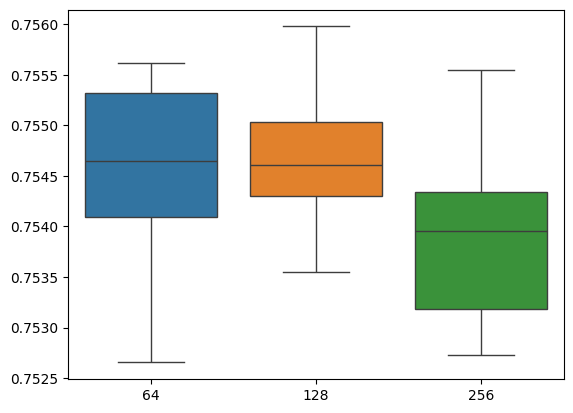

In [27]:
sns.boxplot(pd.DataFrame({128:f1s_128,64:f1s_64,256:f1s_256}))

### CatBoost Custom Ordinal Loss

A bust, not easy to implement. Abandon ship.
https://github.com/catboost/catboost/blob/master/catboost/tutorials/custom_loss/custom_loss_and_metric_tutorial.ipynb
https://github.com/catboost/catboost/issues/1994
https://github.com/catboost/catboost/issues/112
https://discourse.julialang.org/t/lend-a-hand-on-the-hessian-of-ordinal-logistic-regression/18842/4

In [8]:
# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y,df_val_y)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# Apply encoding
df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

df_train_X.drop(columns=geo_features, inplace=True)
df_val_X.drop(columns=geo_features, inplace=True)
df_test_X.drop(columns=geo_features, inplace=True)
df_pred_X.drop(columns=geo_features, inplace=True)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_X.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y],axis=0),
                            cat_features=categorical_features_indices)
train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                            cat_features=categorical_features_indices)


# # Instantiate catboost classifier model
# model_cls = cb.CatBoostClassifier(
#     # objective='MultiClass',  # Use 'MultiClass' for classification
#     loss_function=OrdinalClassificationObjective(),
#     # task_type='GPU',  # Specify GPU if available
#     # devices='0',  # Specify GPU device(s) if multiple
#     metric_period=500,  # Period to print metrics
#     iterations=1500,  # Number of boosting iterations
#     learning_rate=0.1,  # Learning rate
#     depth=8,  # Depth of the trees
#     l2_leaf_reg=5,  # L2 regularization coefficient
#     custom_metric=['Accuracy']  # Additional metrics to track
# )

# model_cls.fit(train_val_dataset)

# # Evaluation
# pred = model_cls.predict(df_test_X)
# acc = accuracy_score(df_test_y, pred)
# f1 = f1_score(df_test_y,pred,average='micro')

# print('Testing performance')
# print(f'Accuracy: {acc:.4f}')
# print(f'F1-score: {f1:.4f}')


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 345.13it/s]


Epoch [1/10], Loss: 7.116816820996499


Epoch 2/10: 100%|██████████| 1358/1358 [00:04<00:00, 288.48it/s]


Epoch [2/10], Loss: 0.5150763150057667


Epoch 3/10: 100%|██████████| 1358/1358 [00:04<00:00, 275.97it/s]


Epoch [3/10], Loss: 0.20980201876243584


Epoch 4/10: 100%|██████████| 1358/1358 [00:04<00:00, 293.19it/s]


Epoch [4/10], Loss: 0.14456527407345565


Epoch 5/10: 100%|██████████| 1358/1358 [00:04<00:00, 298.64it/s]


Epoch [5/10], Loss: 0.1118731138118802


Epoch 6/10: 100%|██████████| 1358/1358 [00:04<00:00, 292.71it/s]


Epoch [6/10], Loss: 0.09338239413810913


Epoch 7/10: 100%|██████████| 1358/1358 [00:04<00:00, 290.94it/s]


Epoch [7/10], Loss: 0.07604850767216671


Epoch 8/10: 100%|██████████| 1358/1358 [00:04<00:00, 276.80it/s]


Epoch [8/10], Loss: 0.07877733506243785


Epoch 9/10: 100%|██████████| 1358/1358 [00:04<00:00, 278.78it/s]


Epoch [9/10], Loss: 0.05996585634047719


Epoch 10/10: 100%|██████████| 1358/1358 [00:04<00:00, 271.84it/s]


Epoch [10/10], Loss: 0.05203287642783813


Evaluating: 100%|██████████| 2715/2715 [00:03<00:00, 717.74it/s]


In [42]:
class OrdinalAccuracyMetric(object):
    def get_final_error(self, error, weight):
        return error / (weight + 1e-38)

    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target, weight):
        # Convert approxes to a more interpretable format
        approxes = np.array(approxes)
        num_classes = approxes.shape[0]
        num_samples = approxes.shape[1]
        
        # Compute the predicted class for each sample
        best_class = np.zeros(num_samples)
        for i in range(num_samples):
            approx_i = approxes[:, i]
            best_class[i] = np.argmax(approx_i)
        
        # Calculate accuracy
        accuracy_sum = 0
        weight_sum = 0

        for i in range(len(target)):
            w = 1.0 if weight is None else weight[i]
            weight_sum += w
            accuracy_sum += w * (best_class[i] == target[i])

        return accuracy_sum, weight_sum

class OrdinalClassificationObjective(object):
    def calc_ders_multi(self, approx, target, weight):
        # Transform approx to log odds using Softmax
        approx = [approx[i] - max(approx) for i in range(len(approx))]
        exp_approx = [np.exp(approx[i]) for i in range(len(approx))]
        exp_sum = sum(exp_approx)
        
        # Compute probabilities
        probs = [exp_approx[i] / exp_sum for i in range(len(approx))]
        
        # Initialize gradient and Hessian
        grad = [0.0] * len(approx)
        hess = [[0.0] * len(approx) for _ in range(len(approx))]
        
        # Compute the derivative (gradient) and Hessian
        for j in range(len(approx)):
            der1 = probs[j]
            if j == target:
                der1 -= 1
            der1 *= weight
            
            for k in range(len(approx)):
                if j == k:
                    der2 = probs[j] * (1 - probs[j])
                else:
                    der2 = -probs[j] * probs[k]
                der2 *= weight
                
                hess[j][k] = der2
                
            grad[j] = der1
        
        return grad, hess

# Instantiate catboost classifier model
model_cls = cb.CatBoostClassifier(
    # objective='MultiClass',  # Use 'MultiClass' for classification
    # objective=OrdinalClassificationObjective(),
    loss_function=OrdinalClassificationObjective(),
    # eval_metric=[OrdinalAccuracyMetric()],
    # eval_metric=['Accuracy'],
    # task_type='GPU',  # Specify GPU if available
    # devices='0',  # Specify GPU device(s) if multiple
    metric_period=500,  # Period to print metrics
    iterations=1500,  # Number of boosting iterations
    learning_rate=0.1,  # Learning rate
    depth=8,  # Depth of the trees
    l2_leaf_reg=5,  # L2 regularization coefficient
    custom_metric=['MultiClassOneVsAll'],  # Additional metrics to track
    eval_metric=['MultiClassOneVsAll']
)

model_cls.fit(train_val_dataset)

# Evaluation
pred = model_cls.predict(df_test_X)
acc = accuracy_score(df_test_y, pred)
f1 = f1_score(df_test_y,pred,average='micro')

print('Testing performance')
print(f'Accuracy: {acc:.4f}')
print(f'F1-score: {f1:.4f}')


AttributeError: 'list' object has no attribute '_jited'

Exception ignored in: '_catboost._BuildCustomMetricDescriptor'
Traceback (most recent call last):
  File "_catboost.pyx", line 1660, in _catboost._try_jit_methods
AttributeError: 'list' object has no attribute '_jited'


AttributeError: 'list' object has no attribute '_jited'

Exception ignored in: '_catboost._BuildCustomMetricDescriptor'
Traceback (most recent call last):
  File "_catboost.pyx", line 1660, in _catboost._try_jit_methods
AttributeError: 'list' object has no attribute '_jited'


CatBoostError: /src/catboost/catboost/libs/metrics/metric.h:137: Any custom eval function must be defined

## Final Model Work

### Sub1 - Quick model with first run geo encoding

In [27]:
# Final model and predict
model = cb.CatBoostRegressor(loss_function='RMSE',
                             task_type='GPU',devices='0',
                             metric_period=500,
                             iterations=2000, learning_rate=0.2, depth=8,l2_leaf_reg=5)
model.fit(train_val_test_dataset)

0:	learn: 0.5830191	total: 13.4ms	remaining: 26.9s
500:	learn: 0.4176732	total: 6.03s	remaining: 18.1s
1000:	learn: 0.3976800	total: 12.1s	remaining: 12.1s
1500:	learn: 0.3831543	total: 18.2s	remaining: 6.04s
1999:	learn: 0.3712832	total: 24.2s	remaining: 0us


In [30]:
# Predict
# Load geo-encoding
with open('latent_geo_1.pkl','rb') as f:
    latent_geo = pickle.load(f)

df_final_pred = df_test_features.merge(latent_geo,on=geo_features,how='left')
df_final_pred.drop(columns=geo_features, inplace=True)
pred = model.predict(df_final_pred)
pred_int = np.round(np.clip(pred,1,3)).astype('int')

In [39]:
df_sub = pd.read_csv('./data/submission_format.csv')
df_sub['damage_grade'] = pred_int
df_sub.to_csv('./data/dd_earthquake_sub1.csv',index=False)

### Sub 2 - Baseline with just simple CatBoost without any geo encoding or fancy preprocessing

In [42]:
datapath = './data/' # local

df_train_features_raw = pd.read_csv(datapath+'train_values.csv').set_index('building_id')
df_train_labels_raw = pd.read_csv(datapath+'train_labels.csv').set_index('building_id')
df_pred_features_raw = pd.read_csv(datapath+'test_values.csv').set_index('building_id')

# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

df_train_features = preprocess(df_train_features_raw)
df_pred_features = preprocess(df_pred_features_raw)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_features.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_features, label=df_train_labels_raw, cat_features=categorical_features_indices)

# Instantiate catboost regressor model
model = cb.CatBoostRegressor(loss_function='RMSE',
                             task_type='GPU',devices='0',
                             metric_period=500,
                             iterations=2000, learning_rate=0.2, depth=8,l2_leaf_reg=5)
model.fit(train_dataset)

0:	learn: 0.5688387	total: 23ms	remaining: 45.9s
500:	learn: 0.4286066	total: 6.39s	remaining: 19.1s
1000:	learn: 0.4128214	total: 12.8s	remaining: 12.7s
1500:	learn: 0.3994321	total: 19.2s	remaining: 6.37s
1999:	learn: 0.3873596	total: 25.5s	remaining: 0us


In [43]:
pred = model.predict(df_pred_features)
pred_int = np.round(np.clip(pred,1,3)).astype('int')
df_sub = pd.read_csv('./data/submission_format.csv')
df_sub['damage_grade'] = pred_int
df_sub.to_csv('./data/dd_earthquake_sub2.csv',index=False)

### Sub 3 - geo-encoding with 'optimized' autoencoder network, and not dropping original geo features

In [53]:
# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X,
                                                   df_train_y,
                                                   df_val_y = df_val_y, df_test_y = df_test_y)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# Split into train, val, test and pred sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

# Apply encoding
df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

# df_train_X.drop(columns=geo_features, inplace=True)
# df_val_X.drop(columns=geo_features, inplace=True)
# df_test_X.drop(columns=geo_features, inplace=True)
# df_pred_X.drop(columns=geo_features, inplace=True)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_X.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y],axis=0),
                            cat_features=categorical_features_indices)
train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                            cat_features=categorical_features_indices)

# Instantiate catboost regressor model
model = cb.CatBoostRegressor(loss_function='RMSE',
                             task_type='GPU',devices='0',
                             metric_period=500,
                             iterations=2000, learning_rate=0.2, depth=8,l2_leaf_reg=5)
model.fit(train_val_test_dataset)

pred = model.predict(df_pred_X)
pred_int = np.round(np.clip(pred,1,3)).astype('int')
df_sub = pd.read_csv('./data/submission_format.csv')
df_sub['damage_grade'] = pred_int
df_sub.to_csv('./data/dd_earthquake_sub3.csv',index=False)

Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 499.80it/s]


Epoch [1/10], Loss: 6.872932761293097


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 497.04it/s]


Epoch [2/10], Loss: 0.47606034987278295


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 510.37it/s]


Epoch [3/10], Loss: 0.20224445410873823


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 512.41it/s]


Epoch [4/10], Loss: 0.14613145800370486


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 497.43it/s]


Epoch [5/10], Loss: 0.1012515675479516


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 507.90it/s]


Epoch [6/10], Loss: 0.1035112255869779


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 501.16it/s]


Epoch [7/10], Loss: 0.08537420844477471


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 481.67it/s]


Epoch [8/10], Loss: 0.05823486810532948


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 533.40it/s]


Epoch [9/10], Loss: 0.07236936649066548


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 488.94it/s]


Epoch [10/10], Loss: 0.04893300779870559


Evaluating: 100%|██████████| 2715/2715 [00:01<00:00, 1365.79it/s]


0:	learn: 0.5693521	total: 15.6ms	remaining: 31.1s
500:	learn: 0.4180906	total: 8.83s	remaining: 26.4s
1000:	learn: 0.3989183	total: 17.9s	remaining: 17.8s
1500:	learn: 0.3831546	total: 26.9s	remaining: 8.94s
1999:	learn: 0.3691349	total: 36s	remaining: 0us


### Subs 4,5,6,7 - Same 'optimized' geo-encoding as sub 3, but using classifier, after brief grid search

sub4 - using train_y for imputing, dropping geo features

sub5 - using train_y for imputing, not dropping geo features

sub6 - using train_y, val_y, and test_y for imputing, dropping geo features

sub7 - using train_y, val_y, and test_y for imputing, not dropping geo features

In [10]:
# Prep data for catboost
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y,df_val_y,df_test_y)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# Apply encoding
df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

# df_train_X.drop(columns=geo_features, inplace=True)
# df_val_X.drop(columns=geo_features, inplace=True)
# df_test_X.drop(columns=geo_features, inplace=True)
# df_pred_X.drop(columns=geo_features, inplace=True)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_X.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y],axis=0),
                            cat_features=categorical_features_indices)
train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                            cat_features=categorical_features_indices)

# Instantiate catboost classifier model
model = cb.CatBoostClassifier(
    objective='MultiClass',  # Use 'MultiClass' for classification
    task_type='GPU',  # Specify GPU if available
    devices='0',  # Specify GPU device(s) if multiple
    metric_period=500,  # Period to print metrics
    iterations=1500,  # Number of boosting iterations
    learning_rate=0.1,  # Learning rate
    depth=8,  # Depth of the trees
    l2_leaf_reg=5,  # L2 regularization coefficient
    custom_metric=['Accuracy']  # Additional metrics to track
)

model.fit(train_val_test_dataset)

pred = model.predict(df_pred_X)
pred_int = np.round(np.clip(pred,1,3)).astype('int')
df_sub = pd.read_csv('./data/submission_format.csv')
df_sub['damage_grade'] = pred_int
df_sub.to_csv('./data/dd_earthquake_sub6.csv',index=False)


Epoch 1/10: 100%|██████████| 1358/1358 [00:03<00:00, 420.42it/s]


Epoch [1/10], Loss: 6.921797679147418


Epoch 2/10: 100%|██████████| 1358/1358 [00:03<00:00, 415.82it/s]


Epoch [2/10], Loss: 0.44950586471799897


Epoch 3/10: 100%|██████████| 1358/1358 [00:03<00:00, 390.46it/s]


Epoch [3/10], Loss: 0.21960711612370254


Epoch 4/10: 100%|██████████| 1358/1358 [00:03<00:00, 399.00it/s]


Epoch [4/10], Loss: 0.1515745011834491


Epoch 5/10: 100%|██████████| 1358/1358 [00:03<00:00, 374.09it/s]


Epoch [5/10], Loss: 0.11430748657389257


Epoch 6/10: 100%|██████████| 1358/1358 [00:03<00:00, 358.46it/s]


Epoch [6/10], Loss: 0.09491197826561623


Epoch 7/10: 100%|██████████| 1358/1358 [00:03<00:00, 396.02it/s]


Epoch [7/10], Loss: 0.08953252143160727


Epoch 8/10: 100%|██████████| 1358/1358 [00:03<00:00, 376.37it/s]


Epoch [8/10], Loss: 0.06935888557661933


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 382.81it/s]


Epoch [9/10], Loss: 0.06747301706942402


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 382.04it/s]


Epoch [10/10], Loss: 0.06390182078558478


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1209.90it/s]


0:	learn: 1.0268014	total: 8.92ms	remaining: 13.4s
500:	learn: 0.5424863	total: 4.51s	remaining: 8.99s
1000:	learn: 0.5073094	total: 9.05s	remaining: 4.51s
1499:	learn: 0.4798260	total: 13.5s	remaining: 0us


In [11]:
# Prep data for catboost vanilla
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y,df_val_y,df_test_y)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# Apply encoding
df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

df_train_X.drop(columns=geo_features, inplace=True)
df_val_X.drop(columns=geo_features, inplace=True)
df_test_X.drop(columns=geo_features, inplace=True)
df_pred_X.drop(columns=geo_features, inplace=True)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_X.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y],axis=0),
                            cat_features=categorical_features_indices)
train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                            cat_features=categorical_features_indices)

# Instantiate catboost classifier model
model = cb.CatBoostClassifier(
    objective='MultiClass',  # Use 'MultiClass' for classification
    task_type='GPU',  # Specify GPU if available
    devices='0',  # Specify GPU device(s) if multiple
    metric_period=500,  # Period to print metrics
    iterations=1500,  # Number of boosting iterations
    learning_rate=0.1,  # Learning rate
    depth=8,  # Depth of the trees
    l2_leaf_reg=5,  # L2 regularization coefficient
    custom_metric=['Accuracy']  # Additional metrics to track
)

model.fit(train_val_test_dataset)

pred = model.predict(df_pred_X)
pred_int = np.round(np.clip(pred,1,3)).astype('int')
df_sub = pd.read_csv('./data/submission_format.csv')
df_sub['damage_grade'] = pred_int
df_sub.to_csv('./data/dd_earthquake_sub7.csv',index=False)


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 516.60it/s]


Epoch [1/10], Loss: 6.6866427218440005


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 503.90it/s]


Epoch [2/10], Loss: 0.4757724513405377


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 519.54it/s]


Epoch [3/10], Loss: 0.2366250776363446


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 516.52it/s]


Epoch [4/10], Loss: 0.14258367045259923


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 505.24it/s]


Epoch [5/10], Loss: 0.12255733814611702


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 514.11it/s]


Epoch [6/10], Loss: 0.10290135544983997


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 493.21it/s]


Epoch [7/10], Loss: 0.08641047392029175


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 460.11it/s]


Epoch [8/10], Loss: 0.0762477271975154


Epoch 9/10: 100%|██████████| 1358/1358 [00:03<00:00, 410.39it/s]


Epoch [9/10], Loss: 0.06565040449667736


Epoch 10/10: 100%|██████████| 1358/1358 [00:03<00:00, 390.42it/s]


Epoch [10/10], Loss: 0.06300597978181556


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1186.30it/s]


0:	learn: 1.0453548	total: 10.6ms	remaining: 15.8s
500:	learn: 0.5454940	total: 4.95s	remaining: 9.88s
1000:	learn: 0.5064358	total: 9.76s	remaining: 4.87s
1499:	learn: 0.4787255	total: 14.6s	remaining: 0us


### sub 8 - classsifier, geo-encoded (imputed with all), dropping OG geos, low learning rate

In [107]:
# Prep data for catboost
categorical_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 'land_surface_condition', 'foundation_type', 'roof_type', 'ground_floor_type', 'other_floor_type', 'position', 'plan_configuration', 'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
                        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber', 'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered', 'has_superstructure_other', 
                        'legal_ownership_status', 'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental', 'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post', 'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
geo_features = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_features = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

# Split into train, val, test and pred sets
X_train_or, df_test_X, y_train_or, df_test_y = train_test_split(df_train_features_raw, df_train_labels_raw, test_size = 0.15, random_state=42,stratify=df_train_labels_raw)
df_train_X, df_val_X, df_train_y, df_val_y = train_test_split(X_train_or, y_train_or, test_size = 0.15, random_state=42,stratify=y_train_or)
df_pred_X = df_pred_features_raw

# Get imputed damage grade to prep for geo-encoding
df_all, non_geo_features_OHE = impute_damage_grade(df_train_X, df_val_X, df_test_X,df_pred_X, df_train_y,df_val_y,df_test_y)

# Set up architecture
geo1_size = 16
geo2_size = 32
geo3_size = 64
inter_size = 128
latent_size = 64
epochs = 10

# Get latent geo-encoding
latent_geo,_,_,_,_,_ = get_latent_geo(df_all, non_geo_features_OHE, geo1_size, geo2_size,
                                              geo3_size, inter_size, latent_size, epochs)

# Apply encoding
df_train_X = df_train_X.merge(latent_geo,on=geo_features,how='left')
df_val_X = df_val_X.merge(latent_geo,on=geo_features,how='left')
df_test_X = df_test_X.merge(latent_geo,on=geo_features,how='left')
df_pred_X = df_pred_X.merge(latent_geo,on=geo_features,how='left')

# df_train_X.drop(columns=geo_features, inplace=True)
# df_val_X.drop(columns=geo_features, inplace=True)
# df_test_X.drop(columns=geo_features, inplace=True)
# df_pred_X.drop(columns=geo_features, inplace=True)

# Get categorical feature indices and names
categorical_features_indices = []
for i,dtype in enumerate(df_train_X.dtypes):
    if dtype in ['int64','int32','object','category']:
        categorical_features_indices.append(i)

# Create pooled dataset following catboost requirements
train_dataset = cb.Pool(data=df_train_X, label=df_train_y, cat_features=categorical_features_indices)
val_dataset = cb.Pool(data=df_val_X, label=df_val_y, cat_features=categorical_features_indices)
test_dataset = cb.Pool(data=df_test_X, label=df_test_y, cat_features=categorical_features_indices)
train_val_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y],axis=0),
                            cat_features=categorical_features_indices)
train_val_test_dataset = cb.Pool(data=pd.concat([df_train_X,df_val_X,df_test_X],axis=0),
                            label=pd.concat([df_train_y,df_val_y,df_test_y],axis=0),
                            cat_features=categorical_features_indices)

# Instantiate catboost classifier model
model = cb.CatBoostClassifier(
    objective='MultiClass',  # Use 'MultiClass' for classification
    task_type='GPU',  # Specify GPU if available
    devices='0',  # Specify GPU device(s) if multiple
    metric_period=500,  # Period to print metrics
    iterations=20000,  # Number of boosting iterations
    learning_rate=0.01,  # Learning rate
    depth=8,  # Depth of the trees
    l2_leaf_reg=5,  # L2 regularization coefficient
    custom_metric=['Accuracy']  # Additional metrics to track
)

model.fit(train_val_test_dataset)

pred = model.predict(df_pred_X)
pred_int = np.round(np.clip(pred,1,3)).astype('int')
df_sub = pd.read_csv('./data/submission_format.csv')
df_sub['damage_grade'] = pred_int
df_sub.to_csv('./data/dd_earthquake_sub8.csv',index=False)


Epoch 1/10: 100%|██████████| 1358/1358 [00:02<00:00, 477.97it/s]


Epoch [1/10], Loss: 6.722689362552802


Epoch 2/10: 100%|██████████| 1358/1358 [00:02<00:00, 510.80it/s]


Epoch [2/10], Loss: 0.4052885053638199


Epoch 3/10: 100%|██████████| 1358/1358 [00:02<00:00, 531.94it/s]


Epoch [3/10], Loss: 0.19650619847779552


Epoch 4/10: 100%|██████████| 1358/1358 [00:02<00:00, 486.59it/s]


Epoch [4/10], Loss: 0.14074171484833436


Epoch 5/10: 100%|██████████| 1358/1358 [00:02<00:00, 483.34it/s]


Epoch [5/10], Loss: 0.11159495172839727


Epoch 6/10: 100%|██████████| 1358/1358 [00:02<00:00, 531.24it/s]


Epoch [6/10], Loss: 0.08474032028265495


Epoch 7/10: 100%|██████████| 1358/1358 [00:02<00:00, 487.99it/s]


Epoch [7/10], Loss: 0.08266336095201493


Epoch 8/10: 100%|██████████| 1358/1358 [00:02<00:00, 484.51it/s]


Epoch [8/10], Loss: 0.07160139479691544


Epoch 9/10: 100%|██████████| 1358/1358 [00:02<00:00, 520.33it/s]


Epoch [9/10], Loss: 0.06759837730866562


Epoch 10/10: 100%|██████████| 1358/1358 [00:02<00:00, 518.23it/s]


Epoch [10/10], Loss: 0.056507483974273354


Evaluating: 100%|██████████| 2715/2715 [00:02<00:00, 1215.07it/s]


0:	learn: 1.0910881	total: 8.15ms	remaining: 2m 42s
500:	learn: 0.6194781	total: 4.19s	remaining: 2m 43s
1000:	learn: 0.5981686	total: 8.63s	remaining: 2m 43s
1500:	learn: 0.5848557	total: 13s	remaining: 2m 40s
2000:	learn: 0.5752006	total: 17.4s	remaining: 2m 36s
2500:	learn: 0.5670296	total: 21.9s	remaining: 2m 32s
3000:	learn: 0.5603184	total: 26.4s	remaining: 2m 29s
3500:	learn: 0.5546387	total: 30.8s	remaining: 2m 25s
4000:	learn: 0.5493841	total: 35.6s	remaining: 2m 22s
4500:	learn: 0.5444833	total: 40.2s	remaining: 2m 18s
5000:	learn: 0.5400272	total: 44.8s	remaining: 2m 14s
5500:	learn: 0.5358085	total: 49.3s	remaining: 2m 9s
6000:	learn: 0.5317854	total: 53.9s	remaining: 2m 5s
6500:	learn: 0.5279406	total: 58.3s	remaining: 2m 1s
7000:	learn: 0.5242918	total: 1m 2s	remaining: 1m 56s
7500:	learn: 0.5207195	total: 1m 7s	remaining: 1m 51s
8000:	learn: 0.5172874	total: 1m 11s	remaining: 1m 47s
8500:	learn: 0.5139485	total: 1m 15s	remaining: 1m 42s
9000:	learn: 0.5106749	total: 1m 2